In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## LECTURA Y PROCESO DE LOS DATOS

In [23]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [24]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [25]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [26]:
df = preprocess(data)

In [168]:
model_prediction_list = []

## MODELO 1: LIGHTGBM

In [167]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
categorical = [x for x in df.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 300,
    'verbose': 0
}

model1 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.678818
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.671244
[3]	valid_0's binary_logloss: 0.658622
[4]	valid_0's binary_logloss: 0.651967
[5]	valid_0's binary_logloss: 0.645049
[6]	valid_0's binary_logloss: 0.640738
[7]	valid_0's binary_logloss: 0.634202
[8]	valid_0's binary_logloss: 0.628022
[9]	valid_0's binary_logloss: 0.621918
[10]	valid_0's binary_logloss: 0.610847
[11]	valid_0's binary_logloss: 0.605226
[12]	valid_0's binary_logloss: 0.594588
[13]	valid_0's binary_logloss: 0.589352
[14]	valid_0's binary_logloss: 0.583709
[15]	valid_0's binary_logloss: 0.57372
[16]	valid_0's binary_logloss: 0.563954
[17]	valid_0's binary_logloss: 0.558776
[18]	valid_0's binary_logloss: 0.549456
[19]	valid_0's binary_logloss: 0.545755
[20]	valid_0's binary_logloss: 0.540958
[21]	valid_0's binary_logloss: 0.532046
[22]	valid_0's binary_logloss: 0.527789
[23]	valid_0's binary_logloss: 0.519
[24]	valid_0's binary_logloss: 

[218]	valid_0's binary_logloss: 0.139693
[219]	valid_0's binary_logloss: 0.139528
[220]	valid_0's binary_logloss: 0.138599
[221]	valid_0's binary_logloss: 0.13769
[222]	valid_0's binary_logloss: 0.137523
[223]	valid_0's binary_logloss: 0.136647
[224]	valid_0's binary_logloss: 0.135691
[225]	valid_0's binary_logloss: 0.134803
[226]	valid_0's binary_logloss: 0.134495
[227]	valid_0's binary_logloss: 0.133646
[228]	valid_0's binary_logloss: 0.132801
[229]	valid_0's binary_logloss: 0.132545
[230]	valid_0's binary_logloss: 0.132322
[231]	valid_0's binary_logloss: 0.13206
[232]	valid_0's binary_logloss: 0.131187
[233]	valid_0's binary_logloss: 0.131
[234]	valid_0's binary_logloss: 0.130176
[235]	valid_0's binary_logloss: 0.129948
[236]	valid_0's binary_logloss: 0.129745
[237]	valid_0's binary_logloss: 0.128984
[238]	valid_0's binary_logloss: 0.128158
[239]	valid_0's binary_logloss: 0.127882
[240]	valid_0's binary_logloss: 0.127121
[241]	valid_0's binary_logloss: 0.126868
[242]	valid_0's binar

[417]	valid_0's binary_logloss: 0.0824908
[418]	valid_0's binary_logloss: 0.0822593
[419]	valid_0's binary_logloss: 0.0821667
[420]	valid_0's binary_logloss: 0.0819571
[421]	valid_0's binary_logloss: 0.0819129
[422]	valid_0's binary_logloss: 0.0818506
[423]	valid_0's binary_logloss: 0.0816324
[424]	valid_0's binary_logloss: 0.081496
[425]	valid_0's binary_logloss: 0.0814505
[426]	valid_0's binary_logloss: 0.0813465
[427]	valid_0's binary_logloss: 0.0812702
[428]	valid_0's binary_logloss: 0.0812404
[429]	valid_0's binary_logloss: 0.0811622
[430]	valid_0's binary_logloss: 0.0810765
[431]	valid_0's binary_logloss: 0.0808743
[432]	valid_0's binary_logloss: 0.0808087
[433]	valid_0's binary_logloss: 0.0807486
[434]	valid_0's binary_logloss: 0.0805709
[435]	valid_0's binary_logloss: 0.0804912
[436]	valid_0's binary_logloss: 0.0804562
[437]	valid_0's binary_logloss: 0.0802868
[438]	valid_0's binary_logloss: 0.0800638
[439]	valid_0's binary_logloss: 0.0800337
[440]	valid_0's binary_logloss: 0.0

[621]	valid_0's binary_logloss: 0.0659699
[622]	valid_0's binary_logloss: 0.0658983
[623]	valid_0's binary_logloss: 0.0658934
[624]	valid_0's binary_logloss: 0.0658425
[625]	valid_0's binary_logloss: 0.0657767
[626]	valid_0's binary_logloss: 0.0657002
[627]	valid_0's binary_logloss: 0.0656211
[628]	valid_0's binary_logloss: 0.065585
[629]	valid_0's binary_logloss: 0.0655261
[630]	valid_0's binary_logloss: 0.0655181
[631]	valid_0's binary_logloss: 0.0654699
[632]	valid_0's binary_logloss: 0.0654334
[633]	valid_0's binary_logloss: 0.0654035
[634]	valid_0's binary_logloss: 0.0653691
[635]	valid_0's binary_logloss: 0.0653567
[636]	valid_0's binary_logloss: 0.0653417
[637]	valid_0's binary_logloss: 0.065266
[638]	valid_0's binary_logloss: 0.0652363
[639]	valid_0's binary_logloss: 0.0652059
[640]	valid_0's binary_logloss: 0.0651409
[641]	valid_0's binary_logloss: 0.0650592
[642]	valid_0's binary_logloss: 0.0649561
[643]	valid_0's binary_logloss: 0.0649232
[644]	valid_0's binary_logloss: 0.06

[850]	valid_0's binary_logloss: 0.0599048
[851]	valid_0's binary_logloss: 0.0598739
[852]	valid_0's binary_logloss: 0.0598844
[853]	valid_0's binary_logloss: 0.0598268
[854]	valid_0's binary_logloss: 0.0598022
[855]	valid_0's binary_logloss: 0.0597652
[856]	valid_0's binary_logloss: 0.05976
[857]	valid_0's binary_logloss: 0.0597074
[858]	valid_0's binary_logloss: 0.0596907
[859]	valid_0's binary_logloss: 0.0596607
[860]	valid_0's binary_logloss: 0.0596415
[861]	valid_0's binary_logloss: 0.0596387
[862]	valid_0's binary_logloss: 0.0596199
[863]	valid_0's binary_logloss: 0.0596029
[864]	valid_0's binary_logloss: 0.0595778
[865]	valid_0's binary_logloss: 0.0595349
[866]	valid_0's binary_logloss: 0.0595163
[867]	valid_0's binary_logloss: 0.059488
[868]	valid_0's binary_logloss: 0.0594653
[869]	valid_0's binary_logloss: 0.0594596
[870]	valid_0's binary_logloss: 0.0594577
[871]	valid_0's binary_logloss: 0.0594575
[872]	valid_0's binary_logloss: 0.0594738
[873]	valid_0's binary_logloss: 0.059

[1068]	valid_0's binary_logloss: 0.0576077
[1069]	valid_0's binary_logloss: 0.0576273
[1070]	valid_0's binary_logloss: 0.0576426
[1071]	valid_0's binary_logloss: 0.0576363
[1072]	valid_0's binary_logloss: 0.0576589
[1073]	valid_0's binary_logloss: 0.0576727
[1074]	valid_0's binary_logloss: 0.0576729
[1075]	valid_0's binary_logloss: 0.0576646
[1076]	valid_0's binary_logloss: 0.0576401
[1077]	valid_0's binary_logloss: 0.0576405
[1078]	valid_0's binary_logloss: 0.0576518
[1079]	valid_0's binary_logloss: 0.0576686
[1080]	valid_0's binary_logloss: 0.0576793
[1081]	valid_0's binary_logloss: 0.0576786
[1082]	valid_0's binary_logloss: 0.0577143
[1083]	valid_0's binary_logloss: 0.0577183
[1084]	valid_0's binary_logloss: 0.0577369
[1085]	valid_0's binary_logloss: 0.0577455
[1086]	valid_0's binary_logloss: 0.0577468
[1087]	valid_0's binary_logloss: 0.0577626
[1088]	valid_0's binary_logloss: 0.0577862
[1089]	valid_0's binary_logloss: 0.0578278
[1090]	valid_0's binary_logloss: 0.0578211
[1091]	vali

[1266]	valid_0's binary_logloss: 0.0571675
[1267]	valid_0's binary_logloss: 0.0571648
[1268]	valid_0's binary_logloss: 0.0572073
[1269]	valid_0's binary_logloss: 0.0571908
[1270]	valid_0's binary_logloss: 0.0571838
[1271]	valid_0's binary_logloss: 0.057181
[1272]	valid_0's binary_logloss: 0.0572
[1273]	valid_0's binary_logloss: 0.0572208
[1274]	valid_0's binary_logloss: 0.0572011
[1275]	valid_0's binary_logloss: 0.0572113
[1276]	valid_0's binary_logloss: 0.0572024
[1277]	valid_0's binary_logloss: 0.0571886
[1278]	valid_0's binary_logloss: 0.0571882
[1279]	valid_0's binary_logloss: 0.0572281
[1280]	valid_0's binary_logloss: 0.0572376
[1281]	valid_0's binary_logloss: 0.0572624
[1282]	valid_0's binary_logloss: 0.0572562
[1283]	valid_0's binary_logloss: 0.0572421
[1284]	valid_0's binary_logloss: 0.0572359
[1285]	valid_0's binary_logloss: 0.0572243
[1286]	valid_0's binary_logloss: 0.057208
[1287]	valid_0's binary_logloss: 0.0572008
[1288]	valid_0's binary_logloss: 0.0572013
[1289]	valid_0's

[1476]	valid_0's binary_logloss: 0.0578291
[1477]	valid_0's binary_logloss: 0.0578465
[1478]	valid_0's binary_logloss: 0.0578202
[1479]	valid_0's binary_logloss: 0.0578128
[1480]	valid_0's binary_logloss: 0.0578276
[1481]	valid_0's binary_logloss: 0.0578209
[1482]	valid_0's binary_logloss: 0.0578226
[1483]	valid_0's binary_logloss: 0.0578358
[1484]	valid_0's binary_logloss: 0.0578225
[1485]	valid_0's binary_logloss: 0.0578188
[1486]	valid_0's binary_logloss: 0.0578339
[1487]	valid_0's binary_logloss: 0.0578394
[1488]	valid_0's binary_logloss: 0.0578479
[1489]	valid_0's binary_logloss: 0.0578596
[1490]	valid_0's binary_logloss: 0.0578643
[1491]	valid_0's binary_logloss: 0.0578664
[1492]	valid_0's binary_logloss: 0.0578512
[1493]	valid_0's binary_logloss: 0.0578256
[1494]	valid_0's binary_logloss: 0.0578304
[1495]	valid_0's binary_logloss: 0.0578315
[1496]	valid_0's binary_logloss: 0.0578282
[1497]	valid_0's binary_logloss: 0.0578421
[1498]	valid_0's binary_logloss: 0.0578313
[1499]	vali

[1697]	valid_0's binary_logloss: 0.0603953
[1698]	valid_0's binary_logloss: 0.0603964
[1699]	valid_0's binary_logloss: 0.0603879
[1700]	valid_0's binary_logloss: 0.0604103
[1701]	valid_0's binary_logloss: 0.0604265
[1702]	valid_0's binary_logloss: 0.0604099
[1703]	valid_0's binary_logloss: 0.0604247
[1704]	valid_0's binary_logloss: 0.0603913
[1705]	valid_0's binary_logloss: 0.0603967
[1706]	valid_0's binary_logloss: 0.0603713
[1707]	valid_0's binary_logloss: 0.0603695
[1708]	valid_0's binary_logloss: 0.0603864
[1709]	valid_0's binary_logloss: 0.0603845
[1710]	valid_0's binary_logloss: 0.0603984
[1711]	valid_0's binary_logloss: 0.0603958
[1712]	valid_0's binary_logloss: 0.0603934
[1713]	valid_0's binary_logloss: 0.0603971
[1714]	valid_0's binary_logloss: 0.060427
[1715]	valid_0's binary_logloss: 0.0604038
[1716]	valid_0's binary_logloss: 0.0604016
[1717]	valid_0's binary_logloss: 0.0603952
[1718]	valid_0's binary_logloss: 0.0603648
[1719]	valid_0's binary_logloss: 0.0603652
[1720]	valid

In [169]:
y_pred = model1.predict(df.drop(target, axis = 1))

In [170]:
model_prediction_list.append(y_pred)

In [171]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model1.predict(validation.drop(leak, axis = 1))

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modellgb_pred.csv", header = False, index = False)

## MODELO 2: CATBOOST

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
cat_indexes = [x_train.drop(target, axis = 1).columns.get_loc(x) for x in categorical if x != "TRF_Cat"]

In [35]:
model2 = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               random_seed = 42)
model2.fit(x_train.drop(target, axis = 1), y_train, eval_set = (x_test.drop(target, axis=1), y_test), cat_features = cat_indexes, early_stopping_rounds = 800)

0:	learn: 0.6662320	test: 0.6666361	best: 0.6666361 (0)	total: 271ms	remaining: 22m 36s
1:	learn: 0.6429421	test: 0.6436226	best: 0.6436226 (1)	total: 349ms	remaining: 14m 32s
2:	learn: 0.6216509	test: 0.6225760	best: 0.6225760 (2)	total: 434ms	remaining: 12m 3s
3:	learn: 0.5973714	test: 0.5985329	best: 0.5985329 (3)	total: 558ms	remaining: 11m 37s
4:	learn: 0.5773562	test: 0.5786428	best: 0.5786428 (4)	total: 647ms	remaining: 10m 46s
5:	learn: 0.5590138	test: 0.5604702	best: 0.5604702 (5)	total: 677ms	remaining: 9m 23s
6:	learn: 0.5404298	test: 0.5413506	best: 0.5413506 (6)	total: 755ms	remaining: 8m 58s
7:	learn: 0.5231761	test: 0.5243156	best: 0.5243156 (7)	total: 816ms	remaining: 8m 29s
8:	learn: 0.5056932	test: 0.5075932	best: 0.5075932 (8)	total: 892ms	remaining: 8m 14s
9:	learn: 0.4882563	test: 0.4904856	best: 0.4904856 (9)	total: 968ms	remaining: 8m 3s
10:	learn: 0.4727450	test: 0.4752240	best: 0.4752240 (10)	total: 1.01s	remaining: 7m 38s
11:	learn: 0.4590669	test: 0.4617270	b

94:	learn: 0.1218370	test: 0.1321457	best: 0.1321457 (94)	total: 8.49s	remaining: 7m 18s
95:	learn: 0.1211156	test: 0.1314874	best: 0.1314874 (95)	total: 8.58s	remaining: 7m 18s
96:	learn: 0.1203174	test: 0.1307778	best: 0.1307778 (96)	total: 8.67s	remaining: 7m 18s
97:	learn: 0.1195648	test: 0.1300276	best: 0.1300276 (97)	total: 8.78s	remaining: 7m 19s
98:	learn: 0.1187170	test: 0.1292862	best: 0.1292862 (98)	total: 8.87s	remaining: 7m 18s
99:	learn: 0.1184590	test: 0.1290435	best: 0.1290435 (99)	total: 8.89s	remaining: 7m 15s
100:	learn: 0.1176779	test: 0.1283222	best: 0.1283222 (100)	total: 8.97s	remaining: 7m 15s
101:	learn: 0.1169994	test: 0.1277097	best: 0.1277097 (101)	total: 9.11s	remaining: 7m 17s
102:	learn: 0.1163760	test: 0.1271325	best: 0.1271325 (102)	total: 9.21s	remaining: 7m 17s
103:	learn: 0.1157885	test: 0.1266074	best: 0.1266074 (103)	total: 9.3s	remaining: 7m 17s
104:	learn: 0.1153557	test: 0.1262293	best: 0.1262293 (104)	total: 9.45s	remaining: 7m 20s
105:	learn: 

187:	learn: 0.0892496	test: 0.1039258	best: 0.1039258 (187)	total: 17.4s	remaining: 7m 25s
188:	learn: 0.0890528	test: 0.1037756	best: 0.1037756 (188)	total: 17.5s	remaining: 7m 25s
189:	learn: 0.0888709	test: 0.1035642	best: 0.1035642 (189)	total: 17.6s	remaining: 7m 25s
190:	learn: 0.0886846	test: 0.1033635	best: 0.1033635 (190)	total: 17.7s	remaining: 7m 25s
191:	learn: 0.0885327	test: 0.1032404	best: 0.1032404 (191)	total: 17.8s	remaining: 7m 25s
192:	learn: 0.0883016	test: 0.1030906	best: 0.1030906 (192)	total: 17.9s	remaining: 7m 25s
193:	learn: 0.0880725	test: 0.1029463	best: 0.1029463 (193)	total: 18s	remaining: 7m 25s
194:	learn: 0.0879826	test: 0.1028495	best: 0.1028495 (194)	total: 18.1s	remaining: 7m 25s
195:	learn: 0.0877902	test: 0.1027403	best: 0.1027403 (195)	total: 18.1s	remaining: 7m 24s
196:	learn: 0.0875712	test: 0.1025750	best: 0.1025750 (196)	total: 18.2s	remaining: 7m 24s
197:	learn: 0.0874899	test: 0.1025216	best: 0.1025216 (197)	total: 18.3s	remaining: 7m 24s
1

278:	learn: 0.0761172	test: 0.0940017	best: 0.0940017 (278)	total: 25.3s	remaining: 7m 7s
279:	learn: 0.0760530	test: 0.0939516	best: 0.0939516 (279)	total: 25.4s	remaining: 7m 8s
280:	learn: 0.0758541	test: 0.0937793	best: 0.0937793 (280)	total: 25.5s	remaining: 7m 8s
281:	learn: 0.0757854	test: 0.0937259	best: 0.0937259 (281)	total: 25.6s	remaining: 7m 8s
282:	learn: 0.0755799	test: 0.0935956	best: 0.0935956 (282)	total: 25.7s	remaining: 7m 8s
283:	learn: 0.0754156	test: 0.0934579	best: 0.0934579 (283)	total: 25.8s	remaining: 7m 8s
284:	learn: 0.0753467	test: 0.0934132	best: 0.0934132 (284)	total: 25.9s	remaining: 7m 8s
285:	learn: 0.0751822	test: 0.0932636	best: 0.0932636 (285)	total: 26s	remaining: 7m 8s
286:	learn: 0.0750065	test: 0.0932067	best: 0.0932067 (286)	total: 26.1s	remaining: 7m 8s
287:	learn: 0.0749518	test: 0.0931440	best: 0.0931440 (287)	total: 26.2s	remaining: 7m 7s
288:	learn: 0.0748420	test: 0.0930404	best: 0.0930404 (288)	total: 26.3s	remaining: 7m 8s
289:	learn: 

371:	learn: 0.0677941	test: 0.0882063	best: 0.0882063 (371)	total: 34.4s	remaining: 7m 8s
372:	learn: 0.0676799	test: 0.0881457	best: 0.0881457 (372)	total: 34.5s	remaining: 7m 8s
373:	learn: 0.0676091	test: 0.0881051	best: 0.0881051 (373)	total: 34.6s	remaining: 7m 8s
374:	learn: 0.0674606	test: 0.0880272	best: 0.0880272 (374)	total: 34.7s	remaining: 7m 8s
375:	learn: 0.0673482	test: 0.0879611	best: 0.0879611 (375)	total: 34.8s	remaining: 7m 8s
376:	learn: 0.0673179	test: 0.0879425	best: 0.0879425 (376)	total: 34.9s	remaining: 7m 7s
377:	learn: 0.0672593	test: 0.0879204	best: 0.0879204 (377)	total: 35s	remaining: 7m 7s
378:	learn: 0.0671375	test: 0.0878782	best: 0.0878782 (378)	total: 35.1s	remaining: 7m 8s
379:	learn: 0.0670964	test: 0.0878392	best: 0.0878392 (379)	total: 35.3s	remaining: 7m 8s
380:	learn: 0.0670371	test: 0.0878069	best: 0.0878069 (380)	total: 35.4s	remaining: 7m 8s
381:	learn: 0.0669159	test: 0.0877223	best: 0.0877223 (381)	total: 35.5s	remaining: 7m 8s
382:	learn: 

463:	learn: 0.0631009	test: 0.0854843	best: 0.0854843 (463)	total: 42.7s	remaining: 6m 57s
464:	learn: 0.0630501	test: 0.0854731	best: 0.0854731 (464)	total: 42.8s	remaining: 6m 57s
465:	learn: 0.0629675	test: 0.0854325	best: 0.0854325 (465)	total: 42.9s	remaining: 6m 57s
466:	learn: 0.0629319	test: 0.0854322	best: 0.0854322 (466)	total: 43s	remaining: 6m 57s
467:	learn: 0.0628259	test: 0.0853965	best: 0.0853965 (467)	total: 43.1s	remaining: 6m 56s
468:	learn: 0.0628016	test: 0.0853933	best: 0.0853933 (468)	total: 43.1s	remaining: 6m 56s
469:	learn: 0.0627182	test: 0.0853455	best: 0.0853455 (469)	total: 43.2s	remaining: 6m 56s
470:	learn: 0.0626953	test: 0.0853248	best: 0.0853248 (470)	total: 43.3s	remaining: 6m 56s
471:	learn: 0.0626778	test: 0.0853148	best: 0.0853148 (471)	total: 43.4s	remaining: 6m 56s
472:	learn: 0.0626078	test: 0.0852856	best: 0.0852856 (472)	total: 43.5s	remaining: 6m 56s
473:	learn: 0.0625321	test: 0.0852439	best: 0.0852439 (473)	total: 43.6s	remaining: 6m 56s
4

556:	learn: 0.0581511	test: 0.0826069	best: 0.0826069 (556)	total: 51s	remaining: 6m 47s
557:	learn: 0.0581223	test: 0.0825910	best: 0.0825910 (557)	total: 51.1s	remaining: 6m 47s
558:	learn: 0.0581061	test: 0.0825795	best: 0.0825795 (558)	total: 51.2s	remaining: 6m 46s
559:	learn: 0.0581046	test: 0.0825778	best: 0.0825778 (559)	total: 51.3s	remaining: 6m 46s
560:	learn: 0.0580626	test: 0.0825605	best: 0.0825605 (560)	total: 51.4s	remaining: 6m 46s
561:	learn: 0.0580351	test: 0.0825408	best: 0.0825408 (561)	total: 51.4s	remaining: 6m 46s
562:	learn: 0.0580271	test: 0.0825360	best: 0.0825360 (562)	total: 51.5s	remaining: 6m 46s
563:	learn: 0.0580258	test: 0.0825375	best: 0.0825360 (562)	total: 51.5s	remaining: 6m 45s
564:	learn: 0.0579912	test: 0.0825029	best: 0.0825029 (564)	total: 51.6s	remaining: 6m 45s
565:	learn: 0.0579402	test: 0.0824924	best: 0.0824924 (565)	total: 51.7s	remaining: 6m 45s
566:	learn: 0.0579037	test: 0.0824376	best: 0.0824376 (566)	total: 51.8s	remaining: 6m 45s
5

647:	learn: 0.0546270	test: 0.0804514	best: 0.0804514 (647)	total: 59.5s	remaining: 6m 39s
648:	learn: 0.0545426	test: 0.0804063	best: 0.0804063 (648)	total: 59.6s	remaining: 6m 39s
649:	learn: 0.0544886	test: 0.0803855	best: 0.0803855 (649)	total: 59.7s	remaining: 6m 39s
650:	learn: 0.0544434	test: 0.0803507	best: 0.0803507 (650)	total: 59.8s	remaining: 6m 39s
651:	learn: 0.0543446	test: 0.0802604	best: 0.0802604 (651)	total: 59.9s	remaining: 6m 39s
652:	learn: 0.0542783	test: 0.0802210	best: 0.0802210 (652)	total: 60s	remaining: 6m 39s
653:	learn: 0.0542340	test: 0.0802006	best: 0.0802006 (653)	total: 1m	remaining: 6m 39s
654:	learn: 0.0541586	test: 0.0801146	best: 0.0801146 (654)	total: 1m	remaining: 6m 39s
655:	learn: 0.0541009	test: 0.0800891	best: 0.0800891 (655)	total: 1m	remaining: 6m 38s
656:	learn: 0.0540484	test: 0.0800787	best: 0.0800787 (656)	total: 1m	remaining: 6m 38s
657:	learn: 0.0540333	test: 0.0800651	best: 0.0800651 (657)	total: 1m	remaining: 6m 38s
658:	learn: 0.05

740:	learn: 0.0499026	test: 0.0778406	best: 0.0778406 (740)	total: 1m 7s	remaining: 6m 30s
741:	learn: 0.0498746	test: 0.0778413	best: 0.0778406 (740)	total: 1m 8s	remaining: 6m 30s
742:	learn: 0.0498647	test: 0.0778369	best: 0.0778369 (742)	total: 1m 8s	remaining: 6m 30s
743:	learn: 0.0498382	test: 0.0778256	best: 0.0778256 (743)	total: 1m 8s	remaining: 6m 30s
744:	learn: 0.0498051	test: 0.0778032	best: 0.0778032 (744)	total: 1m 8s	remaining: 6m 30s
745:	learn: 0.0496933	test: 0.0776966	best: 0.0776966 (745)	total: 1m 8s	remaining: 6m 30s
746:	learn: 0.0496894	test: 0.0776962	best: 0.0776962 (746)	total: 1m 8s	remaining: 6m 30s
747:	learn: 0.0496680	test: 0.0776786	best: 0.0776786 (747)	total: 1m 8s	remaining: 6m 30s
748:	learn: 0.0496233	test: 0.0776477	best: 0.0776477 (748)	total: 1m 8s	remaining: 6m 30s
749:	learn: 0.0495583	test: 0.0775952	best: 0.0775952 (749)	total: 1m 8s	remaining: 6m 29s
750:	learn: 0.0495370	test: 0.0775788	best: 0.0775788 (750)	total: 1m 8s	remaining: 6m 29s

832:	learn: 0.0460047	test: 0.0753087	best: 0.0753087 (832)	total: 1m 16s	remaining: 6m 24s
833:	learn: 0.0459172	test: 0.0752684	best: 0.0752684 (833)	total: 1m 16s	remaining: 6m 24s
834:	learn: 0.0459124	test: 0.0752690	best: 0.0752684 (833)	total: 1m 17s	remaining: 6m 24s
835:	learn: 0.0458806	test: 0.0752492	best: 0.0752492 (835)	total: 1m 17s	remaining: 6m 24s
836:	learn: 0.0457883	test: 0.0751916	best: 0.0751916 (836)	total: 1m 17s	remaining: 6m 24s
837:	learn: 0.0457376	test: 0.0751603	best: 0.0751603 (837)	total: 1m 17s	remaining: 6m 24s
838:	learn: 0.0456928	test: 0.0751479	best: 0.0751479 (838)	total: 1m 17s	remaining: 6m 24s
839:	learn: 0.0456788	test: 0.0751465	best: 0.0751465 (839)	total: 1m 17s	remaining: 6m 24s
840:	learn: 0.0456513	test: 0.0751375	best: 0.0751375 (840)	total: 1m 17s	remaining: 6m 24s
841:	learn: 0.0456009	test: 0.0750932	best: 0.0750932 (841)	total: 1m 17s	remaining: 6m 24s
842:	learn: 0.0455611	test: 0.0750518	best: 0.0750518 (842)	total: 1m 17s	remain

922:	learn: 0.0428567	test: 0.0733559	best: 0.0733559 (922)	total: 1m 28s	remaining: 6m 29s
923:	learn: 0.0428134	test: 0.0733296	best: 0.0733296 (923)	total: 1m 28s	remaining: 6m 29s
924:	learn: 0.0427988	test: 0.0733318	best: 0.0733296 (923)	total: 1m 28s	remaining: 6m 29s
925:	learn: 0.0427868	test: 0.0733197	best: 0.0733197 (925)	total: 1m 28s	remaining: 6m 29s
926:	learn: 0.0426766	test: 0.0732205	best: 0.0732205 (926)	total: 1m 28s	remaining: 6m 29s
927:	learn: 0.0425952	test: 0.0731590	best: 0.0731590 (927)	total: 1m 28s	remaining: 6m 29s
928:	learn: 0.0425612	test: 0.0731401	best: 0.0731401 (928)	total: 1m 28s	remaining: 6m 29s
929:	learn: 0.0425368	test: 0.0731342	best: 0.0731342 (929)	total: 1m 28s	remaining: 6m 29s
930:	learn: 0.0425201	test: 0.0731320	best: 0.0731320 (930)	total: 1m 29s	remaining: 6m 29s
931:	learn: 0.0424771	test: 0.0730980	best: 0.0730980 (931)	total: 1m 29s	remaining: 6m 29s
932:	learn: 0.0424075	test: 0.0730718	best: 0.0730718 (932)	total: 1m 29s	remain

1011:	learn: 0.0402954	test: 0.0719212	best: 0.0719212 (1011)	total: 1m 36s	remaining: 6m 22s
1012:	learn: 0.0402740	test: 0.0719067	best: 0.0719067 (1012)	total: 1m 37s	remaining: 6m 22s
1013:	learn: 0.0402639	test: 0.0719110	best: 0.0719067 (1012)	total: 1m 37s	remaining: 6m 22s
1014:	learn: 0.0402527	test: 0.0719116	best: 0.0719067 (1012)	total: 1m 37s	remaining: 6m 22s
1015:	learn: 0.0401833	test: 0.0718925	best: 0.0718925 (1015)	total: 1m 37s	remaining: 6m 22s
1016:	learn: 0.0401648	test: 0.0718828	best: 0.0718828 (1016)	total: 1m 37s	remaining: 6m 22s
1017:	learn: 0.0401522	test: 0.0718744	best: 0.0718744 (1017)	total: 1m 37s	remaining: 6m 22s
1018:	learn: 0.0401320	test: 0.0718711	best: 0.0718711 (1018)	total: 1m 37s	remaining: 6m 22s
1019:	learn: 0.0400595	test: 0.0718146	best: 0.0718146 (1019)	total: 1m 37s	remaining: 6m 22s
1020:	learn: 0.0400159	test: 0.0717859	best: 0.0717859 (1020)	total: 1m 38s	remaining: 6m 22s
1021:	learn: 0.0399836	test: 0.0717786	best: 0.0717786 (1021

1099:	learn: 0.0380530	test: 0.0709457	best: 0.0709457 (1099)	total: 1m 46s	remaining: 6m 16s
1100:	learn: 0.0380437	test: 0.0709391	best: 0.0709391 (1100)	total: 1m 46s	remaining: 6m 16s
1101:	learn: 0.0380117	test: 0.0709264	best: 0.0709264 (1101)	total: 1m 46s	remaining: 6m 16s
1102:	learn: 0.0379812	test: 0.0709146	best: 0.0709146 (1102)	total: 1m 46s	remaining: 6m 15s
1103:	learn: 0.0379322	test: 0.0709092	best: 0.0709092 (1103)	total: 1m 46s	remaining: 6m 16s
1104:	learn: 0.0379236	test: 0.0709121	best: 0.0709092 (1103)	total: 1m 46s	remaining: 6m 16s
1105:	learn: 0.0378949	test: 0.0708883	best: 0.0708883 (1105)	total: 1m 46s	remaining: 6m 16s
1106:	learn: 0.0378559	test: 0.0708740	best: 0.0708740 (1106)	total: 1m 46s	remaining: 6m 16s
1107:	learn: 0.0377993	test: 0.0708606	best: 0.0708606 (1107)	total: 1m 47s	remaining: 6m 16s
1108:	learn: 0.0377810	test: 0.0708588	best: 0.0708588 (1108)	total: 1m 47s	remaining: 6m 15s
1109:	learn: 0.0377593	test: 0.0708426	best: 0.0708426 (1109

1187:	learn: 0.0358887	test: 0.0699242	best: 0.0699242 (1187)	total: 1m 54s	remaining: 6m 7s
1188:	learn: 0.0358596	test: 0.0699077	best: 0.0699077 (1188)	total: 1m 54s	remaining: 6m 7s
1189:	learn: 0.0358258	test: 0.0699148	best: 0.0699077 (1188)	total: 1m 54s	remaining: 6m 7s
1190:	learn: 0.0357756	test: 0.0698536	best: 0.0698536 (1190)	total: 1m 54s	remaining: 6m 7s
1191:	learn: 0.0357448	test: 0.0698470	best: 0.0698470 (1191)	total: 1m 54s	remaining: 6m 6s
1192:	learn: 0.0357394	test: 0.0698424	best: 0.0698424 (1192)	total: 1m 54s	remaining: 6m 6s
1193:	learn: 0.0357316	test: 0.0698395	best: 0.0698395 (1193)	total: 1m 55s	remaining: 6m 6s
1194:	learn: 0.0356896	test: 0.0698249	best: 0.0698249 (1194)	total: 1m 55s	remaining: 6m 6s
1195:	learn: 0.0356634	test: 0.0698114	best: 0.0698114 (1195)	total: 1m 55s	remaining: 6m 6s
1196:	learn: 0.0356426	test: 0.0697919	best: 0.0697919 (1196)	total: 1m 55s	remaining: 6m 6s
1197:	learn: 0.0356091	test: 0.0697832	best: 0.0697832 (1197)	total: 1

1278:	learn: 0.0338139	test: 0.0687991	best: 0.0687991 (1278)	total: 2m 3s	remaining: 5m 58s
1279:	learn: 0.0338067	test: 0.0687892	best: 0.0687892 (1279)	total: 2m 3s	remaining: 5m 58s
1280:	learn: 0.0338055	test: 0.0687864	best: 0.0687864 (1280)	total: 2m 3s	remaining: 5m 58s
1281:	learn: 0.0337839	test: 0.0687798	best: 0.0687798 (1281)	total: 2m 3s	remaining: 5m 58s
1282:	learn: 0.0337437	test: 0.0687510	best: 0.0687510 (1282)	total: 2m 3s	remaining: 5m 58s
1283:	learn: 0.0337381	test: 0.0687464	best: 0.0687464 (1283)	total: 2m 3s	remaining: 5m 58s
1284:	learn: 0.0337311	test: 0.0687444	best: 0.0687444 (1284)	total: 2m 3s	remaining: 5m 58s
1285:	learn: 0.0336780	test: 0.0687344	best: 0.0687344 (1285)	total: 2m 4s	remaining: 5m 58s
1286:	learn: 0.0336526	test: 0.0687164	best: 0.0687164 (1286)	total: 2m 4s	remaining: 5m 58s
1287:	learn: 0.0336272	test: 0.0687086	best: 0.0687086 (1287)	total: 2m 4s	remaining: 5m 57s
1288:	learn: 0.0335925	test: 0.0686873	best: 0.0686873 (1288)	total: 2

1367:	learn: 0.0317382	test: 0.0677780	best: 0.0677780 (1367)	total: 2m 12s	remaining: 5m 50s
1368:	learn: 0.0317070	test: 0.0677587	best: 0.0677587 (1368)	total: 2m 12s	remaining: 5m 50s
1369:	learn: 0.0316670	test: 0.0677567	best: 0.0677567 (1369)	total: 2m 12s	remaining: 5m 50s
1370:	learn: 0.0316555	test: 0.0677587	best: 0.0677567 (1369)	total: 2m 12s	remaining: 5m 50s
1371:	learn: 0.0316234	test: 0.0677454	best: 0.0677454 (1371)	total: 2m 12s	remaining: 5m 50s
1372:	learn: 0.0316084	test: 0.0677454	best: 0.0677454 (1371)	total: 2m 12s	remaining: 5m 50s
1373:	learn: 0.0315866	test: 0.0677242	best: 0.0677242 (1373)	total: 2m 12s	remaining: 5m 49s
1374:	learn: 0.0315413	test: 0.0677195	best: 0.0677195 (1374)	total: 2m 12s	remaining: 5m 49s
1375:	learn: 0.0315131	test: 0.0677071	best: 0.0677071 (1375)	total: 2m 12s	remaining: 5m 49s
1376:	learn: 0.0315015	test: 0.0677051	best: 0.0677051 (1376)	total: 2m 12s	remaining: 5m 49s
1377:	learn: 0.0314693	test: 0.0677049	best: 0.0677049 (1377

1455:	learn: 0.0299990	test: 0.0671195	best: 0.0671143 (1454)	total: 2m 21s	remaining: 5m 43s
1456:	learn: 0.0299948	test: 0.0671177	best: 0.0671143 (1454)	total: 2m 21s	remaining: 5m 43s
1457:	learn: 0.0299470	test: 0.0670845	best: 0.0670845 (1457)	total: 2m 21s	remaining: 5m 43s
1458:	learn: 0.0299141	test: 0.0670415	best: 0.0670415 (1458)	total: 2m 21s	remaining: 5m 43s
1459:	learn: 0.0298649	test: 0.0670215	best: 0.0670215 (1459)	total: 2m 21s	remaining: 5m 43s
1460:	learn: 0.0298569	test: 0.0670167	best: 0.0670167 (1460)	total: 2m 21s	remaining: 5m 43s
1461:	learn: 0.0298392	test: 0.0670037	best: 0.0670037 (1461)	total: 2m 21s	remaining: 5m 43s
1462:	learn: 0.0298339	test: 0.0669955	best: 0.0669955 (1462)	total: 2m 21s	remaining: 5m 43s
1463:	learn: 0.0298162	test: 0.0669868	best: 0.0669868 (1463)	total: 2m 21s	remaining: 5m 42s
1464:	learn: 0.0297893	test: 0.0669791	best: 0.0669791 (1464)	total: 2m 22s	remaining: 5m 42s
1465:	learn: 0.0297885	test: 0.0669788	best: 0.0669788 (1465

1544:	learn: 0.0283551	test: 0.0663198	best: 0.0663198 (1544)	total: 2m 30s	remaining: 5m 35s
1545:	learn: 0.0283302	test: 0.0663198	best: 0.0663198 (1545)	total: 2m 30s	remaining: 5m 35s
1546:	learn: 0.0283254	test: 0.0663235	best: 0.0663198 (1545)	total: 2m 30s	remaining: 5m 35s
1547:	learn: 0.0283012	test: 0.0663076	best: 0.0663076 (1547)	total: 2m 30s	remaining: 5m 35s
1548:	learn: 0.0282733	test: 0.0663024	best: 0.0663024 (1548)	total: 2m 30s	remaining: 5m 35s
1549:	learn: 0.0282390	test: 0.0663024	best: 0.0663024 (1548)	total: 2m 30s	remaining: 5m 35s
1550:	learn: 0.0282364	test: 0.0663013	best: 0.0663013 (1550)	total: 2m 30s	remaining: 5m 35s
1551:	learn: 0.0282343	test: 0.0662959	best: 0.0662959 (1551)	total: 2m 30s	remaining: 5m 35s
1552:	learn: 0.0282133	test: 0.0662910	best: 0.0662910 (1552)	total: 2m 31s	remaining: 5m 35s
1553:	learn: 0.0281808	test: 0.0662511	best: 0.0662511 (1553)	total: 2m 31s	remaining: 5m 35s
1554:	learn: 0.0281517	test: 0.0662487	best: 0.0662487 (1554

1632:	learn: 0.0268683	test: 0.0656533	best: 0.0656533 (1632)	total: 2m 38s	remaining: 5m 26s
1633:	learn: 0.0268220	test: 0.0656304	best: 0.0656304 (1633)	total: 2m 38s	remaining: 5m 26s
1634:	learn: 0.0267883	test: 0.0656312	best: 0.0656304 (1633)	total: 2m 38s	remaining: 5m 26s
1635:	learn: 0.0267820	test: 0.0656213	best: 0.0656213 (1635)	total: 2m 38s	remaining: 5m 26s
1636:	learn: 0.0267633	test: 0.0656149	best: 0.0656149 (1636)	total: 2m 38s	remaining: 5m 25s
1637:	learn: 0.0267539	test: 0.0656158	best: 0.0656149 (1636)	total: 2m 38s	remaining: 5m 25s
1638:	learn: 0.0267287	test: 0.0656114	best: 0.0656114 (1638)	total: 2m 38s	remaining: 5m 25s
1639:	learn: 0.0266992	test: 0.0655954	best: 0.0655954 (1639)	total: 2m 38s	remaining: 5m 25s
1640:	learn: 0.0266962	test: 0.0655925	best: 0.0655925 (1640)	total: 2m 39s	remaining: 5m 25s
1641:	learn: 0.0266940	test: 0.0655880	best: 0.0655880 (1641)	total: 2m 39s	remaining: 5m 25s
1642:	learn: 0.0266921	test: 0.0655829	best: 0.0655829 (1642

1722:	learn: 0.0252975	test: 0.0649404	best: 0.0649404 (1722)	total: 2m 47s	remaining: 5m 17s
1723:	learn: 0.0252734	test: 0.0649101	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1724:	learn: 0.0252717	test: 0.0649115	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1725:	learn: 0.0252467	test: 0.0649163	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1726:	learn: 0.0252390	test: 0.0649128	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1727:	learn: 0.0251835	test: 0.0649197	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1728:	learn: 0.0251620	test: 0.0649182	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1729:	learn: 0.0251435	test: 0.0649151	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1730:	learn: 0.0251300	test: 0.0649179	best: 0.0649101 (1723)	total: 2m 47s	remaining: 5m 17s
1731:	learn: 0.0251138	test: 0.0649244	best: 0.0649101 (1723)	total: 2m 48s	remaining: 5m 17s
1732:	learn: 0.0250758	test: 0.0648960	best: 0.0648960 (1732

1810:	learn: 0.0240709	test: 0.0645198	best: 0.0645172 (1804)	total: 2m 55s	remaining: 5m 9s
1811:	learn: 0.0240633	test: 0.0645169	best: 0.0645169 (1811)	total: 2m 56s	remaining: 5m 9s
1812:	learn: 0.0240622	test: 0.0645167	best: 0.0645167 (1812)	total: 2m 56s	remaining: 5m 9s
1813:	learn: 0.0240367	test: 0.0645019	best: 0.0645019 (1813)	total: 2m 56s	remaining: 5m 9s
1814:	learn: 0.0240333	test: 0.0644976	best: 0.0644976 (1814)	total: 2m 56s	remaining: 5m 9s
1815:	learn: 0.0240197	test: 0.0644907	best: 0.0644907 (1815)	total: 2m 56s	remaining: 5m 9s
1816:	learn: 0.0240106	test: 0.0644973	best: 0.0644907 (1815)	total: 2m 56s	remaining: 5m 9s
1817:	learn: 0.0240073	test: 0.0645005	best: 0.0644907 (1815)	total: 2m 56s	remaining: 5m 9s
1818:	learn: 0.0239959	test: 0.0644997	best: 0.0644907 (1815)	total: 2m 56s	remaining: 5m 9s
1819:	learn: 0.0239738	test: 0.0644914	best: 0.0644907 (1815)	total: 2m 56s	remaining: 5m 9s
1820:	learn: 0.0239688	test: 0.0644851	best: 0.0644851 (1820)	total: 2

1900:	learn: 0.0231016	test: 0.0640000	best: 0.0640000 (1900)	total: 3m 4s	remaining: 5m
1901:	learn: 0.0230963	test: 0.0640084	best: 0.0640000 (1900)	total: 3m 4s	remaining: 5m
1902:	learn: 0.0230782	test: 0.0640079	best: 0.0640000 (1900)	total: 3m 4s	remaining: 5m
1903:	learn: 0.0230731	test: 0.0640162	best: 0.0640000 (1900)	total: 3m 4s	remaining: 5m
1904:	learn: 0.0230656	test: 0.0640219	best: 0.0640000 (1900)	total: 3m 4s	remaining: 5m
1905:	learn: 0.0230563	test: 0.0640131	best: 0.0640000 (1900)	total: 3m 4s	remaining: 4m 59s
1906:	learn: 0.0230561	test: 0.0640132	best: 0.0640000 (1900)	total: 3m 4s	remaining: 4m 59s
1907:	learn: 0.0230535	test: 0.0640118	best: 0.0640000 (1900)	total: 3m 4s	remaining: 4m 59s
1908:	learn: 0.0230449	test: 0.0639995	best: 0.0639995 (1908)	total: 3m 5s	remaining: 4m 59s
1909:	learn: 0.0230167	test: 0.0639954	best: 0.0639954 (1909)	total: 3m 5s	remaining: 4m 59s
1910:	learn: 0.0230100	test: 0.0639929	best: 0.0639929 (1910)	total: 3m 5s	remaining: 4m 5

1990:	learn: 0.0219837	test: 0.0635855	best: 0.0635852 (1989)	total: 3m 13s	remaining: 4m 52s
1991:	learn: 0.0219698	test: 0.0635769	best: 0.0635769 (1991)	total: 3m 13s	remaining: 4m 52s
1992:	learn: 0.0219480	test: 0.0635872	best: 0.0635769 (1991)	total: 3m 13s	remaining: 4m 52s
1993:	learn: 0.0219194	test: 0.0635829	best: 0.0635769 (1991)	total: 3m 14s	remaining: 4m 52s
1994:	learn: 0.0219012	test: 0.0635874	best: 0.0635769 (1991)	total: 3m 14s	remaining: 4m 52s
1995:	learn: 0.0218726	test: 0.0635647	best: 0.0635647 (1995)	total: 3m 14s	remaining: 4m 52s
1996:	learn: 0.0218677	test: 0.0635673	best: 0.0635647 (1995)	total: 3m 14s	remaining: 4m 52s
1997:	learn: 0.0218674	test: 0.0635654	best: 0.0635647 (1995)	total: 3m 14s	remaining: 4m 52s
1998:	learn: 0.0218636	test: 0.0635633	best: 0.0635633 (1998)	total: 3m 14s	remaining: 4m 52s
1999:	learn: 0.0218578	test: 0.0635639	best: 0.0635633 (1998)	total: 3m 14s	remaining: 4m 52s
2000:	learn: 0.0218547	test: 0.0635657	best: 0.0635633 (1998

2080:	learn: 0.0209405	test: 0.0631430	best: 0.0631381 (2076)	total: 3m 22s	remaining: 4m 44s
2081:	learn: 0.0209119	test: 0.0631125	best: 0.0631125 (2081)	total: 3m 22s	remaining: 4m 44s
2082:	learn: 0.0208957	test: 0.0631183	best: 0.0631125 (2081)	total: 3m 22s	remaining: 4m 43s
2083:	learn: 0.0208907	test: 0.0631181	best: 0.0631125 (2081)	total: 3m 22s	remaining: 4m 43s
2084:	learn: 0.0208797	test: 0.0630984	best: 0.0630984 (2084)	total: 3m 22s	remaining: 4m 43s
2085:	learn: 0.0208565	test: 0.0630990	best: 0.0630984 (2084)	total: 3m 22s	remaining: 4m 43s
2086:	learn: 0.0208437	test: 0.0630896	best: 0.0630896 (2086)	total: 3m 23s	remaining: 4m 43s
2087:	learn: 0.0208403	test: 0.0630892	best: 0.0630892 (2087)	total: 3m 23s	remaining: 4m 43s
2088:	learn: 0.0208262	test: 0.0630702	best: 0.0630702 (2088)	total: 3m 23s	remaining: 4m 43s
2089:	learn: 0.0208185	test: 0.0630632	best: 0.0630632 (2089)	total: 3m 23s	remaining: 4m 43s
2090:	learn: 0.0208147	test: 0.0630629	best: 0.0630629 (2090

2169:	learn: 0.0199733	test: 0.0626803	best: 0.0626695 (2166)	total: 3m 30s	remaining: 4m 34s
2170:	learn: 0.0199580	test: 0.0626738	best: 0.0626695 (2166)	total: 3m 30s	remaining: 4m 34s
2171:	learn: 0.0199405	test: 0.0626714	best: 0.0626695 (2166)	total: 3m 30s	remaining: 4m 34s
2172:	learn: 0.0199171	test: 0.0626718	best: 0.0626695 (2166)	total: 3m 30s	remaining: 4m 34s
2173:	learn: 0.0199089	test: 0.0626674	best: 0.0626674 (2173)	total: 3m 30s	remaining: 4m 34s
2174:	learn: 0.0198947	test: 0.0626633	best: 0.0626633 (2174)	total: 3m 30s	remaining: 4m 33s
2175:	learn: 0.0198720	test: 0.0626641	best: 0.0626633 (2174)	total: 3m 31s	remaining: 4m 33s
2176:	learn: 0.0198636	test: 0.0626642	best: 0.0626633 (2174)	total: 3m 31s	remaining: 4m 33s
2177:	learn: 0.0198584	test: 0.0626626	best: 0.0626626 (2177)	total: 3m 31s	remaining: 4m 33s
2178:	learn: 0.0198528	test: 0.0626700	best: 0.0626626 (2177)	total: 3m 31s	remaining: 4m 33s
2179:	learn: 0.0198436	test: 0.0626545	best: 0.0626545 (2179

2258:	learn: 0.0190128	test: 0.0623947	best: 0.0623869 (2239)	total: 3m 38s	remaining: 4m 25s
2259:	learn: 0.0190027	test: 0.0623840	best: 0.0623840 (2259)	total: 3m 38s	remaining: 4m 24s
2260:	learn: 0.0189909	test: 0.0623787	best: 0.0623787 (2260)	total: 3m 38s	remaining: 4m 24s
2261:	learn: 0.0189820	test: 0.0623787	best: 0.0623787 (2261)	total: 3m 38s	remaining: 4m 24s
2262:	learn: 0.0189795	test: 0.0623819	best: 0.0623787 (2261)	total: 3m 38s	remaining: 4m 24s
2263:	learn: 0.0189768	test: 0.0623799	best: 0.0623787 (2261)	total: 3m 38s	remaining: 4m 24s
2264:	learn: 0.0189698	test: 0.0623750	best: 0.0623750 (2264)	total: 3m 38s	remaining: 4m 24s
2265:	learn: 0.0189650	test: 0.0623740	best: 0.0623740 (2265)	total: 3m 39s	remaining: 4m 24s
2266:	learn: 0.0189364	test: 0.0623545	best: 0.0623545 (2266)	total: 3m 39s	remaining: 4m 24s
2267:	learn: 0.0189189	test: 0.0623697	best: 0.0623545 (2266)	total: 3m 39s	remaining: 4m 24s
2268:	learn: 0.0188976	test: 0.0623436	best: 0.0623436 (2268

2348:	learn: 0.0182183	test: 0.0622029	best: 0.0621831 (2330)	total: 3m 46s	remaining: 4m 15s
2349:	learn: 0.0182073	test: 0.0621935	best: 0.0621831 (2330)	total: 3m 46s	remaining: 4m 15s
2350:	learn: 0.0182007	test: 0.0621838	best: 0.0621831 (2330)	total: 3m 46s	remaining: 4m 15s
2351:	learn: 0.0181787	test: 0.0621749	best: 0.0621749 (2351)	total: 3m 46s	remaining: 4m 15s
2352:	learn: 0.0181649	test: 0.0621754	best: 0.0621749 (2351)	total: 3m 46s	remaining: 4m 14s
2353:	learn: 0.0181562	test: 0.0621688	best: 0.0621688 (2353)	total: 3m 46s	remaining: 4m 14s
2354:	learn: 0.0181335	test: 0.0621651	best: 0.0621651 (2354)	total: 3m 46s	remaining: 4m 14s
2355:	learn: 0.0181293	test: 0.0621692	best: 0.0621651 (2354)	total: 3m 46s	remaining: 4m 14s
2356:	learn: 0.0181293	test: 0.0621690	best: 0.0621651 (2354)	total: 3m 46s	remaining: 4m 14s
2357:	learn: 0.0181205	test: 0.0621671	best: 0.0621651 (2354)	total: 3m 47s	remaining: 4m 14s
2358:	learn: 0.0181052	test: 0.0621867	best: 0.0621651 (2354

2437:	learn: 0.0175341	test: 0.0620076	best: 0.0620069 (2436)	total: 3m 54s	remaining: 4m 6s
2438:	learn: 0.0175302	test: 0.0620028	best: 0.0620028 (2438)	total: 3m 54s	remaining: 4m 6s
2439:	learn: 0.0175272	test: 0.0620065	best: 0.0620028 (2438)	total: 3m 54s	remaining: 4m 6s
2440:	learn: 0.0175205	test: 0.0620048	best: 0.0620028 (2438)	total: 3m 54s	remaining: 4m 6s
2441:	learn: 0.0175191	test: 0.0619996	best: 0.0619996 (2441)	total: 3m 54s	remaining: 4m 5s
2442:	learn: 0.0175191	test: 0.0619996	best: 0.0619996 (2441)	total: 3m 54s	remaining: 4m 5s
2443:	learn: 0.0175111	test: 0.0619885	best: 0.0619885 (2443)	total: 3m 54s	remaining: 4m 5s
2444:	learn: 0.0175029	test: 0.0619992	best: 0.0619885 (2443)	total: 3m 55s	remaining: 4m 5s
2445:	learn: 0.0174653	test: 0.0619617	best: 0.0619617 (2445)	total: 3m 55s	remaining: 4m 5s
2446:	learn: 0.0174442	test: 0.0619599	best: 0.0619599 (2446)	total: 3m 55s	remaining: 4m 5s
2447:	learn: 0.0174376	test: 0.0619593	best: 0.0619593 (2447)	total: 3

2526:	learn: 0.0167960	test: 0.0617842	best: 0.0617803 (2521)	total: 4m 2s	remaining: 3m 57s
2527:	learn: 0.0167868	test: 0.0617939	best: 0.0617803 (2521)	total: 4m 2s	remaining: 3m 57s
2528:	learn: 0.0167800	test: 0.0617917	best: 0.0617803 (2521)	total: 4m 2s	remaining: 3m 56s
2529:	learn: 0.0167764	test: 0.0617806	best: 0.0617803 (2521)	total: 4m 2s	remaining: 3m 56s
2530:	learn: 0.0167674	test: 0.0617843	best: 0.0617803 (2521)	total: 4m 2s	remaining: 3m 56s
2531:	learn: 0.0167589	test: 0.0617764	best: 0.0617764 (2531)	total: 4m 2s	remaining: 3m 56s
2532:	learn: 0.0167515	test: 0.0617804	best: 0.0617764 (2531)	total: 4m 2s	remaining: 3m 56s
2533:	learn: 0.0167469	test: 0.0617914	best: 0.0617764 (2531)	total: 4m 2s	remaining: 3m 56s
2534:	learn: 0.0167449	test: 0.0617895	best: 0.0617764 (2531)	total: 4m 3s	remaining: 3m 56s
2535:	learn: 0.0167400	test: 0.0617879	best: 0.0617764 (2531)	total: 4m 3s	remaining: 3m 56s
2536:	learn: 0.0167347	test: 0.0617851	best: 0.0617764 (2531)	total: 4

2615:	learn: 0.0162028	test: 0.0615807	best: 0.0615761 (2614)	total: 4m 10s	remaining: 3m 47s
2616:	learn: 0.0162026	test: 0.0615803	best: 0.0615761 (2614)	total: 4m 10s	remaining: 3m 47s
2617:	learn: 0.0161849	test: 0.0615901	best: 0.0615761 (2614)	total: 4m 10s	remaining: 3m 47s
2618:	learn: 0.0161584	test: 0.0615761	best: 0.0615761 (2614)	total: 4m 10s	remaining: 3m 47s
2619:	learn: 0.0161564	test: 0.0615763	best: 0.0615761 (2614)	total: 4m 10s	remaining: 3m 47s
2620:	learn: 0.0161489	test: 0.0615758	best: 0.0615758 (2620)	total: 4m 10s	remaining: 3m 47s
2621:	learn: 0.0161349	test: 0.0615630	best: 0.0615630 (2621)	total: 4m 10s	remaining: 3m 47s
2622:	learn: 0.0161294	test: 0.0615688	best: 0.0615630 (2621)	total: 4m 10s	remaining: 3m 47s
2623:	learn: 0.0161258	test: 0.0615693	best: 0.0615630 (2621)	total: 4m 10s	remaining: 3m 47s
2624:	learn: 0.0161125	test: 0.0615603	best: 0.0615603 (2624)	total: 4m 10s	remaining: 3m 47s
2625:	learn: 0.0161109	test: 0.0615628	best: 0.0615603 (2624

2705:	learn: 0.0155639	test: 0.0613806	best: 0.0613722 (2703)	total: 4m 17s	remaining: 3m 38s
2706:	learn: 0.0155365	test: 0.0613506	best: 0.0613506 (2706)	total: 4m 18s	remaining: 3m 38s
2707:	learn: 0.0155332	test: 0.0613625	best: 0.0613506 (2706)	total: 4m 18s	remaining: 3m 38s
2708:	learn: 0.0155332	test: 0.0613625	best: 0.0613506 (2706)	total: 4m 18s	remaining: 3m 38s
2709:	learn: 0.0155289	test: 0.0613739	best: 0.0613506 (2706)	total: 4m 18s	remaining: 3m 38s
2710:	learn: 0.0155222	test: 0.0613600	best: 0.0613506 (2706)	total: 4m 18s	remaining: 3m 38s
2711:	learn: 0.0155222	test: 0.0613600	best: 0.0613506 (2706)	total: 4m 18s	remaining: 3m 38s
2712:	learn: 0.0154954	test: 0.0613309	best: 0.0613309 (2712)	total: 4m 18s	remaining: 3m 37s
2713:	learn: 0.0154922	test: 0.0613427	best: 0.0613309 (2712)	total: 4m 18s	remaining: 3m 37s
2714:	learn: 0.0154718	test: 0.0613225	best: 0.0613225 (2714)	total: 4m 18s	remaining: 3m 37s
2715:	learn: 0.0154660	test: 0.0613155	best: 0.0613155 (2715

2795:	learn: 0.0149561	test: 0.0611367	best: 0.0611367 (2795)	total: 4m 25s	remaining: 3m 29s
2796:	learn: 0.0149542	test: 0.0611358	best: 0.0611358 (2796)	total: 4m 25s	remaining: 3m 29s
2797:	learn: 0.0149499	test: 0.0611320	best: 0.0611320 (2797)	total: 4m 25s	remaining: 3m 29s
2798:	learn: 0.0149477	test: 0.0611323	best: 0.0611320 (2797)	total: 4m 25s	remaining: 3m 29s
2799:	learn: 0.0149395	test: 0.0611217	best: 0.0611217 (2799)	total: 4m 25s	remaining: 3m 28s
2800:	learn: 0.0149290	test: 0.0611196	best: 0.0611196 (2800)	total: 4m 26s	remaining: 3m 28s
2801:	learn: 0.0149268	test: 0.0611197	best: 0.0611196 (2800)	total: 4m 26s	remaining: 3m 28s
2802:	learn: 0.0149248	test: 0.0611184	best: 0.0611184 (2802)	total: 4m 26s	remaining: 3m 28s
2803:	learn: 0.0149116	test: 0.0610906	best: 0.0610906 (2803)	total: 4m 26s	remaining: 3m 28s
2804:	learn: 0.0149080	test: 0.0610969	best: 0.0610906 (2803)	total: 4m 26s	remaining: 3m 28s
2805:	learn: 0.0149048	test: 0.0611003	best: 0.0610906 (2803

2884:	learn: 0.0144230	test: 0.0609518	best: 0.0609518 (2884)	total: 4m 33s	remaining: 3m 20s
2885:	learn: 0.0144125	test: 0.0609539	best: 0.0609518 (2884)	total: 4m 33s	remaining: 3m 20s
2886:	learn: 0.0144051	test: 0.0609474	best: 0.0609474 (2886)	total: 4m 33s	remaining: 3m 20s
2887:	learn: 0.0144003	test: 0.0609389	best: 0.0609389 (2887)	total: 4m 33s	remaining: 3m 20s
2888:	learn: 0.0143869	test: 0.0609194	best: 0.0609194 (2888)	total: 4m 34s	remaining: 3m 20s
2889:	learn: 0.0143831	test: 0.0609240	best: 0.0609194 (2888)	total: 4m 34s	remaining: 3m 20s
2890:	learn: 0.0143721	test: 0.0609024	best: 0.0609024 (2890)	total: 4m 34s	remaining: 3m 20s
2891:	learn: 0.0143698	test: 0.0608989	best: 0.0608989 (2891)	total: 4m 34s	remaining: 3m 20s
2892:	learn: 0.0143565	test: 0.0609046	best: 0.0608989 (2891)	total: 4m 34s	remaining: 3m 19s
2893:	learn: 0.0143406	test: 0.0608892	best: 0.0608892 (2893)	total: 4m 34s	remaining: 3m 19s
2894:	learn: 0.0143356	test: 0.0608756	best: 0.0608756 (2894

2973:	learn: 0.0139849	test: 0.0607312	best: 0.0607312 (2972)	total: 4m 41s	remaining: 3m 11s
2974:	learn: 0.0139849	test: 0.0607312	best: 0.0607312 (2972)	total: 4m 41s	remaining: 3m 11s
2975:	learn: 0.0139811	test: 0.0607313	best: 0.0607312 (2972)	total: 4m 41s	remaining: 3m 11s
2976:	learn: 0.0139774	test: 0.0607260	best: 0.0607260 (2976)	total: 4m 41s	remaining: 3m 11s
2977:	learn: 0.0139750	test: 0.0607316	best: 0.0607260 (2976)	total: 4m 41s	remaining: 3m 11s
2978:	learn: 0.0139728	test: 0.0607337	best: 0.0607260 (2976)	total: 4m 41s	remaining: 3m 11s
2979:	learn: 0.0139685	test: 0.0607253	best: 0.0607253 (2979)	total: 4m 42s	remaining: 3m 11s
2980:	learn: 0.0139575	test: 0.0607363	best: 0.0607253 (2979)	total: 4m 42s	remaining: 3m 11s
2981:	learn: 0.0139551	test: 0.0607364	best: 0.0607253 (2979)	total: 4m 42s	remaining: 3m 11s
2982:	learn: 0.0139503	test: 0.0607406	best: 0.0607253 (2979)	total: 4m 42s	remaining: 3m 10s
2983:	learn: 0.0139482	test: 0.0607449	best: 0.0607253 (2979

3063:	learn: 0.0136245	test: 0.0606801	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3064:	learn: 0.0136134	test: 0.0606758	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3065:	learn: 0.0136060	test: 0.0606977	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3066:	learn: 0.0136049	test: 0.0606974	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3067:	learn: 0.0136006	test: 0.0607019	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3068:	learn: 0.0135939	test: 0.0606882	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3069:	learn: 0.0135882	test: 0.0606908	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 2s
3070:	learn: 0.0135832	test: 0.0606897	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 1s
3071:	learn: 0.0135784	test: 0.0606916	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 1s
3072:	learn: 0.0135764	test: 0.0606902	best: 0.0606616 (3058)	total: 4m 49s	remaining: 3m 1s
3073:	learn: 0.0135657	test: 0.0606766	best: 0.0606616 (3058)	total: 4

3153:	learn: 0.0132837	test: 0.0606083	best: 0.0605918 (3149)	total: 4m 57s	remaining: 2m 54s
3154:	learn: 0.0132761	test: 0.0606013	best: 0.0605918 (3149)	total: 4m 57s	remaining: 2m 54s
3155:	learn: 0.0132717	test: 0.0606016	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 54s
3156:	learn: 0.0132717	test: 0.0606015	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 54s
3157:	learn: 0.0132716	test: 0.0606006	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 53s
3158:	learn: 0.0132700	test: 0.0605981	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 53s
3159:	learn: 0.0132620	test: 0.0606027	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 53s
3160:	learn: 0.0132575	test: 0.0606131	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 53s
3161:	learn: 0.0132464	test: 0.0606210	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 53s
3162:	learn: 0.0132444	test: 0.0606204	best: 0.0605918 (3149)	total: 4m 58s	remaining: 2m 53s
3163:	learn: 0.0132415	test: 0.0606214	best: 0.0605918 (3149

3242:	learn: 0.0129165	test: 0.0605462	best: 0.0605362 (3236)	total: 5m 5s	remaining: 2m 45s
3243:	learn: 0.0129165	test: 0.0605462	best: 0.0605362 (3236)	total: 5m 5s	remaining: 2m 45s
3244:	learn: 0.0129165	test: 0.0605462	best: 0.0605362 (3236)	total: 5m 5s	remaining: 2m 45s
3245:	learn: 0.0129165	test: 0.0605462	best: 0.0605362 (3236)	total: 5m 5s	remaining: 2m 45s
3246:	learn: 0.0129070	test: 0.0605422	best: 0.0605362 (3236)	total: 5m 5s	remaining: 2m 45s
3247:	learn: 0.0129064	test: 0.0605406	best: 0.0605362 (3236)	total: 5m 5s	remaining: 2m 45s
3248:	learn: 0.0129064	test: 0.0605406	best: 0.0605362 (3236)	total: 5m 6s	remaining: 2m 44s
3249:	learn: 0.0129064	test: 0.0605406	best: 0.0605362 (3236)	total: 5m 6s	remaining: 2m 44s
3250:	learn: 0.0129035	test: 0.0605482	best: 0.0605362 (3236)	total: 5m 6s	remaining: 2m 44s
3251:	learn: 0.0129014	test: 0.0605397	best: 0.0605362 (3236)	total: 5m 6s	remaining: 2m 44s
3252:	learn: 0.0129014	test: 0.0605397	best: 0.0605362 (3236)	total: 5

3331:	learn: 0.0126816	test: 0.0604639	best: 0.0604553 (3326)	total: 5m 14s	remaining: 2m 37s
3332:	learn: 0.0126750	test: 0.0604485	best: 0.0604485 (3332)	total: 5m 15s	remaining: 2m 37s
3333:	learn: 0.0126645	test: 0.0604356	best: 0.0604356 (3333)	total: 5m 15s	remaining: 2m 37s
3334:	learn: 0.0126645	test: 0.0604356	best: 0.0604356 (3334)	total: 5m 15s	remaining: 2m 37s
3335:	learn: 0.0126558	test: 0.0604497	best: 0.0604356 (3334)	total: 5m 15s	remaining: 2m 37s
3336:	learn: 0.0126558	test: 0.0604497	best: 0.0604356 (3334)	total: 5m 15s	remaining: 2m 37s
3337:	learn: 0.0126558	test: 0.0604497	best: 0.0604356 (3334)	total: 5m 15s	remaining: 2m 37s
3338:	learn: 0.0126539	test: 0.0604450	best: 0.0604356 (3334)	total: 5m 15s	remaining: 2m 37s
3339:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334)	total: 5m 16s	remaining: 2m 37s
3340:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334)	total: 5m 16s	remaining: 2m 36s
3341:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334

3421:	learn: 0.0124794	test: 0.0604014	best: 0.0603869 (3397)	total: 5m 23s	remaining: 2m 29s
3422:	learn: 0.0124760	test: 0.0603971	best: 0.0603869 (3397)	total: 5m 23s	remaining: 2m 29s
3423:	learn: 0.0124747	test: 0.0604044	best: 0.0603869 (3397)	total: 5m 23s	remaining: 2m 29s
3424:	learn: 0.0124676	test: 0.0604039	best: 0.0603869 (3397)	total: 5m 23s	remaining: 2m 28s
3425:	learn: 0.0124646	test: 0.0604050	best: 0.0603869 (3397)	total: 5m 24s	remaining: 2m 28s
3426:	learn: 0.0124470	test: 0.0604037	best: 0.0603869 (3397)	total: 5m 24s	remaining: 2m 28s
3427:	learn: 0.0124469	test: 0.0604042	best: 0.0603869 (3397)	total: 5m 24s	remaining: 2m 28s
3428:	learn: 0.0124451	test: 0.0603964	best: 0.0603869 (3397)	total: 5m 24s	remaining: 2m 28s
3429:	learn: 0.0124451	test: 0.0603965	best: 0.0603869 (3397)	total: 5m 24s	remaining: 2m 28s
3430:	learn: 0.0124451	test: 0.0603965	best: 0.0603869 (3397)	total: 5m 24s	remaining: 2m 28s
3431:	learn: 0.0124425	test: 0.0604018	best: 0.0603869 (3397

3509:	learn: 0.0122237	test: 0.0604290	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3510:	learn: 0.0122203	test: 0.0604400	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3511:	learn: 0.0122202	test: 0.0604395	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3512:	learn: 0.0122186	test: 0.0604383	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3513:	learn: 0.0122186	test: 0.0604383	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3514:	learn: 0.0122120	test: 0.0604278	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3515:	learn: 0.0122120	test: 0.0604278	best: 0.0603869 (3397)	total: 5m 31s	remaining: 2m 20s
3516:	learn: 0.0122034	test: 0.0604200	best: 0.0603869 (3397)	total: 5m 32s	remaining: 2m 20s
3517:	learn: 0.0122034	test: 0.0604200	best: 0.0603869 (3397)	total: 5m 32s	remaining: 2m 19s
3518:	learn: 0.0122004	test: 0.0604269	best: 0.0603869 (3397)	total: 5m 32s	remaining: 2m 19s
3519:	learn: 0.0122004	test: 0.0604269	best: 0.0603869 (3397

3597:	learn: 0.0119839	test: 0.0603225	best: 0.0603164 (3593)	total: 5m 39s	remaining: 2m 12s
3598:	learn: 0.0119798	test: 0.0603231	best: 0.0603164 (3593)	total: 5m 39s	remaining: 2m 12s
3599:	learn: 0.0119798	test: 0.0603229	best: 0.0603164 (3593)	total: 5m 39s	remaining: 2m 12s
3600:	learn: 0.0119688	test: 0.0603098	best: 0.0603098 (3600)	total: 5m 39s	remaining: 2m 12s
3601:	learn: 0.0119664	test: 0.0603043	best: 0.0603043 (3601)	total: 5m 40s	remaining: 2m 11s
3602:	learn: 0.0119590	test: 0.0602998	best: 0.0602998 (3602)	total: 5m 40s	remaining: 2m 11s
3603:	learn: 0.0119590	test: 0.0602998	best: 0.0602998 (3603)	total: 5m 40s	remaining: 2m 11s
3604:	learn: 0.0119561	test: 0.0603001	best: 0.0602998 (3603)	total: 5m 40s	remaining: 2m 11s
3605:	learn: 0.0119533	test: 0.0603118	best: 0.0602998 (3603)	total: 5m 40s	remaining: 2m 11s
3606:	learn: 0.0119376	test: 0.0603016	best: 0.0602998 (3603)	total: 5m 40s	remaining: 2m 11s
3607:	learn: 0.0119333	test: 0.0603062	best: 0.0602998 (3603

3686:	learn: 0.0117450	test: 0.0602876	best: 0.0602730 (3677)	total: 5m 49s	remaining: 2m 4s
3687:	learn: 0.0117450	test: 0.0602876	best: 0.0602730 (3677)	total: 5m 49s	remaining: 2m 4s
3688:	learn: 0.0117394	test: 0.0602858	best: 0.0602730 (3677)	total: 5m 49s	remaining: 2m 4s
3689:	learn: 0.0117363	test: 0.0602916	best: 0.0602730 (3677)	total: 5m 49s	remaining: 2m 4s
3690:	learn: 0.0117310	test: 0.0602863	best: 0.0602730 (3677)	total: 5m 50s	remaining: 2m 4s
3691:	learn: 0.0117230	test: 0.0602891	best: 0.0602730 (3677)	total: 5m 50s	remaining: 2m 4s
3692:	learn: 0.0117216	test: 0.0602897	best: 0.0602730 (3677)	total: 5m 50s	remaining: 2m 4s
3693:	learn: 0.0117199	test: 0.0602935	best: 0.0602730 (3677)	total: 5m 50s	remaining: 2m 3s
3694:	learn: 0.0117159	test: 0.0602933	best: 0.0602730 (3677)	total: 5m 50s	remaining: 2m 3s
3695:	learn: 0.0117159	test: 0.0602933	best: 0.0602730 (3677)	total: 5m 50s	remaining: 2m 3s
3696:	learn: 0.0117148	test: 0.0602964	best: 0.0602730 (3677)	total: 5

3777:	learn: 0.0114998	test: 0.0602551	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 56s
3778:	learn: 0.0114947	test: 0.0602502	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 56s
3779:	learn: 0.0114908	test: 0.0602498	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3780:	learn: 0.0114891	test: 0.0602550	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3781:	learn: 0.0114883	test: 0.0602536	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3782:	learn: 0.0114803	test: 0.0602439	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3783:	learn: 0.0114803	test: 0.0602439	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3784:	learn: 0.0114801	test: 0.0602441	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3785:	learn: 0.0114755	test: 0.0602488	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3786:	learn: 0.0114711	test: 0.0602401	best: 0.0602266 (3744)	total: 5m 59s	remaining: 1m 55s
3787:	learn: 0.0114711	test: 0.0602401	best: 0.0602266 (3744

3866:	learn: 0.0112859	test: 0.0602623	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 47s
3867:	learn: 0.0112842	test: 0.0602696	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 47s
3868:	learn: 0.0112842	test: 0.0602696	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 47s
3869:	learn: 0.0112804	test: 0.0602656	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 47s
3870:	learn: 0.0112804	test: 0.0602656	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 47s
3871:	learn: 0.0112804	test: 0.0602656	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 46s
3872:	learn: 0.0112804	test: 0.0602656	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 46s
3873:	learn: 0.0112775	test: 0.0602671	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 46s
3874:	learn: 0.0112639	test: 0.0602580	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 46s
3875:	learn: 0.0112558	test: 0.0602582	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 46s
3876:	learn: 0.0112558	test: 0.0602582	best: 0.0602230 (3794)	total: 6

3955:	learn: 0.0111330	test: 0.0602835	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 38s
3956:	learn: 0.0111211	test: 0.0602723	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3957:	learn: 0.0111204	test: 0.0602724	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3958:	learn: 0.0111204	test: 0.0602724	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3959:	learn: 0.0111204	test: 0.0602724	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3960:	learn: 0.0111190	test: 0.0602743	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3961:	learn: 0.0111104	test: 0.0602778	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3962:	learn: 0.0111018	test: 0.0602653	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3963:	learn: 0.0111018	test: 0.0602653	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3964:	learn: 0.0111002	test: 0.0602622	best: 0.0602230 (3794)	total: 6m 15s	remaining: 1m 38s
3965:	learn: 0.0111002	test: 0.0602622	best: 0.0602230 (3794

4044:	learn: 0.0109170	test: 0.0603047	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 30s
4045:	learn: 0.0109170	test: 0.0603047	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 30s
4046:	learn: 0.0109170	test: 0.0603047	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 30s
4047:	learn: 0.0109139	test: 0.0602948	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 30s
4048:	learn: 0.0109136	test: 0.0602956	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 30s
4049:	learn: 0.0109136	test: 0.0602956	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 30s
4050:	learn: 0.0109122	test: 0.0602965	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 29s
4051:	learn: 0.0109100	test: 0.0602982	best: 0.0602230 (3794)	total: 6m 23s	remaining: 1m 29s
4052:	learn: 0.0109099	test: 0.0602988	best: 0.0602230 (3794)	total: 6m 24s	remaining: 1m 29s
4053:	learn: 0.0109079	test: 0.0603035	best: 0.0602230 (3794)	total: 6m 24s	remaining: 1m 29s
4054:	learn: 0.0109016	test: 0.0602986	best: 0.0602230 (3794

4133:	learn: 0.0107592	test: 0.0603034	best: 0.0602230 (3794)	total: 6m 34s	remaining: 1m 22s
4134:	learn: 0.0107547	test: 0.0603013	best: 0.0602230 (3794)	total: 6m 34s	remaining: 1m 22s
4135:	learn: 0.0107546	test: 0.0603014	best: 0.0602230 (3794)	total: 6m 34s	remaining: 1m 22s
4136:	learn: 0.0107517	test: 0.0602969	best: 0.0602230 (3794)	total: 6m 34s	remaining: 1m 22s
4137:	learn: 0.0107494	test: 0.0602986	best: 0.0602230 (3794)	total: 6m 34s	remaining: 1m 22s
4138:	learn: 0.0107493	test: 0.0602990	best: 0.0602230 (3794)	total: 6m 35s	remaining: 1m 22s
4139:	learn: 0.0107450	test: 0.0602937	best: 0.0602230 (3794)	total: 6m 35s	remaining: 1m 22s
4140:	learn: 0.0107449	test: 0.0602937	best: 0.0602230 (3794)	total: 6m 35s	remaining: 1m 21s
4141:	learn: 0.0107449	test: 0.0602937	best: 0.0602230 (3794)	total: 6m 35s	remaining: 1m 21s
4142:	learn: 0.0107449	test: 0.0602938	best: 0.0602230 (3794)	total: 6m 35s	remaining: 1m 21s
4143:	learn: 0.0107330	test: 0.0602854	best: 0.0602230 (3794

4221:	learn: 0.0105597	test: 0.0602343	best: 0.0602230 (3794)	total: 6m 43s	remaining: 1m 14s
4222:	learn: 0.0105563	test: 0.0602322	best: 0.0602230 (3794)	total: 6m 43s	remaining: 1m 14s
4223:	learn: 0.0105563	test: 0.0602323	best: 0.0602230 (3794)	total: 6m 43s	remaining: 1m 14s
4224:	learn: 0.0105563	test: 0.0602323	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 14s
4225:	learn: 0.0105533	test: 0.0602289	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 14s
4226:	learn: 0.0105510	test: 0.0602296	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 13s
4227:	learn: 0.0105459	test: 0.0602328	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 13s
4228:	learn: 0.0105429	test: 0.0602300	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 13s
4229:	learn: 0.0105429	test: 0.0602300	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 13s
4230:	learn: 0.0105390	test: 0.0602343	best: 0.0602230 (3794)	total: 6m 44s	remaining: 1m 13s
4231:	learn: 0.0105298	test: 0.0602244	best: 0.0602230 (3794

4310:	learn: 0.0104054	test: 0.0602589	best: 0.0602211 (4238)	total: 6m 54s	remaining: 1m 6s
4311:	learn: 0.0104032	test: 0.0602637	best: 0.0602211 (4238)	total: 6m 54s	remaining: 1m 6s
4312:	learn: 0.0104032	test: 0.0602637	best: 0.0602211 (4238)	total: 6m 54s	remaining: 1m 6s
4313:	learn: 0.0104032	test: 0.0602637	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 6s
4314:	learn: 0.0104032	test: 0.0602637	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 5s
4315:	learn: 0.0104001	test: 0.0602657	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 5s
4316:	learn: 0.0103991	test: 0.0602630	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 5s
4317:	learn: 0.0103991	test: 0.0602630	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 5s
4318:	learn: 0.0103990	test: 0.0602631	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 5s
4319:	learn: 0.0103985	test: 0.0602589	best: 0.0602211 (4238)	total: 6m 55s	remaining: 1m 5s
4320:	learn: 0.0103985	test: 0.0602589	best: 0.0602211 (4238)	total: 6

4402:	learn: 0.0102552	test: 0.0602295	best: 0.0602046 (4377)	total: 7m 3s	remaining: 57.4s
4403:	learn: 0.0102552	test: 0.0602302	best: 0.0602046 (4377)	total: 7m 3s	remaining: 57.3s
4404:	learn: 0.0102552	test: 0.0602303	best: 0.0602046 (4377)	total: 7m 3s	remaining: 57.2s
4405:	learn: 0.0102552	test: 0.0602304	best: 0.0602046 (4377)	total: 7m 3s	remaining: 57.1s
4406:	learn: 0.0102525	test: 0.0602339	best: 0.0602046 (4377)	total: 7m 3s	remaining: 57s
4407:	learn: 0.0102476	test: 0.0602240	best: 0.0602046 (4377)	total: 7m 3s	remaining: 56.9s
4408:	learn: 0.0102476	test: 0.0602242	best: 0.0602046 (4377)	total: 7m 3s	remaining: 56.8s
4409:	learn: 0.0102476	test: 0.0602241	best: 0.0602046 (4377)	total: 7m 4s	remaining: 56.7s
4410:	learn: 0.0102476	test: 0.0602242	best: 0.0602046 (4377)	total: 7m 4s	remaining: 56.7s
4411:	learn: 0.0102476	test: 0.0602241	best: 0.0602046 (4377)	total: 7m 4s	remaining: 56.6s
4412:	learn: 0.0102458	test: 0.0602347	best: 0.0602046 (4377)	total: 7m 4s	remaini

4491:	learn: 0.0101109	test: 0.0602370	best: 0.0602046 (4377)	total: 7m 13s	remaining: 49s
4492:	learn: 0.0101109	test: 0.0602372	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.9s
4493:	learn: 0.0101109	test: 0.0602372	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.8s
4494:	learn: 0.0101109	test: 0.0602373	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.7s
4495:	learn: 0.0101096	test: 0.0602378	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.6s
4496:	learn: 0.0101079	test: 0.0602486	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.5s
4497:	learn: 0.0101005	test: 0.0602543	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.4s
4498:	learn: 0.0101005	test: 0.0602543	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.3s
4499:	learn: 0.0101005	test: 0.0602554	best: 0.0602046 (4377)	total: 7m 13s	remaining: 48.2s
4500:	learn: 0.0101004	test: 0.0602554	best: 0.0602046 (4377)	total: 7m 14s	remaining: 48.1s
4501:	learn: 0.0100989	test: 0.0602561	best: 0.0602046 (4377)	total: 7m 

4581:	learn: 0.0100029	test: 0.0602785	best: 0.0602046 (4377)	total: 7m 22s	remaining: 40.4s
4582:	learn: 0.0100016	test: 0.0602744	best: 0.0602046 (4377)	total: 7m 22s	remaining: 40.3s
4583:	learn: 0.0100016	test: 0.0602745	best: 0.0602046 (4377)	total: 7m 22s	remaining: 40.2s
4584:	learn: 0.0100016	test: 0.0602745	best: 0.0602046 (4377)	total: 7m 23s	remaining: 40.1s
4585:	learn: 0.0100016	test: 0.0602745	best: 0.0602046 (4377)	total: 7m 23s	remaining: 40s
4586:	learn: 0.0100016	test: 0.0602746	best: 0.0602046 (4377)	total: 7m 23s	remaining: 39.9s
4587:	learn: 0.0099858	test: 0.0602684	best: 0.0602046 (4377)	total: 7m 23s	remaining: 39.8s
4588:	learn: 0.0099827	test: 0.0602688	best: 0.0602046 (4377)	total: 7m 23s	remaining: 39.7s
4589:	learn: 0.0099827	test: 0.0602688	best: 0.0602046 (4377)	total: 7m 23s	remaining: 39.6s
4590:	learn: 0.0099827	test: 0.0602688	best: 0.0602046 (4377)	total: 7m 23s	remaining: 39.5s
4591:	learn: 0.0099782	test: 0.0602674	best: 0.0602046 (4377)	total: 7m 

4670:	learn: 0.0099173	test: 0.0602762	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.8s
4671:	learn: 0.0099173	test: 0.0602762	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.7s
4672:	learn: 0.0099138	test: 0.0602800	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.6s
4673:	learn: 0.0099138	test: 0.0602799	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.5s
4674:	learn: 0.0099115	test: 0.0602714	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.5s
4675:	learn: 0.0098997	test: 0.0602693	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.4s
4676:	learn: 0.0098997	test: 0.0602693	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.3s
4677:	learn: 0.0098997	test: 0.0602693	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.2s
4678:	learn: 0.0098997	test: 0.0602694	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31.1s
4679:	learn: 0.0098997	test: 0.0602694	best: 0.0602046 (4377)	total: 7m 32s	remaining: 31s
4680:	learn: 0.0098997	test: 0.0602694	best: 0.0602046 (4377)	total: 7m 

4760:	learn: 0.0098246	test: 0.0603019	best: 0.0602046 (4377)	total: 7m 41s	remaining: 23.2s
4761:	learn: 0.0098246	test: 0.0603019	best: 0.0602046 (4377)	total: 7m 41s	remaining: 23.1s
4762:	learn: 0.0098246	test: 0.0603019	best: 0.0602046 (4377)	total: 7m 42s	remaining: 23s
4763:	learn: 0.0098246	test: 0.0603019	best: 0.0602046 (4377)	total: 7m 42s	remaining: 22.9s
4764:	learn: 0.0098246	test: 0.0603019	best: 0.0602046 (4377)	total: 7m 42s	remaining: 22.8s
4765:	learn: 0.0098183	test: 0.0602949	best: 0.0602046 (4377)	total: 7m 42s	remaining: 22.7s
4766:	learn: 0.0098137	test: 0.0603095	best: 0.0602046 (4377)	total: 7m 42s	remaining: 22.6s
4767:	learn: 0.0098137	test: 0.0603095	best: 0.0602046 (4377)	total: 7m 42s	remaining: 22.5s
4768:	learn: 0.0098137	test: 0.0603095	best: 0.0602046 (4377)	total: 7m 42s	remaining: 22.4s
4769:	learn: 0.0098137	test: 0.0603095	best: 0.0602046 (4377)	total: 7m 43s	remaining: 22.3s
4770:	learn: 0.0098049	test: 0.0603020	best: 0.0602046 (4377)	total: 7m 

4851:	learn: 0.0097124	test: 0.0602912	best: 0.0602046 (4377)	total: 7m 55s	remaining: 14.5s
4852:	learn: 0.0097045	test: 0.0602767	best: 0.0602046 (4377)	total: 7m 55s	remaining: 14.4s
4853:	learn: 0.0097045	test: 0.0602767	best: 0.0602046 (4377)	total: 7m 55s	remaining: 14.3s
4854:	learn: 0.0097045	test: 0.0602767	best: 0.0602046 (4377)	total: 7m 55s	remaining: 14.2s
4855:	learn: 0.0097045	test: 0.0602767	best: 0.0602046 (4377)	total: 7m 56s	remaining: 14.1s
4856:	learn: 0.0097044	test: 0.0602766	best: 0.0602046 (4377)	total: 7m 56s	remaining: 14s
4857:	learn: 0.0097044	test: 0.0602766	best: 0.0602046 (4377)	total: 7m 56s	remaining: 13.9s
4858:	learn: 0.0097027	test: 0.0602801	best: 0.0602046 (4377)	total: 7m 56s	remaining: 13.8s
4859:	learn: 0.0097009	test: 0.0602890	best: 0.0602046 (4377)	total: 7m 56s	remaining: 13.7s
4860:	learn: 0.0097009	test: 0.0602890	best: 0.0602046 (4377)	total: 7m 56s	remaining: 13.6s
4861:	learn: 0.0097009	test: 0.0602890	best: 0.0602046 (4377)	total: 7m 

4940:	learn: 0.0095972	test: 0.0603947	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.77s
4941:	learn: 0.0095953	test: 0.0603977	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.67s
4942:	learn: 0.0095953	test: 0.0603977	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.57s
4943:	learn: 0.0095953	test: 0.0603977	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.47s
4944:	learn: 0.0095953	test: 0.0603977	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.38s
4945:	learn: 0.0095916	test: 0.0603966	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.28s
4946:	learn: 0.0095916	test: 0.0603965	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.18s
4947:	learn: 0.0095916	test: 0.0603965	best: 0.0602046 (4377)	total: 8m 3s	remaining: 5.08s
4948:	learn: 0.0095916	test: 0.0603965	best: 0.0602046 (4377)	total: 8m 3s	remaining: 4.99s
4949:	learn: 0.0095897	test: 0.0604098	best: 0.0602046 (4377)	total: 8m 3s	remaining: 4.89s
4950:	learn: 0.0095859	test: 0.0604207	best: 0.0602046 (4377)	total: 8m 3s	remai

In [1]:
y_pred = model2.predict_proba(df.drop(target, axis = 1))[:,1]

NameError: name 'model2' is not defined

In [152]:
model_prediction_list.append(y_pred)

In [55]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model2.predict_proba(validation.drop(leak, axis = 1))[:,1]

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modelcat_pred.csv", header = False, index = False)

## MODELO 3: ADABOOST A PARTIR DE CATBOOST

In [40]:
prep = preprocess(data, ada = True)
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [41]:
clf = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               random_seed = 42)

In [42]:
model3 = AdaBoostClassifier(base_estimator = clf, random_state = 42, n_estimators = 5)

In [43]:
model3.fit(X = x_train.drop(target, axis = 1), y = y_train)

0:	learn: 0.6657841	total: 102ms	remaining: 8m 32s
1:	learn: 0.6388557	total: 138ms	remaining: 5m 45s
2:	learn: 0.6127958	total: 166ms	remaining: 4m 37s
3:	learn: 0.5895563	total: 195ms	remaining: 4m 3s
4:	learn: 0.5658073	total: 227ms	remaining: 3m 47s
5:	learn: 0.5448163	total: 256ms	remaining: 3m 33s
6:	learn: 0.5231629	total: 285ms	remaining: 3m 23s
7:	learn: 0.5044360	total: 337ms	remaining: 3m 30s
8:	learn: 0.4848185	total: 373ms	remaining: 3m 27s
9:	learn: 0.4665669	total: 401ms	remaining: 3m 20s
10:	learn: 0.4507252	total: 428ms	remaining: 3m 14s
11:	learn: 0.4348217	total: 455ms	remaining: 3m 9s
12:	learn: 0.4207599	total: 483ms	remaining: 3m 5s
13:	learn: 0.4064184	total: 513ms	remaining: 3m 2s
14:	learn: 0.3922377	total: 545ms	remaining: 3m
15:	learn: 0.3789233	total: 599ms	remaining: 3m 6s
16:	learn: 0.3661382	total: 663ms	remaining: 3m 14s
17:	learn: 0.3534983	total: 725ms	remaining: 3m 20s
18:	learn: 0.3410468	total: 787ms	remaining: 3m 26s
19:	learn: 0.3301206	total: 847

160:	learn: 0.0820588	total: 6.61s	remaining: 3m 18s
161:	learn: 0.0818040	total: 6.65s	remaining: 3m 18s
162:	learn: 0.0815410	total: 6.68s	remaining: 3m 18s
163:	learn: 0.0812650	total: 6.71s	remaining: 3m 17s
164:	learn: 0.0810853	total: 6.74s	remaining: 3m 17s
165:	learn: 0.0809071	total: 6.77s	remaining: 3m 17s
166:	learn: 0.0807149	total: 6.8s	remaining: 3m 16s
167:	learn: 0.0803876	total: 6.86s	remaining: 3m 17s
168:	learn: 0.0801244	total: 6.92s	remaining: 3m 17s
169:	learn: 0.0799430	total: 6.99s	remaining: 3m 18s
170:	learn: 0.0797691	total: 7.05s	remaining: 3m 19s
171:	learn: 0.0796032	total: 7.12s	remaining: 3m 19s
172:	learn: 0.0793994	total: 7.16s	remaining: 3m 19s
173:	learn: 0.0791995	total: 7.19s	remaining: 3m 19s
174:	learn: 0.0789903	total: 7.22s	remaining: 3m 19s
175:	learn: 0.0788409	total: 7.25s	remaining: 3m 18s
176:	learn: 0.0787351	total: 7.28s	remaining: 3m 18s
177:	learn: 0.0784353	total: 7.31s	remaining: 3m 17s
178:	learn: 0.0782886	total: 7.34s	remaining: 3

315:	learn: 0.0606309	total: 12.9s	remaining: 3m 10s
316:	learn: 0.0605581	total: 12.9s	remaining: 3m 11s
317:	learn: 0.0604139	total: 13s	remaining: 3m 10s
318:	learn: 0.0603414	total: 13s	remaining: 3m 10s
319:	learn: 0.0602445	total: 13s	remaining: 3m 10s
320:	learn: 0.0601997	total: 13.1s	remaining: 3m 10s
321:	learn: 0.0601396	total: 13.1s	remaining: 3m 10s
322:	learn: 0.0600852	total: 13.1s	remaining: 3m 10s
323:	learn: 0.0600033	total: 13.2s	remaining: 3m 9s
324:	learn: 0.0598602	total: 13.2s	remaining: 3m 9s
325:	learn: 0.0597709	total: 13.2s	remaining: 3m 9s
326:	learn: 0.0596373	total: 13.2s	remaining: 3m 9s
327:	learn: 0.0595763	total: 13.3s	remaining: 3m 9s
328:	learn: 0.0595143	total: 13.3s	remaining: 3m 9s
329:	learn: 0.0594482	total: 13.3s	remaining: 3m 8s
330:	learn: 0.0593489	total: 13.4s	remaining: 3m 8s
331:	learn: 0.0592944	total: 13.4s	remaining: 3m 8s
332:	learn: 0.0591896	total: 13.4s	remaining: 3m 8s
333:	learn: 0.0591058	total: 13.5s	remaining: 3m 8s
334:	learn

475:	learn: 0.0479503	total: 18.6s	remaining: 2m 56s
476:	learn: 0.0479147	total: 18.6s	remaining: 2m 56s
477:	learn: 0.0478555	total: 18.7s	remaining: 2m 56s
478:	learn: 0.0477841	total: 18.7s	remaining: 2m 56s
479:	learn: 0.0477189	total: 18.8s	remaining: 2m 56s
480:	learn: 0.0476643	total: 18.8s	remaining: 2m 56s
481:	learn: 0.0476301	total: 18.9s	remaining: 2m 56s
482:	learn: 0.0475746	total: 18.9s	remaining: 2m 56s
483:	learn: 0.0474981	total: 18.9s	remaining: 2m 56s
484:	learn: 0.0474337	total: 19s	remaining: 2m 56s
485:	learn: 0.0473469	total: 19s	remaining: 2m 56s
486:	learn: 0.0473121	total: 19.1s	remaining: 2m 56s
487:	learn: 0.0472845	total: 19.1s	remaining: 2m 56s
488:	learn: 0.0472024	total: 19.2s	remaining: 2m 56s
489:	learn: 0.0471604	total: 19.2s	remaining: 2m 56s
490:	learn: 0.0471191	total: 19.2s	remaining: 2m 56s
491:	learn: 0.0470673	total: 19.3s	remaining: 2m 56s
492:	learn: 0.0470260	total: 19.3s	remaining: 2m 56s
493:	learn: 0.0469391	total: 19.3s	remaining: 2m 5

632:	learn: 0.0392125	total: 24.7s	remaining: 2m 50s
633:	learn: 0.0391474	total: 24.8s	remaining: 2m 50s
634:	learn: 0.0391081	total: 24.8s	remaining: 2m 50s
635:	learn: 0.0390688	total: 24.8s	remaining: 2m 50s
636:	learn: 0.0390186	total: 24.9s	remaining: 2m 50s
637:	learn: 0.0389452	total: 24.9s	remaining: 2m 50s
638:	learn: 0.0388664	total: 24.9s	remaining: 2m 50s
639:	learn: 0.0387849	total: 25s	remaining: 2m 50s
640:	learn: 0.0387575	total: 25s	remaining: 2m 50s
641:	learn: 0.0386945	total: 25.1s	remaining: 2m 50s
642:	learn: 0.0386582	total: 25.1s	remaining: 2m 49s
643:	learn: 0.0386169	total: 25.1s	remaining: 2m 49s
644:	learn: 0.0385834	total: 25.1s	remaining: 2m 49s
645:	learn: 0.0385319	total: 25.2s	remaining: 2m 49s
646:	learn: 0.0384829	total: 25.2s	remaining: 2m 49s
647:	learn: 0.0384180	total: 25.2s	remaining: 2m 49s
648:	learn: 0.0383687	total: 25.3s	remaining: 2m 49s
649:	learn: 0.0383130	total: 25.3s	remaining: 2m 49s
650:	learn: 0.0382606	total: 25.3s	remaining: 2m 4

790:	learn: 0.0323013	total: 30.3s	remaining: 2m 41s
791:	learn: 0.0322639	total: 30.3s	remaining: 2m 41s
792:	learn: 0.0322514	total: 30.4s	remaining: 2m 41s
793:	learn: 0.0322387	total: 30.4s	remaining: 2m 40s
794:	learn: 0.0322306	total: 30.4s	remaining: 2m 40s
795:	learn: 0.0322006	total: 30.4s	remaining: 2m 40s
796:	learn: 0.0321686	total: 30.5s	remaining: 2m 40s
797:	learn: 0.0321272	total: 30.5s	remaining: 2m 40s
798:	learn: 0.0321112	total: 30.5s	remaining: 2m 40s
799:	learn: 0.0321046	total: 30.6s	remaining: 2m 40s
800:	learn: 0.0320650	total: 30.6s	remaining: 2m 40s
801:	learn: 0.0320396	total: 30.6s	remaining: 2m 40s
802:	learn: 0.0320039	total: 30.6s	remaining: 2m 40s
803:	learn: 0.0319702	total: 30.7s	remaining: 2m 40s
804:	learn: 0.0319378	total: 30.7s	remaining: 2m 39s
805:	learn: 0.0318899	total: 30.7s	remaining: 2m 39s
806:	learn: 0.0318482	total: 30.8s	remaining: 2m 39s
807:	learn: 0.0318054	total: 30.8s	remaining: 2m 39s
808:	learn: 0.0317843	total: 30.8s	remaining: 

946:	learn: 0.0271727	total: 35.2s	remaining: 2m 30s
947:	learn: 0.0271352	total: 35.2s	remaining: 2m 30s
948:	learn: 0.0271140	total: 35.3s	remaining: 2m 30s
949:	learn: 0.0270830	total: 35.3s	remaining: 2m 30s
950:	learn: 0.0270509	total: 35.4s	remaining: 2m 30s
951:	learn: 0.0270316	total: 35.4s	remaining: 2m 30s
952:	learn: 0.0269947	total: 35.5s	remaining: 2m 30s
953:	learn: 0.0269708	total: 35.5s	remaining: 2m 30s
954:	learn: 0.0269300	total: 35.6s	remaining: 2m 30s
955:	learn: 0.0268857	total: 35.6s	remaining: 2m 30s
956:	learn: 0.0268304	total: 35.6s	remaining: 2m 30s
957:	learn: 0.0268054	total: 35.7s	remaining: 2m 30s
958:	learn: 0.0267744	total: 35.7s	remaining: 2m 30s
959:	learn: 0.0267485	total: 35.7s	remaining: 2m 30s
960:	learn: 0.0267125	total: 35.8s	remaining: 2m 30s
961:	learn: 0.0266968	total: 35.8s	remaining: 2m 30s
962:	learn: 0.0266813	total: 35.8s	remaining: 2m 30s
963:	learn: 0.0266554	total: 35.8s	remaining: 2m 30s
964:	learn: 0.0266469	total: 35.9s	remaining: 

1102:	learn: 0.0231356	total: 40s	remaining: 2m 21s
1103:	learn: 0.0231100	total: 40s	remaining: 2m 21s
1104:	learn: 0.0230586	total: 40.1s	remaining: 2m 21s
1105:	learn: 0.0230467	total: 40.1s	remaining: 2m 21s
1106:	learn: 0.0230281	total: 40.1s	remaining: 2m 21s
1107:	learn: 0.0230191	total: 40.2s	remaining: 2m 21s
1108:	learn: 0.0229913	total: 40.2s	remaining: 2m 20s
1109:	learn: 0.0229578	total: 40.2s	remaining: 2m 20s
1110:	learn: 0.0229492	total: 40.2s	remaining: 2m 20s
1111:	learn: 0.0229220	total: 40.3s	remaining: 2m 20s
1112:	learn: 0.0228764	total: 40.3s	remaining: 2m 20s
1113:	learn: 0.0228573	total: 40.3s	remaining: 2m 20s
1114:	learn: 0.0228198	total: 40.4s	remaining: 2m 20s
1115:	learn: 0.0227965	total: 40.4s	remaining: 2m 20s
1116:	learn: 0.0227689	total: 40.4s	remaining: 2m 20s
1117:	learn: 0.0227430	total: 40.4s	remaining: 2m 20s
1118:	learn: 0.0227250	total: 40.5s	remaining: 2m 20s
1119:	learn: 0.0227109	total: 40.5s	remaining: 2m 20s
1120:	learn: 0.0226838	total: 40

1259:	learn: 0.0201534	total: 45.4s	remaining: 2m 14s
1260:	learn: 0.0201291	total: 45.4s	remaining: 2m 14s
1261:	learn: 0.0201119	total: 45.4s	remaining: 2m 14s
1262:	learn: 0.0200727	total: 45.5s	remaining: 2m 14s
1263:	learn: 0.0200364	total: 45.5s	remaining: 2m 14s
1264:	learn: 0.0200172	total: 45.5s	remaining: 2m 14s
1265:	learn: 0.0199989	total: 45.6s	remaining: 2m 14s
1266:	learn: 0.0199666	total: 45.6s	remaining: 2m 14s
1267:	learn: 0.0199415	total: 45.6s	remaining: 2m 14s
1268:	learn: 0.0199130	total: 45.6s	remaining: 2m 14s
1269:	learn: 0.0199038	total: 45.7s	remaining: 2m 14s
1270:	learn: 0.0198911	total: 45.7s	remaining: 2m 14s
1271:	learn: 0.0198834	total: 45.7s	remaining: 2m 14s
1272:	learn: 0.0198724	total: 45.8s	remaining: 2m 13s
1273:	learn: 0.0198417	total: 45.8s	remaining: 2m 13s
1274:	learn: 0.0198266	total: 45.8s	remaining: 2m 13s
1275:	learn: 0.0198053	total: 45.9s	remaining: 2m 13s
1276:	learn: 0.0197926	total: 45.9s	remaining: 2m 13s
1277:	learn: 0.0197793	total

1413:	learn: 0.0175911	total: 51.1s	remaining: 2m 9s
1414:	learn: 0.0175742	total: 51.1s	remaining: 2m 9s
1415:	learn: 0.0175529	total: 51.2s	remaining: 2m 9s
1416:	learn: 0.0175309	total: 51.2s	remaining: 2m 9s
1417:	learn: 0.0175173	total: 51.2s	remaining: 2m 9s
1418:	learn: 0.0175097	total: 51.3s	remaining: 2m 9s
1419:	learn: 0.0175005	total: 51.3s	remaining: 2m 9s
1420:	learn: 0.0174909	total: 51.3s	remaining: 2m 9s
1421:	learn: 0.0174793	total: 51.4s	remaining: 2m 9s
1422:	learn: 0.0174576	total: 51.4s	remaining: 2m 9s
1423:	learn: 0.0174368	total: 51.4s	remaining: 2m 9s
1424:	learn: 0.0174182	total: 51.5s	remaining: 2m 9s
1425:	learn: 0.0174002	total: 51.5s	remaining: 2m 9s
1426:	learn: 0.0173931	total: 51.5s	remaining: 2m 9s
1427:	learn: 0.0173781	total: 51.6s	remaining: 2m 8s
1428:	learn: 0.0173487	total: 51.6s	remaining: 2m 8s
1429:	learn: 0.0173382	total: 51.6s	remaining: 2m 8s
1430:	learn: 0.0173128	total: 51.6s	remaining: 2m 8s
1431:	learn: 0.0172916	total: 51.7s	remaining:

1572:	learn: 0.0153545	total: 57s	remaining: 2m 4s
1573:	learn: 0.0153364	total: 57s	remaining: 2m 4s
1574:	learn: 0.0153278	total: 57.1s	remaining: 2m 4s
1575:	learn: 0.0153120	total: 57.1s	remaining: 2m 4s
1576:	learn: 0.0153039	total: 57.1s	remaining: 2m 3s
1577:	learn: 0.0152862	total: 57.2s	remaining: 2m 3s
1578:	learn: 0.0152723	total: 57.2s	remaining: 2m 3s
1579:	learn: 0.0152596	total: 57.3s	remaining: 2m 4s
1580:	learn: 0.0152464	total: 57.3s	remaining: 2m 4s
1581:	learn: 0.0152256	total: 57.4s	remaining: 2m 4s
1582:	learn: 0.0152151	total: 57.4s	remaining: 2m 3s
1583:	learn: 0.0152006	total: 57.5s	remaining: 2m 3s
1584:	learn: 0.0151891	total: 57.5s	remaining: 2m 3s
1585:	learn: 0.0151757	total: 57.5s	remaining: 2m 3s
1586:	learn: 0.0151650	total: 57.6s	remaining: 2m 3s
1587:	learn: 0.0151426	total: 57.6s	remaining: 2m 3s
1588:	learn: 0.0151349	total: 57.6s	remaining: 2m 3s
1589:	learn: 0.0151229	total: 57.7s	remaining: 2m 3s
1590:	learn: 0.0151183	total: 57.7s	remaining: 2m 

1734:	learn: 0.0134465	total: 1m 2s	remaining: 1m 58s
1735:	learn: 0.0134254	total: 1m 2s	remaining: 1m 58s
1736:	learn: 0.0134130	total: 1m 2s	remaining: 1m 58s
1737:	learn: 0.0133986	total: 1m 2s	remaining: 1m 58s
1738:	learn: 0.0133864	total: 1m 2s	remaining: 1m 58s
1739:	learn: 0.0133781	total: 1m 3s	remaining: 1m 58s
1740:	learn: 0.0133623	total: 1m 3s	remaining: 1m 58s
1741:	learn: 0.0133479	total: 1m 3s	remaining: 1m 58s
1742:	learn: 0.0133237	total: 1m 3s	remaining: 1m 57s
1743:	learn: 0.0133204	total: 1m 3s	remaining: 1m 57s
1744:	learn: 0.0133119	total: 1m 3s	remaining: 1m 57s
1745:	learn: 0.0132919	total: 1m 3s	remaining: 1m 57s
1746:	learn: 0.0132785	total: 1m 3s	remaining: 1m 57s
1747:	learn: 0.0132723	total: 1m 3s	remaining: 1m 57s
1748:	learn: 0.0132616	total: 1m 3s	remaining: 1m 57s
1749:	learn: 0.0132518	total: 1m 3s	remaining: 1m 57s
1750:	learn: 0.0132423	total: 1m 3s	remaining: 1m 57s
1751:	learn: 0.0132267	total: 1m 3s	remaining: 1m 57s
1752:	learn: 0.0132170	total

1888:	learn: 0.0120222	total: 1m 8s	remaining: 1m 52s
1889:	learn: 0.0120168	total: 1m 8s	remaining: 1m 52s
1890:	learn: 0.0120060	total: 1m 8s	remaining: 1m 52s
1891:	learn: 0.0119947	total: 1m 8s	remaining: 1m 52s
1892:	learn: 0.0119886	total: 1m 8s	remaining: 1m 52s
1893:	learn: 0.0119788	total: 1m 8s	remaining: 1m 52s
1894:	learn: 0.0119788	total: 1m 8s	remaining: 1m 52s
1895:	learn: 0.0119749	total: 1m 8s	remaining: 1m 52s
1896:	learn: 0.0119669	total: 1m 8s	remaining: 1m 52s
1897:	learn: 0.0119640	total: 1m 8s	remaining: 1m 52s
1898:	learn: 0.0119541	total: 1m 8s	remaining: 1m 52s
1899:	learn: 0.0119515	total: 1m 8s	remaining: 1m 52s
1900:	learn: 0.0119484	total: 1m 8s	remaining: 1m 52s
1901:	learn: 0.0119410	total: 1m 8s	remaining: 1m 51s
1902:	learn: 0.0119344	total: 1m 8s	remaining: 1m 51s
1903:	learn: 0.0119228	total: 1m 8s	remaining: 1m 51s
1904:	learn: 0.0119176	total: 1m 8s	remaining: 1m 51s
1905:	learn: 0.0119043	total: 1m 8s	remaining: 1m 51s
1906:	learn: 0.0118953	total

2040:	learn: 0.0109090	total: 1m 14s	remaining: 1m 47s
2041:	learn: 0.0109090	total: 1m 14s	remaining: 1m 47s
2042:	learn: 0.0109041	total: 1m 14s	remaining: 1m 47s
2043:	learn: 0.0109041	total: 1m 14s	remaining: 1m 47s
2044:	learn: 0.0109000	total: 1m 14s	remaining: 1m 47s
2045:	learn: 0.0108870	total: 1m 14s	remaining: 1m 47s
2046:	learn: 0.0108825	total: 1m 14s	remaining: 1m 47s
2047:	learn: 0.0108708	total: 1m 14s	remaining: 1m 47s
2048:	learn: 0.0108660	total: 1m 14s	remaining: 1m 47s
2049:	learn: 0.0108589	total: 1m 14s	remaining: 1m 47s
2050:	learn: 0.0108380	total: 1m 14s	remaining: 1m 47s
2051:	learn: 0.0108332	total: 1m 14s	remaining: 1m 47s
2052:	learn: 0.0108257	total: 1m 14s	remaining: 1m 47s
2053:	learn: 0.0108188	total: 1m 14s	remaining: 1m 47s
2054:	learn: 0.0108057	total: 1m 14s	remaining: 1m 47s
2055:	learn: 0.0107951	total: 1m 15s	remaining: 1m 47s
2056:	learn: 0.0107907	total: 1m 15s	remaining: 1m 47s
2057:	learn: 0.0107850	total: 1m 15s	remaining: 1m 47s
2058:	lear

2192:	learn: 0.0099257	total: 1m 20s	remaining: 1m 42s
2193:	learn: 0.0099208	total: 1m 20s	remaining: 1m 42s
2194:	learn: 0.0099208	total: 1m 20s	remaining: 1m 42s
2195:	learn: 0.0099172	total: 1m 20s	remaining: 1m 42s
2196:	learn: 0.0099084	total: 1m 20s	remaining: 1m 42s
2197:	learn: 0.0099005	total: 1m 20s	remaining: 1m 42s
2198:	learn: 0.0099005	total: 1m 20s	remaining: 1m 42s
2199:	learn: 0.0098954	total: 1m 20s	remaining: 1m 42s
2200:	learn: 0.0098895	total: 1m 20s	remaining: 1m 42s
2201:	learn: 0.0098857	total: 1m 20s	remaining: 1m 42s
2202:	learn: 0.0098811	total: 1m 20s	remaining: 1m 42s
2203:	learn: 0.0098736	total: 1m 20s	remaining: 1m 42s
2204:	learn: 0.0098694	total: 1m 20s	remaining: 1m 42s
2205:	learn: 0.0098652	total: 1m 20s	remaining: 1m 41s
2206:	learn: 0.0098651	total: 1m 20s	remaining: 1m 41s
2207:	learn: 0.0098598	total: 1m 20s	remaining: 1m 41s
2208:	learn: 0.0098556	total: 1m 20s	remaining: 1m 41s
2209:	learn: 0.0098487	total: 1m 20s	remaining: 1m 41s
2210:	lear

2344:	learn: 0.0091016	total: 1m 25s	remaining: 1m 36s
2345:	learn: 0.0090970	total: 1m 25s	remaining: 1m 36s
2346:	learn: 0.0090947	total: 1m 25s	remaining: 1m 36s
2347:	learn: 0.0090903	total: 1m 25s	remaining: 1m 36s
2348:	learn: 0.0090799	total: 1m 25s	remaining: 1m 36s
2349:	learn: 0.0090712	total: 1m 25s	remaining: 1m 36s
2350:	learn: 0.0090623	total: 1m 25s	remaining: 1m 36s
2351:	learn: 0.0090547	total: 1m 25s	remaining: 1m 36s
2352:	learn: 0.0090471	total: 1m 25s	remaining: 1m 36s
2353:	learn: 0.0090471	total: 1m 25s	remaining: 1m 36s
2354:	learn: 0.0090471	total: 1m 25s	remaining: 1m 36s
2355:	learn: 0.0090430	total: 1m 25s	remaining: 1m 36s
2356:	learn: 0.0090347	total: 1m 25s	remaining: 1m 36s
2357:	learn: 0.0090347	total: 1m 25s	remaining: 1m 36s
2358:	learn: 0.0090306	total: 1m 25s	remaining: 1m 36s
2359:	learn: 0.0090236	total: 1m 26s	remaining: 1m 36s
2360:	learn: 0.0090163	total: 1m 26s	remaining: 1m 36s
2361:	learn: 0.0090058	total: 1m 26s	remaining: 1m 36s
2362:	lear

2498:	learn: 0.0084028	total: 1m 30s	remaining: 1m 30s
2499:	learn: 0.0083916	total: 1m 30s	remaining: 1m 30s
2500:	learn: 0.0083830	total: 1m 30s	remaining: 1m 30s
2501:	learn: 0.0083826	total: 1m 30s	remaining: 1m 30s
2502:	learn: 0.0083804	total: 1m 30s	remaining: 1m 30s
2503:	learn: 0.0083730	total: 1m 30s	remaining: 1m 30s
2504:	learn: 0.0083652	total: 1m 30s	remaining: 1m 30s
2505:	learn: 0.0083609	total: 1m 30s	remaining: 1m 30s
2506:	learn: 0.0083539	total: 1m 30s	remaining: 1m 30s
2507:	learn: 0.0083466	total: 1m 30s	remaining: 1m 30s
2508:	learn: 0.0083424	total: 1m 30s	remaining: 1m 30s
2509:	learn: 0.0083376	total: 1m 30s	remaining: 1m 30s
2510:	learn: 0.0083352	total: 1m 30s	remaining: 1m 30s
2511:	learn: 0.0083326	total: 1m 30s	remaining: 1m 29s
2512:	learn: 0.0083292	total: 1m 30s	remaining: 1m 29s
2513:	learn: 0.0083245	total: 1m 30s	remaining: 1m 29s
2514:	learn: 0.0083216	total: 1m 30s	remaining: 1m 29s
2515:	learn: 0.0083216	total: 1m 30s	remaining: 1m 29s
2516:	lear

2651:	learn: 0.0078215	total: 1m 34s	remaining: 1m 23s
2652:	learn: 0.0078162	total: 1m 34s	remaining: 1m 23s
2653:	learn: 0.0078072	total: 1m 34s	remaining: 1m 23s
2654:	learn: 0.0078072	total: 1m 34s	remaining: 1m 23s
2655:	learn: 0.0078045	total: 1m 34s	remaining: 1m 23s
2656:	learn: 0.0077994	total: 1m 34s	remaining: 1m 23s
2657:	learn: 0.0077959	total: 1m 34s	remaining: 1m 23s
2658:	learn: 0.0077959	total: 1m 35s	remaining: 1m 23s
2659:	learn: 0.0077910	total: 1m 35s	remaining: 1m 23s
2660:	learn: 0.0077861	total: 1m 35s	remaining: 1m 23s
2661:	learn: 0.0077835	total: 1m 35s	remaining: 1m 23s
2662:	learn: 0.0077816	total: 1m 35s	remaining: 1m 23s
2663:	learn: 0.0077780	total: 1m 35s	remaining: 1m 23s
2664:	learn: 0.0077748	total: 1m 35s	remaining: 1m 23s
2665:	learn: 0.0077708	total: 1m 35s	remaining: 1m 23s
2666:	learn: 0.0077619	total: 1m 35s	remaining: 1m 23s
2667:	learn: 0.0077578	total: 1m 35s	remaining: 1m 23s
2668:	learn: 0.0077507	total: 1m 35s	remaining: 1m 23s
2669:	lear

2804:	learn: 0.0072920	total: 1m 39s	remaining: 1m 17s
2805:	learn: 0.0072862	total: 1m 39s	remaining: 1m 17s
2806:	learn: 0.0072806	total: 1m 39s	remaining: 1m 17s
2807:	learn: 0.0072781	total: 1m 39s	remaining: 1m 17s
2808:	learn: 0.0072759	total: 1m 39s	remaining: 1m 17s
2809:	learn: 0.0072674	total: 1m 39s	remaining: 1m 17s
2810:	learn: 0.0072633	total: 1m 39s	remaining: 1m 17s
2811:	learn: 0.0072599	total: 1m 39s	remaining: 1m 17s
2812:	learn: 0.0072599	total: 1m 39s	remaining: 1m 17s
2813:	learn: 0.0072581	total: 1m 39s	remaining: 1m 17s
2814:	learn: 0.0072581	total: 1m 39s	remaining: 1m 17s
2815:	learn: 0.0072543	total: 1m 39s	remaining: 1m 17s
2816:	learn: 0.0072479	total: 1m 39s	remaining: 1m 17s
2817:	learn: 0.0072479	total: 1m 39s	remaining: 1m 17s
2818:	learn: 0.0072453	total: 1m 39s	remaining: 1m 17s
2819:	learn: 0.0072422	total: 1m 39s	remaining: 1m 17s
2820:	learn: 0.0072398	total: 1m 39s	remaining: 1m 17s
2821:	learn: 0.0072371	total: 1m 39s	remaining: 1m 17s
2822:	lear

2957:	learn: 0.0069019	total: 1m 44s	remaining: 1m 12s
2958:	learn: 0.0068938	total: 1m 44s	remaining: 1m 12s
2959:	learn: 0.0068894	total: 1m 45s	remaining: 1m 12s
2960:	learn: 0.0068894	total: 1m 45s	remaining: 1m 12s
2961:	learn: 0.0068894	total: 1m 45s	remaining: 1m 12s
2962:	learn: 0.0068874	total: 1m 45s	remaining: 1m 12s
2963:	learn: 0.0068874	total: 1m 45s	remaining: 1m 12s
2964:	learn: 0.0068874	total: 1m 45s	remaining: 1m 12s
2965:	learn: 0.0068874	total: 1m 45s	remaining: 1m 12s
2966:	learn: 0.0068850	total: 1m 45s	remaining: 1m 12s
2967:	learn: 0.0068850	total: 1m 45s	remaining: 1m 12s
2968:	learn: 0.0068850	total: 1m 45s	remaining: 1m 11s
2969:	learn: 0.0068850	total: 1m 45s	remaining: 1m 11s
2970:	learn: 0.0068850	total: 1m 45s	remaining: 1m 11s
2971:	learn: 0.0068827	total: 1m 45s	remaining: 1m 11s
2972:	learn: 0.0068790	total: 1m 45s	remaining: 1m 11s
2973:	learn: 0.0068763	total: 1m 45s	remaining: 1m 11s
2974:	learn: 0.0068716	total: 1m 45s	remaining: 1m 11s
2975:	lear

3113:	learn: 0.0066114	total: 1m 50s	remaining: 1m 6s
3114:	learn: 0.0066071	total: 1m 50s	remaining: 1m 6s
3115:	learn: 0.0066071	total: 1m 50s	remaining: 1m 6s
3116:	learn: 0.0066054	total: 1m 50s	remaining: 1m 6s
3117:	learn: 0.0066027	total: 1m 50s	remaining: 1m 6s
3118:	learn: 0.0066027	total: 1m 50s	remaining: 1m 6s
3119:	learn: 0.0066027	total: 1m 50s	remaining: 1m 6s
3120:	learn: 0.0066027	total: 1m 50s	remaining: 1m 6s
3121:	learn: 0.0066027	total: 1m 50s	remaining: 1m 6s
3122:	learn: 0.0065991	total: 1m 50s	remaining: 1m 6s
3123:	learn: 0.0065991	total: 1m 50s	remaining: 1m 6s
3124:	learn: 0.0065991	total: 1m 50s	remaining: 1m 6s
3125:	learn: 0.0065991	total: 1m 50s	remaining: 1m 6s
3126:	learn: 0.0065932	total: 1m 50s	remaining: 1m 6s
3127:	learn: 0.0065909	total: 1m 50s	remaining: 1m 6s
3128:	learn: 0.0065836	total: 1m 50s	remaining: 1m 6s
3129:	learn: 0.0065776	total: 1m 50s	remaining: 1m 6s
3130:	learn: 0.0065776	total: 1m 50s	remaining: 1m 6s
3131:	learn: 0.0065776	total

3266:	learn: 0.0064413	total: 1m 54s	remaining: 1m 1s
3267:	learn: 0.0064413	total: 1m 55s	remaining: 1m
3268:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3269:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3270:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3271:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3272:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3273:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3274:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3275:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3276:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3277:	learn: 0.0064386	total: 1m 55s	remaining: 1m
3278:	learn: 0.0064341	total: 1m 55s	remaining: 1m
3279:	learn: 0.0064309	total: 1m 55s	remaining: 1m
3280:	learn: 0.0064259	total: 1m 55s	remaining: 1m
3281:	learn: 0.0064259	total: 1m 55s	remaining: 1m
3282:	learn: 0.0064259	total: 1m 55s	remaining: 1m
3283:	learn: 0.0064259	total: 1m 55s	remaining: 1m
3284:	learn: 0.0064259	total: 1m 55s	remaining: 1m
3285:	learn: 0.0064259	total

3424:	learn: 0.0063161	total: 1m 59s	remaining: 54.7s
3425:	learn: 0.0063161	total: 1m 59s	remaining: 54.7s
3426:	learn: 0.0063161	total: 1m 59s	remaining: 54.7s
3427:	learn: 0.0063161	total: 1m 59s	remaining: 54.6s
3428:	learn: 0.0063161	total: 1m 59s	remaining: 54.6s
3429:	learn: 0.0063161	total: 1m 59s	remaining: 54.5s
3430:	learn: 0.0063161	total: 1m 59s	remaining: 54.5s
3431:	learn: 0.0063161	total: 1m 59s	remaining: 54.5s
3432:	learn: 0.0063161	total: 1m 59s	remaining: 54.4s
3433:	learn: 0.0063161	total: 1m 59s	remaining: 54.4s
3434:	learn: 0.0063161	total: 1m 59s	remaining: 54.3s
3435:	learn: 0.0063161	total: 1m 59s	remaining: 54.3s
3436:	learn: 0.0063129	total: 1m 59s	remaining: 54.3s
3437:	learn: 0.0063129	total: 1m 59s	remaining: 54.2s
3438:	learn: 0.0063095	total: 1m 59s	remaining: 54.2s
3439:	learn: 0.0063069	total: 1m 59s	remaining: 54.1s
3440:	learn: 0.0063031	total: 1m 59s	remaining: 54.1s
3441:	learn: 0.0063031	total: 1m 59s	remaining: 54.1s
3442:	learn: 0.0063017	total

3581:	learn: 0.0062134	total: 2m 3s	remaining: 48.7s
3582:	learn: 0.0062134	total: 2m 3s	remaining: 48.7s
3583:	learn: 0.0062134	total: 2m 3s	remaining: 48.6s
3584:	learn: 0.0062134	total: 2m 3s	remaining: 48.6s
3585:	learn: 0.0062134	total: 2m 3s	remaining: 48.6s
3586:	learn: 0.0062134	total: 2m 3s	remaining: 48.5s
3587:	learn: 0.0062134	total: 2m 3s	remaining: 48.5s
3588:	learn: 0.0062134	total: 2m 3s	remaining: 48.4s
3589:	learn: 0.0062134	total: 2m 3s	remaining: 48.4s
3590:	learn: 0.0062133	total: 2m 3s	remaining: 48.4s
3591:	learn: 0.0062133	total: 2m 3s	remaining: 48.3s
3592:	learn: 0.0062133	total: 2m 3s	remaining: 48.3s
3593:	learn: 0.0062133	total: 2m 3s	remaining: 48.3s
3594:	learn: 0.0062133	total: 2m 3s	remaining: 48.2s
3595:	learn: 0.0062133	total: 2m 3s	remaining: 48.2s
3596:	learn: 0.0062133	total: 2m 3s	remaining: 48.1s
3597:	learn: 0.0062133	total: 2m 3s	remaining: 48.1s
3598:	learn: 0.0062133	total: 2m 3s	remaining: 48.1s
3599:	learn: 0.0062133	total: 2m 3s	remaining:

3740:	learn: 0.0061065	total: 2m 7s	remaining: 43s
3741:	learn: 0.0061031	total: 2m 7s	remaining: 42.9s
3742:	learn: 0.0061004	total: 2m 7s	remaining: 42.9s
3743:	learn: 0.0060969	total: 2m 7s	remaining: 42.8s
3744:	learn: 0.0060969	total: 2m 7s	remaining: 42.8s
3745:	learn: 0.0060969	total: 2m 7s	remaining: 42.8s
3746:	learn: 0.0060969	total: 2m 7s	remaining: 42.7s
3747:	learn: 0.0060969	total: 2m 7s	remaining: 42.7s
3748:	learn: 0.0060969	total: 2m 7s	remaining: 42.7s
3749:	learn: 0.0060951	total: 2m 7s	remaining: 42.6s
3750:	learn: 0.0060951	total: 2m 7s	remaining: 42.6s
3751:	learn: 0.0060951	total: 2m 7s	remaining: 42.5s
3752:	learn: 0.0060951	total: 2m 7s	remaining: 42.5s
3753:	learn: 0.0060951	total: 2m 7s	remaining: 42.5s
3754:	learn: 0.0060951	total: 2m 7s	remaining: 42.4s
3755:	learn: 0.0060951	total: 2m 7s	remaining: 42.4s
3756:	learn: 0.0060951	total: 2m 8s	remaining: 42.4s
3757:	learn: 0.0060951	total: 2m 8s	remaining: 42.3s
3758:	learn: 0.0060951	total: 2m 8s	remaining: 4

3901:	learn: 0.0060123	total: 2m 12s	remaining: 37.2s
3902:	learn: 0.0060123	total: 2m 12s	remaining: 37.2s
3903:	learn: 0.0060123	total: 2m 12s	remaining: 37.1s
3904:	learn: 0.0060123	total: 2m 12s	remaining: 37.1s
3905:	learn: 0.0060114	total: 2m 12s	remaining: 37.1s
3906:	learn: 0.0060114	total: 2m 12s	remaining: 37s
3907:	learn: 0.0060114	total: 2m 12s	remaining: 37s
3908:	learn: 0.0060114	total: 2m 12s	remaining: 36.9s
3909:	learn: 0.0060114	total: 2m 12s	remaining: 36.9s
3910:	learn: 0.0060114	total: 2m 12s	remaining: 36.9s
3911:	learn: 0.0060084	total: 2m 12s	remaining: 36.8s
3912:	learn: 0.0060084	total: 2m 12s	remaining: 36.8s
3913:	learn: 0.0060083	total: 2m 12s	remaining: 36.8s
3914:	learn: 0.0060083	total: 2m 12s	remaining: 36.7s
3915:	learn: 0.0060055	total: 2m 12s	remaining: 36.7s
3916:	learn: 0.0060055	total: 2m 12s	remaining: 36.7s
3917:	learn: 0.0060055	total: 2m 12s	remaining: 36.6s
3918:	learn: 0.0060055	total: 2m 12s	remaining: 36.6s
3919:	learn: 0.0060030	total: 2m

4054:	learn: 0.0058510	total: 2m 16s	remaining: 31.8s
4055:	learn: 0.0058510	total: 2m 16s	remaining: 31.8s
4056:	learn: 0.0058510	total: 2m 16s	remaining: 31.7s
4057:	learn: 0.0058510	total: 2m 16s	remaining: 31.7s
4058:	learn: 0.0058510	total: 2m 16s	remaining: 31.7s
4059:	learn: 0.0058482	total: 2m 16s	remaining: 31.6s
4060:	learn: 0.0058457	total: 2m 16s	remaining: 31.6s
4061:	learn: 0.0058457	total: 2m 16s	remaining: 31.6s
4062:	learn: 0.0058457	total: 2m 16s	remaining: 31.5s
4063:	learn: 0.0058457	total: 2m 16s	remaining: 31.5s
4064:	learn: 0.0058457	total: 2m 16s	remaining: 31.5s
4065:	learn: 0.0058457	total: 2m 16s	remaining: 31.4s
4066:	learn: 0.0058457	total: 2m 16s	remaining: 31.4s
4067:	learn: 0.0058457	total: 2m 16s	remaining: 31.4s
4068:	learn: 0.0058443	total: 2m 16s	remaining: 31.3s
4069:	learn: 0.0058443	total: 2m 16s	remaining: 31.3s
4070:	learn: 0.0058443	total: 2m 17s	remaining: 31.3s
4071:	learn: 0.0058443	total: 2m 17s	remaining: 31.2s
4072:	learn: 0.0058443	total

4209:	learn: 0.0057641	total: 2m 20s	remaining: 26.4s
4210:	learn: 0.0057603	total: 2m 20s	remaining: 26.3s
4211:	learn: 0.0057603	total: 2m 20s	remaining: 26.3s
4212:	learn: 0.0057603	total: 2m 20s	remaining: 26.3s
4213:	learn: 0.0057603	total: 2m 20s	remaining: 26.2s
4214:	learn: 0.0057603	total: 2m 20s	remaining: 26.2s
4215:	learn: 0.0057602	total: 2m 20s	remaining: 26.2s
4216:	learn: 0.0057602	total: 2m 20s	remaining: 26.1s
4217:	learn: 0.0057573	total: 2m 20s	remaining: 26.1s
4218:	learn: 0.0057573	total: 2m 20s	remaining: 26.1s
4219:	learn: 0.0057573	total: 2m 20s	remaining: 26s
4220:	learn: 0.0057573	total: 2m 20s	remaining: 26s
4221:	learn: 0.0057573	total: 2m 20s	remaining: 26s
4222:	learn: 0.0057573	total: 2m 20s	remaining: 25.9s
4223:	learn: 0.0057573	total: 2m 20s	remaining: 25.9s
4224:	learn: 0.0057573	total: 2m 20s	remaining: 25.8s
4225:	learn: 0.0057573	total: 2m 20s	remaining: 25.8s
4226:	learn: 0.0057573	total: 2m 20s	remaining: 25.8s
4227:	learn: 0.0057573	total: 2m 2

4364:	learn: 0.0057166	total: 2m 24s	remaining: 21s
4365:	learn: 0.0057166	total: 2m 24s	remaining: 20.9s
4366:	learn: 0.0057166	total: 2m 24s	remaining: 20.9s
4367:	learn: 0.0057166	total: 2m 24s	remaining: 20.9s
4368:	learn: 0.0057166	total: 2m 24s	remaining: 20.8s
4369:	learn: 0.0057166	total: 2m 24s	remaining: 20.8s
4370:	learn: 0.0057166	total: 2m 24s	remaining: 20.8s
4371:	learn: 0.0057166	total: 2m 24s	remaining: 20.7s
4372:	learn: 0.0057166	total: 2m 24s	remaining: 20.7s
4373:	learn: 0.0057166	total: 2m 24s	remaining: 20.7s
4374:	learn: 0.0057166	total: 2m 24s	remaining: 20.6s
4375:	learn: 0.0057166	total: 2m 24s	remaining: 20.6s
4376:	learn: 0.0057166	total: 2m 24s	remaining: 20.6s
4377:	learn: 0.0057166	total: 2m 24s	remaining: 20.5s
4378:	learn: 0.0057166	total: 2m 24s	remaining: 20.5s
4379:	learn: 0.0057166	total: 2m 24s	remaining: 20.4s
4380:	learn: 0.0057166	total: 2m 24s	remaining: 20.4s
4381:	learn: 0.0057166	total: 2m 24s	remaining: 20.4s
4382:	learn: 0.0057166	total: 

4522:	learn: 0.0056395	total: 2m 27s	remaining: 15.6s
4523:	learn: 0.0056395	total: 2m 27s	remaining: 15.6s
4524:	learn: 0.0056395	total: 2m 27s	remaining: 15.5s
4525:	learn: 0.0056394	total: 2m 28s	remaining: 15.5s
4526:	learn: 0.0056394	total: 2m 28s	remaining: 15.5s
4527:	learn: 0.0056394	total: 2m 28s	remaining: 15.4s
4528:	learn: 0.0056394	total: 2m 28s	remaining: 15.4s
4529:	learn: 0.0056394	total: 2m 28s	remaining: 15.4s
4530:	learn: 0.0056394	total: 2m 28s	remaining: 15.3s
4531:	learn: 0.0056385	total: 2m 28s	remaining: 15.3s
4532:	learn: 0.0056385	total: 2m 28s	remaining: 15.3s
4533:	learn: 0.0056374	total: 2m 28s	remaining: 15.2s
4534:	learn: 0.0056374	total: 2m 28s	remaining: 15.2s
4535:	learn: 0.0056374	total: 2m 28s	remaining: 15.2s
4536:	learn: 0.0056374	total: 2m 28s	remaining: 15.1s
4537:	learn: 0.0056374	total: 2m 28s	remaining: 15.1s
4538:	learn: 0.0056374	total: 2m 28s	remaining: 15.1s
4539:	learn: 0.0056374	total: 2m 28s	remaining: 15s
4540:	learn: 0.0056374	total: 

4676:	learn: 0.0055831	total: 2m 32s	remaining: 10.5s
4677:	learn: 0.0055831	total: 2m 32s	remaining: 10.5s
4678:	learn: 0.0055831	total: 2m 32s	remaining: 10.4s
4679:	learn: 0.0055831	total: 2m 32s	remaining: 10.4s
4680:	learn: 0.0055831	total: 2m 32s	remaining: 10.4s
4681:	learn: 0.0055831	total: 2m 32s	remaining: 10.3s
4682:	learn: 0.0055831	total: 2m 32s	remaining: 10.3s
4683:	learn: 0.0055831	total: 2m 32s	remaining: 10.3s
4684:	learn: 0.0055831	total: 2m 32s	remaining: 10.2s
4685:	learn: 0.0055831	total: 2m 32s	remaining: 10.2s
4686:	learn: 0.0055830	total: 2m 32s	remaining: 10.2s
4687:	learn: 0.0055830	total: 2m 32s	remaining: 10.1s
4688:	learn: 0.0055830	total: 2m 32s	remaining: 10.1s
4689:	learn: 0.0055830	total: 2m 32s	remaining: 10.1s
4690:	learn: 0.0055830	total: 2m 32s	remaining: 10s
4691:	learn: 0.0055830	total: 2m 32s	remaining: 10s
4692:	learn: 0.0055830	total: 2m 32s	remaining: 9.97s
4693:	learn: 0.0055830	total: 2m 32s	remaining: 9.94s
4694:	learn: 0.0055809	total: 2m

4830:	learn: 0.0055025	total: 2m 36s	remaining: 5.46s
4831:	learn: 0.0055025	total: 2m 36s	remaining: 5.43s
4832:	learn: 0.0055025	total: 2m 36s	remaining: 5.39s
4833:	learn: 0.0055025	total: 2m 36s	remaining: 5.36s
4834:	learn: 0.0055025	total: 2m 36s	remaining: 5.33s
4835:	learn: 0.0055025	total: 2m 36s	remaining: 5.3s
4836:	learn: 0.0055025	total: 2m 36s	remaining: 5.26s
4837:	learn: 0.0055025	total: 2m 36s	remaining: 5.23s
4838:	learn: 0.0055025	total: 2m 36s	remaining: 5.2s
4839:	learn: 0.0055025	total: 2m 36s	remaining: 5.17s
4840:	learn: 0.0055025	total: 2m 36s	remaining: 5.13s
4841:	learn: 0.0055025	total: 2m 36s	remaining: 5.1s
4842:	learn: 0.0055025	total: 2m 36s	remaining: 5.07s
4843:	learn: 0.0054998	total: 2m 36s	remaining: 5.04s
4844:	learn: 0.0054993	total: 2m 36s	remaining: 5s
4845:	learn: 0.0054993	total: 2m 36s	remaining: 4.97s
4846:	learn: 0.0054993	total: 2m 36s	remaining: 4.94s
4847:	learn: 0.0054993	total: 2m 36s	remaining: 4.91s
4848:	learn: 0.0054993	total: 2m 3

4988:	learn: 0.0054744	total: 2m 39s	remaining: 353ms
4989:	learn: 0.0054744	total: 2m 39s	remaining: 321ms
4990:	learn: 0.0054744	total: 2m 39s	remaining: 288ms
4991:	learn: 0.0054744	total: 2m 39s	remaining: 256ms
4992:	learn: 0.0054744	total: 2m 40s	remaining: 224ms
4993:	learn: 0.0054744	total: 2m 40s	remaining: 192ms
4994:	learn: 0.0054743	total: 2m 40s	remaining: 160ms
4995:	learn: 0.0054743	total: 2m 40s	remaining: 128ms
4996:	learn: 0.0054743	total: 2m 40s	remaining: 96.1ms
4997:	learn: 0.0054743	total: 2m 40s	remaining: 64.1ms
4998:	learn: 0.0054743	total: 2m 40s	remaining: 32ms
4999:	learn: 0.0054743	total: 2m 40s	remaining: 0us
0:	learn: 0.6824909	total: 31.8ms	remaining: 2m 38s
1:	learn: 0.6718585	total: 62.4ms	remaining: 2m 35s
2:	learn: 0.6614071	total: 110ms	remaining: 3m 3s
3:	learn: 0.6518906	total: 145ms	remaining: 3m
4:	learn: 0.6430570	total: 188ms	remaining: 3m 8s
5:	learn: 0.6327030	total: 225ms	remaining: 3m 7s
6:	learn: 0.6245671	total: 263ms	remaining: 3m 7s
7:

152:	learn: 0.2820523	total: 5.64s	remaining: 2m 58s
153:	learn: 0.2814059	total: 5.68s	remaining: 2m 58s
154:	learn: 0.2803437	total: 5.72s	remaining: 2m 58s
155:	learn: 0.2794224	total: 5.75s	remaining: 2m 58s
156:	learn: 0.2787478	total: 5.78s	remaining: 2m 58s
157:	learn: 0.2778380	total: 5.81s	remaining: 2m 58s
158:	learn: 0.2772153	total: 5.84s	remaining: 2m 57s
159:	learn: 0.2763633	total: 5.89s	remaining: 2m 58s
160:	learn: 0.2756035	total: 5.92s	remaining: 2m 57s
161:	learn: 0.2743107	total: 5.95s	remaining: 2m 57s
162:	learn: 0.2734096	total: 5.99s	remaining: 2m 57s
163:	learn: 0.2723038	total: 6.02s	remaining: 2m 57s
164:	learn: 0.2713569	total: 6.05s	remaining: 2m 57s
165:	learn: 0.2708291	total: 6.08s	remaining: 2m 57s
166:	learn: 0.2696842	total: 6.12s	remaining: 2m 57s
167:	learn: 0.2690090	total: 6.15s	remaining: 2m 56s
168:	learn: 0.2683137	total: 6.18s	remaining: 2m 56s
169:	learn: 0.2677460	total: 6.21s	remaining: 2m 56s
170:	learn: 0.2671297	total: 6.24s	remaining: 

313:	learn: 0.1843318	total: 12.7s	remaining: 3m 8s
314:	learn: 0.1839141	total: 12.7s	remaining: 3m 9s
315:	learn: 0.1833882	total: 12.8s	remaining: 3m 9s
316:	learn: 0.1829325	total: 12.8s	remaining: 3m 9s
317:	learn: 0.1826900	total: 12.9s	remaining: 3m 9s
318:	learn: 0.1822905	total: 12.9s	remaining: 3m 9s
319:	learn: 0.1819523	total: 13s	remaining: 3m 9s
320:	learn: 0.1815964	total: 13s	remaining: 3m 9s
321:	learn: 0.1813363	total: 13.1s	remaining: 3m 10s
322:	learn: 0.1810723	total: 13.1s	remaining: 3m 10s
323:	learn: 0.1807057	total: 13.2s	remaining: 3m 10s
324:	learn: 0.1804014	total: 13.2s	remaining: 3m 10s
325:	learn: 0.1800669	total: 13.3s	remaining: 3m 10s
326:	learn: 0.1795808	total: 13.3s	remaining: 3m 10s
327:	learn: 0.1791856	total: 13.4s	remaining: 3m 10s
328:	learn: 0.1788368	total: 13.4s	remaining: 3m 10s
329:	learn: 0.1782920	total: 13.5s	remaining: 3m 10s
330:	learn: 0.1780283	total: 13.5s	remaining: 3m 10s
331:	learn: 0.1773940	total: 13.6s	remaining: 3m 11s
332:	

477:	learn: 0.1264553	total: 19s	remaining: 2m 59s
478:	learn: 0.1262910	total: 19s	remaining: 2m 59s
479:	learn: 0.1260904	total: 19.1s	remaining: 2m 59s
480:	learn: 0.1257936	total: 19.1s	remaining: 2m 59s
481:	learn: 0.1255361	total: 19.1s	remaining: 2m 59s
482:	learn: 0.1252610	total: 19.2s	remaining: 2m 59s
483:	learn: 0.1249296	total: 19.2s	remaining: 2m 59s
484:	learn: 0.1246538	total: 19.3s	remaining: 2m 59s
485:	learn: 0.1243789	total: 19.3s	remaining: 2m 59s
486:	learn: 0.1241951	total: 19.3s	remaining: 2m 59s
487:	learn: 0.1238991	total: 19.4s	remaining: 2m 58s
488:	learn: 0.1236309	total: 19.4s	remaining: 2m 58s
489:	learn: 0.1234258	total: 19.4s	remaining: 2m 58s
490:	learn: 0.1231568	total: 19.4s	remaining: 2m 58s
491:	learn: 0.1229502	total: 19.5s	remaining: 2m 58s
492:	learn: 0.1227653	total: 19.5s	remaining: 2m 58s
493:	learn: 0.1224876	total: 19.5s	remaining: 2m 58s
494:	learn: 0.1222114	total: 19.6s	remaining: 2m 58s
495:	learn: 0.1219926	total: 19.6s	remaining: 2m 5

635:	learn: 0.0915960	total: 24.8s	remaining: 2m 50s
636:	learn: 0.0913472	total: 24.8s	remaining: 2m 49s
637:	learn: 0.0912141	total: 24.9s	remaining: 2m 49s
638:	learn: 0.0910024	total: 24.9s	remaining: 2m 49s
639:	learn: 0.0908395	total: 24.9s	remaining: 2m 49s
640:	learn: 0.0905873	total: 24.9s	remaining: 2m 49s
641:	learn: 0.0903386	total: 25s	remaining: 2m 49s
642:	learn: 0.0901406	total: 25s	remaining: 2m 49s
643:	learn: 0.0899886	total: 25.1s	remaining: 2m 49s
644:	learn: 0.0897121	total: 25.1s	remaining: 2m 49s
645:	learn: 0.0894087	total: 25.1s	remaining: 2m 49s
646:	learn: 0.0892070	total: 25.1s	remaining: 2m 49s
647:	learn: 0.0890636	total: 25.2s	remaining: 2m 49s
648:	learn: 0.0886840	total: 25.2s	remaining: 2m 49s
649:	learn: 0.0885403	total: 25.3s	remaining: 2m 49s
650:	learn: 0.0883039	total: 25.3s	remaining: 2m 49s
651:	learn: 0.0881206	total: 25.4s	remaining: 2m 49s
652:	learn: 0.0879937	total: 25.5s	remaining: 2m 49s
653:	learn: 0.0878302	total: 25.5s	remaining: 2m 4

793:	learn: 0.0682433	total: 30.4s	remaining: 2m 41s
794:	learn: 0.0680715	total: 30.4s	remaining: 2m 40s
795:	learn: 0.0679915	total: 30.5s	remaining: 2m 40s
796:	learn: 0.0678317	total: 30.5s	remaining: 2m 40s
797:	learn: 0.0677034	total: 30.5s	remaining: 2m 40s
798:	learn: 0.0675698	total: 30.6s	remaining: 2m 40s
799:	learn: 0.0674915	total: 30.6s	remaining: 2m 40s
800:	learn: 0.0674165	total: 30.6s	remaining: 2m 40s
801:	learn: 0.0673338	total: 30.7s	remaining: 2m 40s
802:	learn: 0.0671867	total: 30.7s	remaining: 2m 40s
803:	learn: 0.0671047	total: 30.7s	remaining: 2m 40s
804:	learn: 0.0669737	total: 30.8s	remaining: 2m 40s
805:	learn: 0.0668426	total: 30.8s	remaining: 2m 40s
806:	learn: 0.0667613	total: 30.8s	remaining: 2m 40s
807:	learn: 0.0666023	total: 30.9s	remaining: 2m 40s
808:	learn: 0.0665225	total: 30.9s	remaining: 2m 40s
809:	learn: 0.0664155	total: 30.9s	remaining: 2m 39s
810:	learn: 0.0663485	total: 31s	remaining: 2m 39s
811:	learn: 0.0661910	total: 31s	remaining: 2m 3

949:	learn: 0.0528720	total: 35.7s	remaining: 2m 32s
950:	learn: 0.0527778	total: 35.8s	remaining: 2m 32s
951:	learn: 0.0527000	total: 35.8s	remaining: 2m 32s
952:	learn: 0.0525927	total: 35.8s	remaining: 2m 32s
953:	learn: 0.0524803	total: 35.9s	remaining: 2m 32s
954:	learn: 0.0523761	total: 35.9s	remaining: 2m 32s
955:	learn: 0.0522854	total: 36s	remaining: 2m 32s
956:	learn: 0.0521566	total: 36s	remaining: 2m 32s
957:	learn: 0.0521064	total: 36.1s	remaining: 2m 32s
958:	learn: 0.0520426	total: 36.1s	remaining: 2m 32s
959:	learn: 0.0519654	total: 36.1s	remaining: 2m 31s
960:	learn: 0.0518854	total: 36.1s	remaining: 2m 31s
961:	learn: 0.0517346	total: 36.2s	remaining: 2m 31s
962:	learn: 0.0515926	total: 36.2s	remaining: 2m 31s
963:	learn: 0.0515243	total: 36.2s	remaining: 2m 31s
964:	learn: 0.0514639	total: 36.3s	remaining: 2m 31s
965:	learn: 0.0514117	total: 36.3s	remaining: 2m 31s
966:	learn: 0.0513431	total: 36.3s	remaining: 2m 31s
967:	learn: 0.0512821	total: 36.4s	remaining: 2m 3

1103:	learn: 0.0417366	total: 41.1s	remaining: 2m 25s
1104:	learn: 0.0416901	total: 41.1s	remaining: 2m 25s
1105:	learn: 0.0416362	total: 41.2s	remaining: 2m 24s
1106:	learn: 0.0415931	total: 41.2s	remaining: 2m 24s
1107:	learn: 0.0414925	total: 41.2s	remaining: 2m 24s
1108:	learn: 0.0414649	total: 41.3s	remaining: 2m 24s
1109:	learn: 0.0414024	total: 41.3s	remaining: 2m 24s
1110:	learn: 0.0413333	total: 41.3s	remaining: 2m 24s
1111:	learn: 0.0412651	total: 41.4s	remaining: 2m 24s
1112:	learn: 0.0411833	total: 41.4s	remaining: 2m 24s
1113:	learn: 0.0411513	total: 41.4s	remaining: 2m 24s
1114:	learn: 0.0410659	total: 41.4s	remaining: 2m 24s
1115:	learn: 0.0410147	total: 41.5s	remaining: 2m 24s
1116:	learn: 0.0409522	total: 41.5s	remaining: 2m 24s
1117:	learn: 0.0409042	total: 41.5s	remaining: 2m 24s
1118:	learn: 0.0408694	total: 41.6s	remaining: 2m 24s
1119:	learn: 0.0407749	total: 41.6s	remaining: 2m 24s
1120:	learn: 0.0407012	total: 41.6s	remaining: 2m 24s
1121:	learn: 0.0406565	total

1259:	learn: 0.0339804	total: 45.8s	remaining: 2m 15s
1260:	learn: 0.0339574	total: 45.8s	remaining: 2m 15s
1261:	learn: 0.0339299	total: 45.9s	remaining: 2m 15s
1262:	learn: 0.0339040	total: 45.9s	remaining: 2m 15s
1263:	learn: 0.0338389	total: 45.9s	remaining: 2m 15s
1264:	learn: 0.0338158	total: 45.9s	remaining: 2m 15s
1265:	learn: 0.0337334	total: 46s	remaining: 2m 15s
1266:	learn: 0.0336913	total: 46s	remaining: 2m 15s
1267:	learn: 0.0336241	total: 46.1s	remaining: 2m 15s
1268:	learn: 0.0335799	total: 46.1s	remaining: 2m 15s
1269:	learn: 0.0335272	total: 46.1s	remaining: 2m 15s
1270:	learn: 0.0334974	total: 46.2s	remaining: 2m 15s
1271:	learn: 0.0334693	total: 46.2s	remaining: 2m 15s
1272:	learn: 0.0334172	total: 46.2s	remaining: 2m 15s
1273:	learn: 0.0333726	total: 46.2s	remaining: 2m 15s
1274:	learn: 0.0333304	total: 46.3s	remaining: 2m 15s
1275:	learn: 0.0332770	total: 46.3s	remaining: 2m 15s
1276:	learn: 0.0332430	total: 46.3s	remaining: 2m 15s
1277:	learn: 0.0331804	total: 46

1414:	learn: 0.0281108	total: 50.8s	remaining: 2m 8s
1415:	learn: 0.0280615	total: 50.8s	remaining: 2m 8s
1416:	learn: 0.0280416	total: 50.9s	remaining: 2m 8s
1417:	learn: 0.0280059	total: 50.9s	remaining: 2m 8s
1418:	learn: 0.0279861	total: 50.9s	remaining: 2m 8s
1419:	learn: 0.0279546	total: 51s	remaining: 2m 8s
1420:	learn: 0.0279244	total: 51s	remaining: 2m 8s
1421:	learn: 0.0279060	total: 51s	remaining: 2m 8s
1422:	learn: 0.0278626	total: 51.1s	remaining: 2m 8s
1423:	learn: 0.0278219	total: 51.1s	remaining: 2m 8s
1424:	learn: 0.0277789	total: 51.1s	remaining: 2m 8s
1425:	learn: 0.0277461	total: 51.2s	remaining: 2m 8s
1426:	learn: 0.0276930	total: 51.2s	remaining: 2m 8s
1427:	learn: 0.0276618	total: 51.2s	remaining: 2m 8s
1428:	learn: 0.0276247	total: 51.3s	remaining: 2m 8s
1429:	learn: 0.0276008	total: 51.4s	remaining: 2m 8s
1430:	learn: 0.0275789	total: 51.4s	remaining: 2m 8s
1431:	learn: 0.0275514	total: 51.5s	remaining: 2m 8s
1432:	learn: 0.0275081	total: 51.5s	remaining: 2m 8s

1571:	learn: 0.0237850	total: 56.7s	remaining: 2m 3s
1572:	learn: 0.0237486	total: 56.8s	remaining: 2m 3s
1573:	learn: 0.0237169	total: 56.8s	remaining: 2m 3s
1574:	learn: 0.0236936	total: 56.9s	remaining: 2m 3s
1575:	learn: 0.0236820	total: 56.9s	remaining: 2m 3s
1576:	learn: 0.0236575	total: 57s	remaining: 2m 3s
1577:	learn: 0.0236432	total: 57.1s	remaining: 2m 3s
1578:	learn: 0.0236231	total: 57.1s	remaining: 2m 3s
1579:	learn: 0.0235863	total: 57.1s	remaining: 2m 3s
1580:	learn: 0.0235730	total: 57.2s	remaining: 2m 3s
1581:	learn: 0.0235592	total: 57.2s	remaining: 2m 3s
1582:	learn: 0.0235198	total: 57.2s	remaining: 2m 3s
1583:	learn: 0.0234904	total: 57.3s	remaining: 2m 3s
1584:	learn: 0.0234601	total: 57.3s	remaining: 2m 3s
1585:	learn: 0.0234359	total: 57.4s	remaining: 2m 3s
1586:	learn: 0.0234201	total: 57.4s	remaining: 2m 3s
1587:	learn: 0.0233961	total: 57.4s	remaining: 2m 3s
1588:	learn: 0.0233700	total: 57.5s	remaining: 2m 3s
1589:	learn: 0.0233577	total: 57.5s	remaining: 2

1729:	learn: 0.0202447	total: 1m 2s	remaining: 1m 57s
1730:	learn: 0.0202137	total: 1m 2s	remaining: 1m 57s
1731:	learn: 0.0201876	total: 1m 2s	remaining: 1m 57s
1732:	learn: 0.0201768	total: 1m 2s	remaining: 1m 57s
1733:	learn: 0.0201656	total: 1m 2s	remaining: 1m 57s
1734:	learn: 0.0201493	total: 1m 2s	remaining: 1m 57s
1735:	learn: 0.0201371	total: 1m 2s	remaining: 1m 57s
1736:	learn: 0.0201235	total: 1m 2s	remaining: 1m 57s
1737:	learn: 0.0200975	total: 1m 2s	remaining: 1m 57s
1738:	learn: 0.0200889	total: 1m 2s	remaining: 1m 57s
1739:	learn: 0.0200681	total: 1m 2s	remaining: 1m 57s
1740:	learn: 0.0200580	total: 1m 2s	remaining: 1m 57s
1741:	learn: 0.0200379	total: 1m 2s	remaining: 1m 57s
1742:	learn: 0.0200094	total: 1m 2s	remaining: 1m 57s
1743:	learn: 0.0199995	total: 1m 2s	remaining: 1m 57s
1744:	learn: 0.0199827	total: 1m 2s	remaining: 1m 57s
1745:	learn: 0.0199587	total: 1m 2s	remaining: 1m 57s
1746:	learn: 0.0199444	total: 1m 2s	remaining: 1m 57s
1747:	learn: 0.0199268	total

1887:	learn: 0.0175059	total: 1m 7s	remaining: 1m 51s
1888:	learn: 0.0174844	total: 1m 7s	remaining: 1m 51s
1889:	learn: 0.0174725	total: 1m 7s	remaining: 1m 51s
1890:	learn: 0.0174456	total: 1m 7s	remaining: 1m 51s
1891:	learn: 0.0174331	total: 1m 7s	remaining: 1m 51s
1892:	learn: 0.0174242	total: 1m 7s	remaining: 1m 50s
1893:	learn: 0.0174170	total: 1m 7s	remaining: 1m 50s
1894:	learn: 0.0174008	total: 1m 7s	remaining: 1m 50s
1895:	learn: 0.0173703	total: 1m 7s	remaining: 1m 50s
1896:	learn: 0.0173606	total: 1m 7s	remaining: 1m 50s
1897:	learn: 0.0173382	total: 1m 7s	remaining: 1m 50s
1898:	learn: 0.0173235	total: 1m 7s	remaining: 1m 50s
1899:	learn: 0.0173103	total: 1m 7s	remaining: 1m 50s
1900:	learn: 0.0172962	total: 1m 7s	remaining: 1m 50s
1901:	learn: 0.0172897	total: 1m 7s	remaining: 1m 50s
1902:	learn: 0.0172793	total: 1m 7s	remaining: 1m 50s
1903:	learn: 0.0172592	total: 1m 7s	remaining: 1m 50s
1904:	learn: 0.0172436	total: 1m 7s	remaining: 1m 50s
1905:	learn: 0.0172279	total

2042:	learn: 0.0154378	total: 1m 12s	remaining: 1m 44s
2043:	learn: 0.0154195	total: 1m 12s	remaining: 1m 44s
2044:	learn: 0.0154114	total: 1m 12s	remaining: 1m 44s
2045:	learn: 0.0154005	total: 1m 12s	remaining: 1m 44s
2046:	learn: 0.0153858	total: 1m 12s	remaining: 1m 44s
2047:	learn: 0.0153783	total: 1m 12s	remaining: 1m 44s
2048:	learn: 0.0153710	total: 1m 12s	remaining: 1m 44s
2049:	learn: 0.0153603	total: 1m 12s	remaining: 1m 44s
2050:	learn: 0.0153542	total: 1m 12s	remaining: 1m 44s
2051:	learn: 0.0153417	total: 1m 12s	remaining: 1m 44s
2052:	learn: 0.0153365	total: 1m 12s	remaining: 1m 44s
2053:	learn: 0.0153262	total: 1m 12s	remaining: 1m 44s
2054:	learn: 0.0153051	total: 1m 12s	remaining: 1m 44s
2055:	learn: 0.0152981	total: 1m 12s	remaining: 1m 44s
2056:	learn: 0.0152889	total: 1m 12s	remaining: 1m 44s
2057:	learn: 0.0152820	total: 1m 12s	remaining: 1m 44s
2058:	learn: 0.0152679	total: 1m 12s	remaining: 1m 44s
2059:	learn: 0.0152515	total: 1m 12s	remaining: 1m 44s
2060:	lear

2192:	learn: 0.0138428	total: 1m 17s	remaining: 1m 39s
2193:	learn: 0.0138354	total: 1m 17s	remaining: 1m 39s
2194:	learn: 0.0138279	total: 1m 17s	remaining: 1m 39s
2195:	learn: 0.0138181	total: 1m 17s	remaining: 1m 39s
2196:	learn: 0.0138103	total: 1m 17s	remaining: 1m 39s
2197:	learn: 0.0137944	total: 1m 18s	remaining: 1m 39s
2198:	learn: 0.0137876	total: 1m 18s	remaining: 1m 39s
2199:	learn: 0.0137729	total: 1m 18s	remaining: 1m 39s
2200:	learn: 0.0137676	total: 1m 18s	remaining: 1m 39s
2201:	learn: 0.0137604	total: 1m 18s	remaining: 1m 39s
2202:	learn: 0.0137437	total: 1m 18s	remaining: 1m 39s
2203:	learn: 0.0137396	total: 1m 18s	remaining: 1m 39s
2204:	learn: 0.0137304	total: 1m 18s	remaining: 1m 39s
2205:	learn: 0.0137233	total: 1m 18s	remaining: 1m 39s
2206:	learn: 0.0137107	total: 1m 18s	remaining: 1m 39s
2207:	learn: 0.0137040	total: 1m 18s	remaining: 1m 39s
2208:	learn: 0.0136985	total: 1m 18s	remaining: 1m 39s
2209:	learn: 0.0136911	total: 1m 18s	remaining: 1m 39s
2210:	lear

2341:	learn: 0.0126001	total: 1m 23s	remaining: 1m 34s
2342:	learn: 0.0125924	total: 1m 23s	remaining: 1m 34s
2343:	learn: 0.0125767	total: 1m 23s	remaining: 1m 34s
2344:	learn: 0.0125708	total: 1m 23s	remaining: 1m 34s
2345:	learn: 0.0125622	total: 1m 23s	remaining: 1m 34s
2346:	learn: 0.0125527	total: 1m 23s	remaining: 1m 34s
2347:	learn: 0.0125469	total: 1m 23s	remaining: 1m 34s
2348:	learn: 0.0125336	total: 1m 23s	remaining: 1m 34s
2349:	learn: 0.0125279	total: 1m 23s	remaining: 1m 34s
2350:	learn: 0.0125170	total: 1m 23s	remaining: 1m 34s
2351:	learn: 0.0125127	total: 1m 23s	remaining: 1m 34s
2352:	learn: 0.0125076	total: 1m 23s	remaining: 1m 34s
2353:	learn: 0.0124982	total: 1m 23s	remaining: 1m 34s
2354:	learn: 0.0124948	total: 1m 23s	remaining: 1m 34s
2355:	learn: 0.0124892	total: 1m 23s	remaining: 1m 34s
2356:	learn: 0.0124720	total: 1m 23s	remaining: 1m 34s
2357:	learn: 0.0124614	total: 1m 23s	remaining: 1m 34s
2358:	learn: 0.0124519	total: 1m 23s	remaining: 1m 34s
2359:	lear

2492:	learn: 0.0115450	total: 1m 29s	remaining: 1m 29s
2493:	learn: 0.0115360	total: 1m 29s	remaining: 1m 29s
2494:	learn: 0.0115296	total: 1m 29s	remaining: 1m 29s
2495:	learn: 0.0115214	total: 1m 29s	remaining: 1m 29s
2496:	learn: 0.0115176	total: 1m 29s	remaining: 1m 29s
2497:	learn: 0.0115070	total: 1m 29s	remaining: 1m 29s
2498:	learn: 0.0115003	total: 1m 29s	remaining: 1m 29s
2499:	learn: 0.0114963	total: 1m 29s	remaining: 1m 29s
2500:	learn: 0.0114934	total: 1m 29s	remaining: 1m 29s
2501:	learn: 0.0114863	total: 1m 29s	remaining: 1m 29s
2502:	learn: 0.0114831	total: 1m 29s	remaining: 1m 29s
2503:	learn: 0.0114785	total: 1m 29s	remaining: 1m 29s
2504:	learn: 0.0114723	total: 1m 29s	remaining: 1m 29s
2505:	learn: 0.0114633	total: 1m 29s	remaining: 1m 29s
2506:	learn: 0.0114585	total: 1m 29s	remaining: 1m 29s
2507:	learn: 0.0114534	total: 1m 29s	remaining: 1m 29s
2508:	learn: 0.0114493	total: 1m 29s	remaining: 1m 28s
2509:	learn: 0.0114427	total: 1m 29s	remaining: 1m 28s
2510:	lear

2643:	learn: 0.0106762	total: 1m 34s	remaining: 1m 24s
2644:	learn: 0.0106699	total: 1m 34s	remaining: 1m 23s
2645:	learn: 0.0106650	total: 1m 34s	remaining: 1m 23s
2646:	learn: 0.0106597	total: 1m 34s	remaining: 1m 23s
2647:	learn: 0.0106554	total: 1m 34s	remaining: 1m 23s
2648:	learn: 0.0106485	total: 1m 34s	remaining: 1m 23s
2649:	learn: 0.0106433	total: 1m 34s	remaining: 1m 23s
2650:	learn: 0.0106363	total: 1m 34s	remaining: 1m 23s
2651:	learn: 0.0106314	total: 1m 34s	remaining: 1m 23s
2652:	learn: 0.0106183	total: 1m 34s	remaining: 1m 23s
2653:	learn: 0.0106149	total: 1m 34s	remaining: 1m 23s
2654:	learn: 0.0106085	total: 1m 34s	remaining: 1m 23s
2655:	learn: 0.0106027	total: 1m 34s	remaining: 1m 23s
2656:	learn: 0.0105927	total: 1m 34s	remaining: 1m 23s
2657:	learn: 0.0105927	total: 1m 34s	remaining: 1m 23s
2658:	learn: 0.0105884	total: 1m 34s	remaining: 1m 23s
2659:	learn: 0.0105842	total: 1m 34s	remaining: 1m 23s
2660:	learn: 0.0105797	total: 1m 34s	remaining: 1m 23s
2661:	lear

2794:	learn: 0.0099618	total: 1m 39s	remaining: 1m 18s
2795:	learn: 0.0099566	total: 1m 39s	remaining: 1m 18s
2796:	learn: 0.0099566	total: 1m 39s	remaining: 1m 18s
2797:	learn: 0.0099515	total: 1m 39s	remaining: 1m 18s
2798:	learn: 0.0099449	total: 1m 39s	remaining: 1m 18s
2799:	learn: 0.0099403	total: 1m 39s	remaining: 1m 18s
2800:	learn: 0.0099354	total: 1m 39s	remaining: 1m 18s
2801:	learn: 0.0099293	total: 1m 40s	remaining: 1m 18s
2802:	learn: 0.0099258	total: 1m 40s	remaining: 1m 18s
2803:	learn: 0.0099196	total: 1m 40s	remaining: 1m 18s
2804:	learn: 0.0099156	total: 1m 40s	remaining: 1m 18s
2805:	learn: 0.0099126	total: 1m 40s	remaining: 1m 18s
2806:	learn: 0.0099091	total: 1m 40s	remaining: 1m 18s
2807:	learn: 0.0099042	total: 1m 40s	remaining: 1m 18s
2808:	learn: 0.0098984	total: 1m 40s	remaining: 1m 18s
2809:	learn: 0.0098946	total: 1m 40s	remaining: 1m 18s
2810:	learn: 0.0098894	total: 1m 40s	remaining: 1m 18s
2811:	learn: 0.0098894	total: 1m 40s	remaining: 1m 18s
2812:	lear

2944:	learn: 0.0094013	total: 1m 44s	remaining: 1m 13s
2945:	learn: 0.0093979	total: 1m 44s	remaining: 1m 13s
2946:	learn: 0.0093946	total: 1m 44s	remaining: 1m 13s
2947:	learn: 0.0093880	total: 1m 44s	remaining: 1m 13s
2948:	learn: 0.0093841	total: 1m 45s	remaining: 1m 13s
2949:	learn: 0.0093798	total: 1m 45s	remaining: 1m 12s
2950:	learn: 0.0093725	total: 1m 45s	remaining: 1m 12s
2951:	learn: 0.0093705	total: 1m 45s	remaining: 1m 12s
2952:	learn: 0.0093665	total: 1m 45s	remaining: 1m 12s
2953:	learn: 0.0093665	total: 1m 45s	remaining: 1m 12s
2954:	learn: 0.0093665	total: 1m 45s	remaining: 1m 12s
2955:	learn: 0.0093632	total: 1m 45s	remaining: 1m 12s
2956:	learn: 0.0093589	total: 1m 45s	remaining: 1m 12s
2957:	learn: 0.0093556	total: 1m 45s	remaining: 1m 12s
2958:	learn: 0.0093501	total: 1m 45s	remaining: 1m 12s
2959:	learn: 0.0093453	total: 1m 45s	remaining: 1m 12s
2960:	learn: 0.0093411	total: 1m 45s	remaining: 1m 12s
2961:	learn: 0.0093355	total: 1m 45s	remaining: 1m 12s
2962:	lear

3096:	learn: 0.0089890	total: 1m 49s	remaining: 1m 7s
3097:	learn: 0.0089838	total: 1m 49s	remaining: 1m 7s
3098:	learn: 0.0089802	total: 1m 49s	remaining: 1m 7s
3099:	learn: 0.0089755	total: 1m 49s	remaining: 1m 7s
3100:	learn: 0.0089725	total: 1m 49s	remaining: 1m 7s
3101:	learn: 0.0089695	total: 1m 49s	remaining: 1m 7s
3102:	learn: 0.0089658	total: 1m 49s	remaining: 1m 7s
3103:	learn: 0.0089626	total: 1m 49s	remaining: 1m 7s
3104:	learn: 0.0089583	total: 1m 49s	remaining: 1m 7s
3105:	learn: 0.0089557	total: 1m 49s	remaining: 1m 7s
3106:	learn: 0.0089511	total: 1m 49s	remaining: 1m 7s
3107:	learn: 0.0089480	total: 1m 50s	remaining: 1m 6s
3108:	learn: 0.0089427	total: 1m 50s	remaining: 1m 6s
3109:	learn: 0.0089426	total: 1m 50s	remaining: 1m 6s
3110:	learn: 0.0089426	total: 1m 50s	remaining: 1m 6s
3111:	learn: 0.0089426	total: 1m 50s	remaining: 1m 6s
3112:	learn: 0.0089426	total: 1m 50s	remaining: 1m 6s
3113:	learn: 0.0089426	total: 1m 50s	remaining: 1m 6s
3114:	learn: 0.0089426	total

3250:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3251:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3252:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3253:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3254:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3255:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3256:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3257:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3258:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3259:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3260:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3261:	learn: 0.0087307	total: 1m 54s	remaining: 1m 1s
3262:	learn: 0.0087307	total: 1m 54s	remaining: 1m
3263:	learn: 0.0087307	total: 1m 54s	remaining: 1m
3264:	learn: 0.0087307	total: 1m 54s	remaining: 1m
3265:	learn: 0.0087307	total: 1m 54s	remaining: 1m
3266:	learn: 0.0087307	total: 1m 54s	remaining: 1m
3267:	learn: 0.0087307	total: 1m 54s	remaining: 1m
3268:	learn: 0.0087307	total: 1m 54s	remaining

3411:	learn: 0.0085664	total: 1m 58s	remaining: 55.2s
3412:	learn: 0.0085664	total: 1m 58s	remaining: 55.2s
3413:	learn: 0.0085641	total: 1m 58s	remaining: 55.2s
3414:	learn: 0.0085608	total: 1m 58s	remaining: 55.1s
3415:	learn: 0.0085572	total: 1m 58s	remaining: 55.1s
3416:	learn: 0.0085572	total: 1m 58s	remaining: 55s
3417:	learn: 0.0085572	total: 1m 58s	remaining: 55s
3418:	learn: 0.0085549	total: 1m 58s	remaining: 55s
3419:	learn: 0.0085509	total: 1m 58s	remaining: 55s
3420:	learn: 0.0085481	total: 1m 59s	remaining: 54.9s
3421:	learn: 0.0085481	total: 1m 59s	remaining: 54.9s
3422:	learn: 0.0085481	total: 1m 59s	remaining: 54.9s
3423:	learn: 0.0085481	total: 1m 59s	remaining: 54.8s
3424:	learn: 0.0085481	total: 1m 59s	remaining: 54.8s
3425:	learn: 0.0085481	total: 1m 59s	remaining: 54.8s
3426:	learn: 0.0085481	total: 1m 59s	remaining: 54.7s
3427:	learn: 0.0085481	total: 1m 59s	remaining: 54.7s
3428:	learn: 0.0085481	total: 1m 59s	remaining: 54.6s
3429:	learn: 0.0085481	total: 1m 59s

3574:	learn: 0.0084730	total: 2m 2s	remaining: 49s
3575:	learn: 0.0084730	total: 2m 3s	remaining: 49s
3576:	learn: 0.0084730	total: 2m 3s	remaining: 48.9s
3577:	learn: 0.0084730	total: 2m 3s	remaining: 48.9s
3578:	learn: 0.0084730	total: 2m 3s	remaining: 48.9s
3579:	learn: 0.0084730	total: 2m 3s	remaining: 48.8s
3580:	learn: 0.0084730	total: 2m 3s	remaining: 48.8s
3581:	learn: 0.0084730	total: 2m 3s	remaining: 48.7s
3582:	learn: 0.0084730	total: 2m 3s	remaining: 48.7s
3583:	learn: 0.0084730	total: 2m 3s	remaining: 48.7s
3584:	learn: 0.0084730	total: 2m 3s	remaining: 48.6s
3585:	learn: 0.0084730	total: 2m 3s	remaining: 48.6s
3586:	learn: 0.0084730	total: 2m 3s	remaining: 48.5s
3587:	learn: 0.0084730	total: 2m 3s	remaining: 48.5s
3588:	learn: 0.0084730	total: 2m 3s	remaining: 48.5s
3589:	learn: 0.0084730	total: 2m 3s	remaining: 48.4s
3590:	learn: 0.0084730	total: 2m 3s	remaining: 48.4s
3591:	learn: 0.0084730	total: 2m 3s	remaining: 48.3s
3592:	learn: 0.0084730	total: 2m 3s	remaining: 48.

3736:	learn: 0.0084266	total: 2m 7s	remaining: 42.9s
3737:	learn: 0.0084266	total: 2m 7s	remaining: 42.9s
3738:	learn: 0.0084266	total: 2m 7s	remaining: 42.9s
3739:	learn: 0.0084266	total: 2m 7s	remaining: 42.8s
3740:	learn: 0.0084266	total: 2m 7s	remaining: 42.8s
3741:	learn: 0.0084266	total: 2m 7s	remaining: 42.7s
3742:	learn: 0.0084266	total: 2m 7s	remaining: 42.7s
3743:	learn: 0.0084266	total: 2m 7s	remaining: 42.7s
3744:	learn: 0.0084266	total: 2m 7s	remaining: 42.6s
3745:	learn: 0.0084266	total: 2m 7s	remaining: 42.6s
3746:	learn: 0.0084266	total: 2m 7s	remaining: 42.6s
3747:	learn: 0.0084266	total: 2m 7s	remaining: 42.5s
3748:	learn: 0.0084245	total: 2m 7s	remaining: 42.5s
3749:	learn: 0.0084202	total: 2m 7s	remaining: 42.5s
3750:	learn: 0.0084202	total: 2m 7s	remaining: 42.4s
3751:	learn: 0.0084201	total: 2m 7s	remaining: 42.4s
3752:	learn: 0.0084201	total: 2m 7s	remaining: 42.4s
3753:	learn: 0.0084201	total: 2m 7s	remaining: 42.3s
3754:	learn: 0.0084201	total: 2m 7s	remaining:

3895:	learn: 0.0083296	total: 2m 11s	remaining: 37.2s
3896:	learn: 0.0083296	total: 2m 11s	remaining: 37.2s
3897:	learn: 0.0083296	total: 2m 11s	remaining: 37.1s
3898:	learn: 0.0083296	total: 2m 11s	remaining: 37.1s
3899:	learn: 0.0083296	total: 2m 11s	remaining: 37.1s
3900:	learn: 0.0083296	total: 2m 11s	remaining: 37s
3901:	learn: 0.0083296	total: 2m 11s	remaining: 37s
3902:	learn: 0.0083296	total: 2m 11s	remaining: 36.9s
3903:	learn: 0.0083296	total: 2m 11s	remaining: 36.9s
3904:	learn: 0.0083296	total: 2m 11s	remaining: 36.9s
3905:	learn: 0.0083296	total: 2m 11s	remaining: 36.8s
3906:	learn: 0.0083296	total: 2m 11s	remaining: 36.8s
3907:	learn: 0.0083296	total: 2m 11s	remaining: 36.8s
3908:	learn: 0.0083296	total: 2m 11s	remaining: 36.7s
3909:	learn: 0.0083296	total: 2m 11s	remaining: 36.7s
3910:	learn: 0.0083296	total: 2m 11s	remaining: 36.6s
3911:	learn: 0.0083296	total: 2m 11s	remaining: 36.6s
3912:	learn: 0.0083272	total: 2m 11s	remaining: 36.6s
3913:	learn: 0.0083250	total: 2m

4054:	learn: 0.0082676	total: 2m 15s	remaining: 31.5s
4055:	learn: 0.0082676	total: 2m 15s	remaining: 31.5s
4056:	learn: 0.0082676	total: 2m 15s	remaining: 31.4s
4057:	learn: 0.0082676	total: 2m 15s	remaining: 31.4s
4058:	learn: 0.0082676	total: 2m 15s	remaining: 31.4s
4059:	learn: 0.0082676	total: 2m 15s	remaining: 31.3s
4060:	learn: 0.0082676	total: 2m 15s	remaining: 31.3s
4061:	learn: 0.0082676	total: 2m 15s	remaining: 31.3s
4062:	learn: 0.0082676	total: 2m 15s	remaining: 31.2s
4063:	learn: 0.0082676	total: 2m 15s	remaining: 31.2s
4064:	learn: 0.0082676	total: 2m 15s	remaining: 31.2s
4065:	learn: 0.0082676	total: 2m 15s	remaining: 31.1s
4066:	learn: 0.0082676	total: 2m 15s	remaining: 31.1s
4067:	learn: 0.0082676	total: 2m 15s	remaining: 31.1s
4068:	learn: 0.0082676	total: 2m 15s	remaining: 31s
4069:	learn: 0.0082676	total: 2m 15s	remaining: 31s
4070:	learn: 0.0082676	total: 2m 15s	remaining: 31s
4071:	learn: 0.0082676	total: 2m 15s	remaining: 30.9s
4072:	learn: 0.0082675	total: 2m 1

4215:	learn: 0.0082490	total: 2m 19s	remaining: 25.9s
4216:	learn: 0.0082490	total: 2m 19s	remaining: 25.9s
4217:	learn: 0.0082490	total: 2m 19s	remaining: 25.8s
4218:	learn: 0.0082490	total: 2m 19s	remaining: 25.8s
4219:	learn: 0.0082490	total: 2m 19s	remaining: 25.8s
4220:	learn: 0.0082490	total: 2m 19s	remaining: 25.7s
4221:	learn: 0.0082490	total: 2m 19s	remaining: 25.7s
4222:	learn: 0.0082490	total: 2m 19s	remaining: 25.7s
4223:	learn: 0.0082490	total: 2m 19s	remaining: 25.6s
4224:	learn: 0.0082490	total: 2m 19s	remaining: 25.6s
4225:	learn: 0.0082490	total: 2m 19s	remaining: 25.6s
4226:	learn: 0.0082490	total: 2m 19s	remaining: 25.5s
4227:	learn: 0.0082490	total: 2m 19s	remaining: 25.5s
4228:	learn: 0.0082490	total: 2m 19s	remaining: 25.5s
4229:	learn: 0.0082490	total: 2m 19s	remaining: 25.4s
4230:	learn: 0.0082490	total: 2m 19s	remaining: 25.4s
4231:	learn: 0.0082490	total: 2m 19s	remaining: 25.4s
4232:	learn: 0.0082490	total: 2m 19s	remaining: 25.3s
4233:	learn: 0.0082490	total

4374:	learn: 0.0082345	total: 2m 23s	remaining: 20.5s
4375:	learn: 0.0082345	total: 2m 23s	remaining: 20.5s
4376:	learn: 0.0082345	total: 2m 23s	remaining: 20.4s
4377:	learn: 0.0082345	total: 2m 23s	remaining: 20.4s
4378:	learn: 0.0082345	total: 2m 23s	remaining: 20.4s
4379:	learn: 0.0082345	total: 2m 23s	remaining: 20.3s
4380:	learn: 0.0082345	total: 2m 23s	remaining: 20.3s
4381:	learn: 0.0082345	total: 2m 23s	remaining: 20.3s
4382:	learn: 0.0082345	total: 2m 23s	remaining: 20.2s
4383:	learn: 0.0082345	total: 2m 23s	remaining: 20.2s
4384:	learn: 0.0082345	total: 2m 23s	remaining: 20.2s
4385:	learn: 0.0082344	total: 2m 23s	remaining: 20.1s
4386:	learn: 0.0082344	total: 2m 23s	remaining: 20.1s
4387:	learn: 0.0082344	total: 2m 23s	remaining: 20.1s
4388:	learn: 0.0082344	total: 2m 23s	remaining: 20s
4389:	learn: 0.0082344	total: 2m 23s	remaining: 20s
4390:	learn: 0.0082344	total: 2m 23s	remaining: 20s
4391:	learn: 0.0082344	total: 2m 23s	remaining: 19.9s
4392:	learn: 0.0082344	total: 2m 2

4531:	learn: 0.0082132	total: 2m 27s	remaining: 15.2s
4532:	learn: 0.0082132	total: 2m 27s	remaining: 15.2s
4533:	learn: 0.0082132	total: 2m 27s	remaining: 15.2s
4534:	learn: 0.0082132	total: 2m 27s	remaining: 15.1s
4535:	learn: 0.0082132	total: 2m 27s	remaining: 15.1s
4536:	learn: 0.0082106	total: 2m 27s	remaining: 15.1s
4537:	learn: 0.0082106	total: 2m 27s	remaining: 15s
4538:	learn: 0.0082106	total: 2m 27s	remaining: 15s
4539:	learn: 0.0082106	total: 2m 27s	remaining: 15s
4540:	learn: 0.0082106	total: 2m 27s	remaining: 14.9s
4541:	learn: 0.0082106	total: 2m 27s	remaining: 14.9s
4542:	learn: 0.0082106	total: 2m 27s	remaining: 14.9s
4543:	learn: 0.0082106	total: 2m 27s	remaining: 14.8s
4544:	learn: 0.0082106	total: 2m 27s	remaining: 14.8s
4545:	learn: 0.0082106	total: 2m 27s	remaining: 14.8s
4546:	learn: 0.0082106	total: 2m 27s	remaining: 14.7s
4547:	learn: 0.0082105	total: 2m 27s	remaining: 14.7s
4548:	learn: 0.0082105	total: 2m 27s	remaining: 14.7s
4549:	learn: 0.0082105	total: 2m 2

4685:	learn: 0.0081764	total: 2m 31s	remaining: 10.2s
4686:	learn: 0.0081764	total: 2m 31s	remaining: 10.1s
4687:	learn: 0.0081764	total: 2m 31s	remaining: 10.1s
4688:	learn: 0.0081764	total: 2m 31s	remaining: 10.1s
4689:	learn: 0.0081764	total: 2m 31s	remaining: 10s
4690:	learn: 0.0081764	total: 2m 31s	remaining: 10s
4691:	learn: 0.0081764	total: 2m 31s	remaining: 9.96s
4692:	learn: 0.0081764	total: 2m 31s	remaining: 9.93s
4693:	learn: 0.0081764	total: 2m 31s	remaining: 9.9s
4694:	learn: 0.0081764	total: 2m 31s	remaining: 9.87s
4695:	learn: 0.0081764	total: 2m 31s	remaining: 9.83s
4696:	learn: 0.0081764	total: 2m 31s	remaining: 9.8s
4697:	learn: 0.0081764	total: 2m 31s	remaining: 9.77s
4698:	learn: 0.0081764	total: 2m 31s	remaining: 9.73s
4699:	learn: 0.0081764	total: 2m 31s	remaining: 9.7s
4700:	learn: 0.0081764	total: 2m 32s	remaining: 9.67s
4701:	learn: 0.0081764	total: 2m 32s	remaining: 9.63s
4702:	learn: 0.0081743	total: 2m 32s	remaining: 9.6s
4703:	learn: 0.0081701	total: 2m 32s

4844:	learn: 0.0081319	total: 2m 35s	remaining: 4.98s
4845:	learn: 0.0081319	total: 2m 35s	remaining: 4.95s
4846:	learn: 0.0081319	total: 2m 35s	remaining: 4.92s
4847:	learn: 0.0081319	total: 2m 35s	remaining: 4.88s
4848:	learn: 0.0081319	total: 2m 35s	remaining: 4.85s
4849:	learn: 0.0081319	total: 2m 35s	remaining: 4.82s
4850:	learn: 0.0081319	total: 2m 35s	remaining: 4.79s
4851:	learn: 0.0081319	total: 2m 35s	remaining: 4.75s
4852:	learn: 0.0081319	total: 2m 35s	remaining: 4.72s
4853:	learn: 0.0081318	total: 2m 35s	remaining: 4.69s
4854:	learn: 0.0081318	total: 2m 35s	remaining: 4.66s
4855:	learn: 0.0081318	total: 2m 35s	remaining: 4.62s
4856:	learn: 0.0081318	total: 2m 35s	remaining: 4.59s
4857:	learn: 0.0081318	total: 2m 35s	remaining: 4.56s
4858:	learn: 0.0081318	total: 2m 36s	remaining: 4.53s
4859:	learn: 0.0081318	total: 2m 36s	remaining: 4.5s
4860:	learn: 0.0081318	total: 2m 36s	remaining: 4.46s
4861:	learn: 0.0081318	total: 2m 36s	remaining: 4.43s
4862:	learn: 0.0081318	total:

4997:	learn: 0.0080859	total: 2m 39s	remaining: 63.9ms
4998:	learn: 0.0080859	total: 2m 39s	remaining: 32ms
4999:	learn: 0.0080859	total: 2m 39s	remaining: 0us
0:	learn: 0.6889024	total: 39.6ms	remaining: 3m 17s
1:	learn: 0.6850908	total: 89ms	remaining: 3m 42s
2:	learn: 0.6814714	total: 127ms	remaining: 3m 31s
3:	learn: 0.6766985	total: 170ms	remaining: 3m 31s
4:	learn: 0.6738269	total: 215ms	remaining: 3m 34s
5:	learn: 0.6690263	total: 251ms	remaining: 3m 28s
6:	learn: 0.6660790	total: 299ms	remaining: 3m 33s
7:	learn: 0.6630697	total: 343ms	remaining: 3m 34s
8:	learn: 0.6588374	total: 395ms	remaining: 3m 38s
9:	learn: 0.6547343	total: 431ms	remaining: 3m 35s
10:	learn: 0.6512368	total: 466ms	remaining: 3m 31s
11:	learn: 0.6480191	total: 510ms	remaining: 3m 32s
12:	learn: 0.6441955	total: 546ms	remaining: 3m 29s
13:	learn: 0.6407617	total: 574ms	remaining: 3m 24s
14:	learn: 0.6385007	total: 602ms	remaining: 3m 20s
15:	learn: 0.6351928	total: 631ms	remaining: 3m 16s
16:	learn: 0.63131

157:	learn: 0.4145261	total: 5.84s	remaining: 2m 59s
158:	learn: 0.4127643	total: 5.88s	remaining: 2m 59s
159:	learn: 0.4119664	total: 5.91s	remaining: 2m 58s
160:	learn: 0.4110074	total: 5.94s	remaining: 2m 58s
161:	learn: 0.4098445	total: 5.97s	remaining: 2m 58s
162:	learn: 0.4089919	total: 6s	remaining: 2m 57s
163:	learn: 0.4083343	total: 6.02s	remaining: 2m 57s
164:	learn: 0.4072860	total: 6.06s	remaining: 2m 57s
165:	learn: 0.4064425	total: 6.1s	remaining: 2m 57s
166:	learn: 0.4053145	total: 6.13s	remaining: 2m 57s
167:	learn: 0.4043280	total: 6.15s	remaining: 2m 57s
168:	learn: 0.4036882	total: 6.2s	remaining: 2m 57s
169:	learn: 0.4029755	total: 6.22s	remaining: 2m 56s
170:	learn: 0.4023452	total: 6.25s	remaining: 2m 56s
171:	learn: 0.4012528	total: 6.29s	remaining: 2m 56s
172:	learn: 0.4005895	total: 6.32s	remaining: 2m 56s
173:	learn: 0.3997351	total: 6.35s	remaining: 2m 56s
174:	learn: 0.3983021	total: 6.38s	remaining: 2m 55s
175:	learn: 0.3974897	total: 6.41s	remaining: 2m 55

315:	learn: 0.2884885	total: 11.5s	remaining: 2m 50s
316:	learn: 0.2877060	total: 11.6s	remaining: 2m 50s
317:	learn: 0.2872959	total: 11.6s	remaining: 2m 50s
318:	learn: 0.2869260	total: 11.6s	remaining: 2m 50s
319:	learn: 0.2865752	total: 11.7s	remaining: 2m 50s
320:	learn: 0.2858863	total: 11.7s	remaining: 2m 50s
321:	learn: 0.2853605	total: 11.8s	remaining: 2m 50s
322:	learn: 0.2849333	total: 11.8s	remaining: 2m 50s
323:	learn: 0.2844945	total: 11.8s	remaining: 2m 50s
324:	learn: 0.2842232	total: 11.8s	remaining: 2m 50s
325:	learn: 0.2837178	total: 11.9s	remaining: 2m 50s
326:	learn: 0.2829950	total: 11.9s	remaining: 2m 50s
327:	learn: 0.2823218	total: 11.9s	remaining: 2m 50s
328:	learn: 0.2817754	total: 12s	remaining: 2m 50s
329:	learn: 0.2811794	total: 12s	remaining: 2m 50s
330:	learn: 0.2805335	total: 12.1s	remaining: 2m 50s
331:	learn: 0.2799425	total: 12.2s	remaining: 2m 51s
332:	learn: 0.2792258	total: 12.2s	remaining: 2m 51s
333:	learn: 0.2787682	total: 12.3s	remaining: 2m 5

476:	learn: 0.2111036	total: 17.6s	remaining: 2m 47s
477:	learn: 0.2106984	total: 17.7s	remaining: 2m 47s
478:	learn: 0.2104962	total: 17.7s	remaining: 2m 47s
479:	learn: 0.2102531	total: 17.7s	remaining: 2m 47s
480:	learn: 0.2098144	total: 17.8s	remaining: 2m 46s
481:	learn: 0.2093151	total: 17.8s	remaining: 2m 46s
482:	learn: 0.2088759	total: 17.8s	remaining: 2m 46s
483:	learn: 0.2084163	total: 17.9s	remaining: 2m 46s
484:	learn: 0.2080055	total: 17.9s	remaining: 2m 46s
485:	learn: 0.2077622	total: 18s	remaining: 2m 46s
486:	learn: 0.2075341	total: 18s	remaining: 2m 46s
487:	learn: 0.2071063	total: 18s	remaining: 2m 46s
488:	learn: 0.2067470	total: 18.1s	remaining: 2m 46s
489:	learn: 0.2063744	total: 18.2s	remaining: 2m 47s
490:	learn: 0.2059877	total: 18.2s	remaining: 2m 47s
491:	learn: 0.2055201	total: 18.3s	remaining: 2m 47s
492:	learn: 0.2052374	total: 18.3s	remaining: 2m 47s
493:	learn: 0.2048565	total: 18.4s	remaining: 2m 47s
494:	learn: 0.2046340	total: 18.4s	remaining: 2m 47s

634:	learn: 0.1637754	total: 23.6s	remaining: 2m 42s
635:	learn: 0.1635317	total: 23.7s	remaining: 2m 42s
636:	learn: 0.1632765	total: 23.7s	remaining: 2m 42s
637:	learn: 0.1631164	total: 23.7s	remaining: 2m 42s
638:	learn: 0.1630259	total: 23.8s	remaining: 2m 42s
639:	learn: 0.1628872	total: 23.8s	remaining: 2m 42s
640:	learn: 0.1624978	total: 23.8s	remaining: 2m 42s
641:	learn: 0.1623109	total: 23.9s	remaining: 2m 42s
642:	learn: 0.1621209	total: 23.9s	remaining: 2m 42s
643:	learn: 0.1619680	total: 24s	remaining: 2m 42s
644:	learn: 0.1617417	total: 24s	remaining: 2m 41s
645:	learn: 0.1614251	total: 24s	remaining: 2m 41s
646:	learn: 0.1612770	total: 24.1s	remaining: 2m 41s
647:	learn: 0.1611181	total: 24.1s	remaining: 2m 41s
648:	learn: 0.1607824	total: 24.1s	remaining: 2m 41s
649:	learn: 0.1605820	total: 24.2s	remaining: 2m 41s
650:	learn: 0.1604794	total: 24.2s	remaining: 2m 41s
651:	learn: 0.1602806	total: 24.2s	remaining: 2m 41s
652:	learn: 0.1600212	total: 24.3s	remaining: 2m 41s

796:	learn: 0.1314915	total: 29.6s	remaining: 2m 36s
797:	learn: 0.1313359	total: 29.6s	remaining: 2m 35s
798:	learn: 0.1312379	total: 29.6s	remaining: 2m 35s
799:	learn: 0.1310447	total: 29.7s	remaining: 2m 35s
800:	learn: 0.1308795	total: 29.7s	remaining: 2m 35s
801:	learn: 0.1307213	total: 29.7s	remaining: 2m 35s
802:	learn: 0.1305878	total: 29.8s	remaining: 2m 35s
803:	learn: 0.1305061	total: 29.8s	remaining: 2m 35s
804:	learn: 0.1303331	total: 29.8s	remaining: 2m 35s
805:	learn: 0.1302195	total: 29.9s	remaining: 2m 35s
806:	learn: 0.1300181	total: 29.9s	remaining: 2m 35s
807:	learn: 0.1298268	total: 29.9s	remaining: 2m 35s
808:	learn: 0.1295819	total: 30s	remaining: 2m 35s
809:	learn: 0.1294055	total: 30s	remaining: 2m 35s
810:	learn: 0.1292724	total: 30s	remaining: 2m 35s
811:	learn: 0.1291680	total: 30.1s	remaining: 2m 35s
812:	learn: 0.1290517	total: 30.1s	remaining: 2m 34s
813:	learn: 0.1288759	total: 30.1s	remaining: 2m 34s
814:	learn: 0.1287305	total: 30.1s	remaining: 2m 34s

955:	learn: 0.1112389	total: 34.8s	remaining: 2m 27s
956:	learn: 0.1111127	total: 34.9s	remaining: 2m 27s
957:	learn: 0.1110565	total: 34.9s	remaining: 2m 27s
958:	learn: 0.1109159	total: 34.9s	remaining: 2m 27s
959:	learn: 0.1108520	total: 34.9s	remaining: 2m 27s
960:	learn: 0.1108080	total: 35s	remaining: 2m 27s
961:	learn: 0.1106651	total: 35s	remaining: 2m 26s
962:	learn: 0.1105889	total: 35s	remaining: 2m 26s
963:	learn: 0.1104812	total: 35.1s	remaining: 2m 26s
964:	learn: 0.1103944	total: 35.1s	remaining: 2m 26s
965:	learn: 0.1103292	total: 35.1s	remaining: 2m 26s
966:	learn: 0.1102632	total: 35.2s	remaining: 2m 26s
967:	learn: 0.1101178	total: 35.2s	remaining: 2m 26s
968:	learn: 0.1099932	total: 35.2s	remaining: 2m 26s
969:	learn: 0.1098675	total: 35.3s	remaining: 2m 26s
970:	learn: 0.1097724	total: 35.3s	remaining: 2m 26s
971:	learn: 0.1096994	total: 35.4s	remaining: 2m 26s
972:	learn: 0.1096459	total: 35.4s	remaining: 2m 26s
973:	learn: 0.1095806	total: 35.4s	remaining: 2m 26s

1110:	learn: 0.0975430	total: 40.1s	remaining: 2m 20s
1111:	learn: 0.0974599	total: 40.1s	remaining: 2m 20s
1112:	learn: 0.0973820	total: 40.1s	remaining: 2m 20s
1113:	learn: 0.0973078	total: 40.2s	remaining: 2m 20s
1114:	learn: 0.0972096	total: 40.2s	remaining: 2m 20s
1115:	learn: 0.0971640	total: 40.2s	remaining: 2m 19s
1116:	learn: 0.0970661	total: 40.2s	remaining: 2m 19s
1117:	learn: 0.0969895	total: 40.3s	remaining: 2m 19s
1118:	learn: 0.0969362	total: 40.3s	remaining: 2m 19s
1119:	learn: 0.0968561	total: 40.4s	remaining: 2m 19s
1120:	learn: 0.0968167	total: 40.4s	remaining: 2m 19s
1121:	learn: 0.0967612	total: 40.4s	remaining: 2m 19s
1122:	learn: 0.0967206	total: 40.5s	remaining: 2m 19s
1123:	learn: 0.0966697	total: 40.5s	remaining: 2m 19s
1124:	learn: 0.0966024	total: 40.5s	remaining: 2m 19s
1125:	learn: 0.0965217	total: 40.6s	remaining: 2m 19s
1126:	learn: 0.0964710	total: 40.6s	remaining: 2m 19s
1127:	learn: 0.0964082	total: 40.6s	remaining: 2m 19s
1128:	learn: 0.0963674	total

1263:	learn: 0.0882695	total: 45.8s	remaining: 2m 15s
1264:	learn: 0.0881953	total: 45.8s	remaining: 2m 15s
1265:	learn: 0.0881163	total: 45.9s	remaining: 2m 15s
1266:	learn: 0.0880435	total: 45.9s	remaining: 2m 15s
1267:	learn: 0.0879528	total: 45.9s	remaining: 2m 15s
1268:	learn: 0.0879162	total: 46s	remaining: 2m 15s
1269:	learn: 0.0878651	total: 46s	remaining: 2m 15s
1270:	learn: 0.0878112	total: 46s	remaining: 2m 15s
1271:	learn: 0.0877664	total: 46.1s	remaining: 2m 15s
1272:	learn: 0.0877026	total: 46.1s	remaining: 2m 14s
1273:	learn: 0.0876659	total: 46.1s	remaining: 2m 14s
1274:	learn: 0.0876065	total: 46.2s	remaining: 2m 14s
1275:	learn: 0.0875572	total: 46.2s	remaining: 2m 14s
1276:	learn: 0.0875286	total: 46.2s	remaining: 2m 14s
1277:	learn: 0.0874897	total: 46.3s	remaining: 2m 14s
1278:	learn: 0.0874495	total: 46.3s	remaining: 2m 14s
1279:	learn: 0.0873934	total: 46.3s	remaining: 2m 14s
1280:	learn: 0.0873761	total: 46.3s	remaining: 2m 14s
1281:	learn: 0.0873133	total: 46.4

1419:	learn: 0.0816191	total: 51.5s	remaining: 2m 9s
1420:	learn: 0.0815900	total: 51.5s	remaining: 2m 9s
1421:	learn: 0.0815422	total: 51.5s	remaining: 2m 9s
1422:	learn: 0.0815022	total: 51.6s	remaining: 2m 9s
1423:	learn: 0.0814680	total: 51.6s	remaining: 2m 9s
1424:	learn: 0.0814297	total: 51.6s	remaining: 2m 9s
1425:	learn: 0.0813789	total: 51.7s	remaining: 2m 9s
1426:	learn: 0.0813457	total: 51.7s	remaining: 2m 9s
1427:	learn: 0.0813263	total: 51.7s	remaining: 2m 9s
1428:	learn: 0.0813013	total: 51.8s	remaining: 2m 9s
1429:	learn: 0.0812629	total: 51.8s	remaining: 2m 9s
1430:	learn: 0.0812251	total: 51.8s	remaining: 2m 9s
1431:	learn: 0.0811908	total: 51.9s	remaining: 2m 9s
1432:	learn: 0.0811712	total: 51.9s	remaining: 2m 9s
1433:	learn: 0.0811466	total: 51.9s	remaining: 2m 9s
1434:	learn: 0.0811104	total: 52s	remaining: 2m 9s
1435:	learn: 0.0810638	total: 52s	remaining: 2m 9s
1436:	learn: 0.0810253	total: 52s	remaining: 2m 9s
1437:	learn: 0.0809912	total: 52.1s	remaining: 2m 8s

1581:	learn: 0.0764260	total: 57.5s	remaining: 2m 4s
1582:	learn: 0.0763914	total: 57.6s	remaining: 2m 4s
1583:	learn: 0.0763756	total: 57.6s	remaining: 2m 4s
1584:	learn: 0.0763451	total: 57.6s	remaining: 2m 4s
1585:	learn: 0.0763191	total: 57.7s	remaining: 2m 4s
1586:	learn: 0.0763008	total: 57.7s	remaining: 2m 4s
1587:	learn: 0.0762813	total: 57.7s	remaining: 2m 4s
1588:	learn: 0.0762541	total: 57.8s	remaining: 2m 4s
1589:	learn: 0.0762277	total: 57.8s	remaining: 2m 3s
1590:	learn: 0.0762099	total: 57.8s	remaining: 2m 3s
1591:	learn: 0.0761713	total: 57.9s	remaining: 2m 3s
1592:	learn: 0.0761552	total: 57.9s	remaining: 2m 3s
1593:	learn: 0.0761338	total: 57.9s	remaining: 2m 3s
1594:	learn: 0.0761021	total: 58s	remaining: 2m 3s
1595:	learn: 0.0760759	total: 58s	remaining: 2m 3s
1596:	learn: 0.0760506	total: 58s	remaining: 2m 3s
1597:	learn: 0.0760378	total: 58.1s	remaining: 2m 3s
1598:	learn: 0.0760210	total: 58.1s	remaining: 2m 3s
1599:	learn: 0.0760041	total: 58.2s	remaining: 2m 3s

1738:	learn: 0.0729362	total: 1m 2s	remaining: 1m 57s
1739:	learn: 0.0729170	total: 1m 2s	remaining: 1m 57s
1740:	learn: 0.0729040	total: 1m 2s	remaining: 1m 57s
1741:	learn: 0.0728866	total: 1m 2s	remaining: 1m 57s
1742:	learn: 0.0728758	total: 1m 2s	remaining: 1m 57s
1743:	learn: 0.0728595	total: 1m 3s	remaining: 1m 57s
1744:	learn: 0.0728442	total: 1m 3s	remaining: 1m 57s
1745:	learn: 0.0728249	total: 1m 3s	remaining: 1m 57s
1746:	learn: 0.0728093	total: 1m 3s	remaining: 1m 57s
1747:	learn: 0.0727950	total: 1m 3s	remaining: 1m 57s
1748:	learn: 0.0727723	total: 1m 3s	remaining: 1m 57s
1749:	learn: 0.0727485	total: 1m 3s	remaining: 1m 57s
1750:	learn: 0.0727353	total: 1m 3s	remaining: 1m 57s
1751:	learn: 0.0727144	total: 1m 3s	remaining: 1m 57s
1752:	learn: 0.0726977	total: 1m 3s	remaining: 1m 57s
1753:	learn: 0.0726831	total: 1m 3s	remaining: 1m 57s
1754:	learn: 0.0726620	total: 1m 3s	remaining: 1m 57s
1755:	learn: 0.0726502	total: 1m 3s	remaining: 1m 57s
1756:	learn: 0.0726328	total

1893:	learn: 0.0703151	total: 1m 8s	remaining: 1m 51s
1894:	learn: 0.0702938	total: 1m 8s	remaining: 1m 51s
1895:	learn: 0.0702820	total: 1m 8s	remaining: 1m 51s
1896:	learn: 0.0702677	total: 1m 8s	remaining: 1m 51s
1897:	learn: 0.0702528	total: 1m 8s	remaining: 1m 51s
1898:	learn: 0.0702425	total: 1m 8s	remaining: 1m 51s
1899:	learn: 0.0702289	total: 1m 8s	remaining: 1m 51s
1900:	learn: 0.0702142	total: 1m 8s	remaining: 1m 51s
1901:	learn: 0.0702031	total: 1m 8s	remaining: 1m 51s
1902:	learn: 0.0701817	total: 1m 8s	remaining: 1m 51s
1903:	learn: 0.0701626	total: 1m 8s	remaining: 1m 51s
1904:	learn: 0.0701494	total: 1m 8s	remaining: 1m 51s
1905:	learn: 0.0701389	total: 1m 8s	remaining: 1m 51s
1906:	learn: 0.0701251	total: 1m 8s	remaining: 1m 51s
1907:	learn: 0.0701125	total: 1m 8s	remaining: 1m 51s
1908:	learn: 0.0700939	total: 1m 8s	remaining: 1m 51s
1909:	learn: 0.0700834	total: 1m 8s	remaining: 1m 51s
1910:	learn: 0.0700665	total: 1m 8s	remaining: 1m 51s
1911:	learn: 0.0700584	total

2048:	learn: 0.0683473	total: 1m 13s	remaining: 1m 46s
2049:	learn: 0.0683295	total: 1m 13s	remaining: 1m 46s
2050:	learn: 0.0683197	total: 1m 13s	remaining: 1m 46s
2051:	learn: 0.0683036	total: 1m 13s	remaining: 1m 46s
2052:	learn: 0.0682899	total: 1m 13s	remaining: 1m 46s
2053:	learn: 0.0682780	total: 1m 13s	remaining: 1m 45s
2054:	learn: 0.0682597	total: 1m 13s	remaining: 1m 45s
2055:	learn: 0.0682476	total: 1m 13s	remaining: 1m 45s
2056:	learn: 0.0682378	total: 1m 14s	remaining: 1m 45s
2057:	learn: 0.0682272	total: 1m 14s	remaining: 1m 45s
2058:	learn: 0.0682080	total: 1m 14s	remaining: 1m 45s
2059:	learn: 0.0682017	total: 1m 14s	remaining: 1m 45s
2060:	learn: 0.0681902	total: 1m 14s	remaining: 1m 45s
2061:	learn: 0.0681844	total: 1m 14s	remaining: 1m 45s
2062:	learn: 0.0681700	total: 1m 14s	remaining: 1m 45s
2063:	learn: 0.0681582	total: 1m 14s	remaining: 1m 45s
2064:	learn: 0.0681389	total: 1m 14s	remaining: 1m 45s
2065:	learn: 0.0681301	total: 1m 14s	remaining: 1m 45s
2066:	lear

2201:	learn: 0.0666717	total: 1m 19s	remaining: 1m 40s
2202:	learn: 0.0666585	total: 1m 19s	remaining: 1m 40s
2203:	learn: 0.0666515	total: 1m 19s	remaining: 1m 40s
2204:	learn: 0.0666442	total: 1m 19s	remaining: 1m 40s
2205:	learn: 0.0666387	total: 1m 19s	remaining: 1m 40s
2206:	learn: 0.0666319	total: 1m 19s	remaining: 1m 40s
2207:	learn: 0.0666245	total: 1m 19s	remaining: 1m 40s
2208:	learn: 0.0666147	total: 1m 19s	remaining: 1m 40s
2209:	learn: 0.0666043	total: 1m 19s	remaining: 1m 40s
2210:	learn: 0.0665943	total: 1m 19s	remaining: 1m 40s
2211:	learn: 0.0665902	total: 1m 19s	remaining: 1m 40s
2212:	learn: 0.0665780	total: 1m 19s	remaining: 1m 40s
2213:	learn: 0.0665696	total: 1m 19s	remaining: 1m 40s
2214:	learn: 0.0665589	total: 1m 19s	remaining: 1m 40s
2215:	learn: 0.0665507	total: 1m 19s	remaining: 1m 40s
2216:	learn: 0.0665425	total: 1m 19s	remaining: 1m 40s
2217:	learn: 0.0665338	total: 1m 19s	remaining: 1m 40s
2218:	learn: 0.0665245	total: 1m 19s	remaining: 1m 40s
2219:	lear

2354:	learn: 0.0654659	total: 1m 24s	remaining: 1m 35s
2355:	learn: 0.0654608	total: 1m 24s	remaining: 1m 35s
2356:	learn: 0.0654499	total: 1m 24s	remaining: 1m 35s
2357:	learn: 0.0654397	total: 1m 24s	remaining: 1m 35s
2358:	learn: 0.0654328	total: 1m 24s	remaining: 1m 35s
2359:	learn: 0.0654207	total: 1m 24s	remaining: 1m 35s
2360:	learn: 0.0654107	total: 1m 25s	remaining: 1m 35s
2361:	learn: 0.0654056	total: 1m 25s	remaining: 1m 34s
2362:	learn: 0.0653949	total: 1m 25s	remaining: 1m 34s
2363:	learn: 0.0653879	total: 1m 25s	remaining: 1m 34s
2364:	learn: 0.0653767	total: 1m 25s	remaining: 1m 34s
2365:	learn: 0.0653656	total: 1m 25s	remaining: 1m 34s
2366:	learn: 0.0653562	total: 1m 25s	remaining: 1m 34s
2367:	learn: 0.0653487	total: 1m 25s	remaining: 1m 34s
2368:	learn: 0.0653408	total: 1m 25s	remaining: 1m 34s
2369:	learn: 0.0653340	total: 1m 25s	remaining: 1m 34s
2370:	learn: 0.0653275	total: 1m 25s	remaining: 1m 34s
2371:	learn: 0.0653200	total: 1m 25s	remaining: 1m 34s
2372:	lear

2505:	learn: 0.0644750	total: 1m 30s	remaining: 1m 30s
2506:	learn: 0.0644663	total: 1m 30s	remaining: 1m 29s
2507:	learn: 0.0644614	total: 1m 30s	remaining: 1m 29s
2508:	learn: 0.0644540	total: 1m 30s	remaining: 1m 29s
2509:	learn: 0.0644491	total: 1m 30s	remaining: 1m 29s
2510:	learn: 0.0644414	total: 1m 30s	remaining: 1m 29s
2511:	learn: 0.0644361	total: 1m 30s	remaining: 1m 29s
2512:	learn: 0.0644306	total: 1m 30s	remaining: 1m 29s
2513:	learn: 0.0644272	total: 1m 30s	remaining: 1m 29s
2514:	learn: 0.0644197	total: 1m 30s	remaining: 1m 29s
2515:	learn: 0.0644168	total: 1m 30s	remaining: 1m 29s
2516:	learn: 0.0644095	total: 1m 30s	remaining: 1m 29s
2517:	learn: 0.0644010	total: 1m 30s	remaining: 1m 29s
2518:	learn: 0.0643950	total: 1m 30s	remaining: 1m 29s
2519:	learn: 0.0643901	total: 1m 30s	remaining: 1m 29s
2520:	learn: 0.0643859	total: 1m 30s	remaining: 1m 29s
2521:	learn: 0.0643791	total: 1m 30s	remaining: 1m 29s
2522:	learn: 0.0643731	total: 1m 31s	remaining: 1m 29s
2523:	lear

2660:	learn: 0.0636427	total: 1m 35s	remaining: 1m 24s
2661:	learn: 0.0636355	total: 1m 36s	remaining: 1m 24s
2662:	learn: 0.0636289	total: 1m 36s	remaining: 1m 24s
2663:	learn: 0.0636205	total: 1m 36s	remaining: 1m 24s
2664:	learn: 0.0636161	total: 1m 36s	remaining: 1m 24s
2665:	learn: 0.0636123	total: 1m 36s	remaining: 1m 24s
2666:	learn: 0.0636060	total: 1m 36s	remaining: 1m 24s
2667:	learn: 0.0636027	total: 1m 36s	remaining: 1m 24s
2668:	learn: 0.0635981	total: 1m 36s	remaining: 1m 24s
2669:	learn: 0.0635947	total: 1m 36s	remaining: 1m 24s
2670:	learn: 0.0635910	total: 1m 36s	remaining: 1m 24s
2671:	learn: 0.0635879	total: 1m 36s	remaining: 1m 23s
2672:	learn: 0.0635829	total: 1m 36s	remaining: 1m 23s
2673:	learn: 0.0635771	total: 1m 36s	remaining: 1m 23s
2674:	learn: 0.0635746	total: 1m 36s	remaining: 1m 23s
2675:	learn: 0.0635699	total: 1m 36s	remaining: 1m 23s
2676:	learn: 0.0635658	total: 1m 36s	remaining: 1m 23s
2677:	learn: 0.0635616	total: 1m 36s	remaining: 1m 23s
2678:	lear

2812:	learn: 0.0629721	total: 1m 41s	remaining: 1m 18s
2813:	learn: 0.0629676	total: 1m 41s	remaining: 1m 18s
2814:	learn: 0.0629625	total: 1m 41s	remaining: 1m 18s
2815:	learn: 0.0629593	total: 1m 41s	remaining: 1m 18s
2816:	learn: 0.0629556	total: 1m 41s	remaining: 1m 18s
2817:	learn: 0.0629519	total: 1m 41s	remaining: 1m 18s
2818:	learn: 0.0629452	total: 1m 41s	remaining: 1m 18s
2819:	learn: 0.0629410	total: 1m 41s	remaining: 1m 18s
2820:	learn: 0.0629357	total: 1m 41s	remaining: 1m 18s
2821:	learn: 0.0629325	total: 1m 41s	remaining: 1m 18s
2822:	learn: 0.0629284	total: 1m 41s	remaining: 1m 18s
2823:	learn: 0.0629252	total: 1m 41s	remaining: 1m 18s
2824:	learn: 0.0629217	total: 1m 41s	remaining: 1m 18s
2825:	learn: 0.0629169	total: 1m 41s	remaining: 1m 18s
2826:	learn: 0.0629124	total: 1m 41s	remaining: 1m 18s
2827:	learn: 0.0629068	total: 1m 41s	remaining: 1m 18s
2828:	learn: 0.0629032	total: 1m 41s	remaining: 1m 18s
2829:	learn: 0.0629000	total: 1m 41s	remaining: 1m 18s
2830:	lear

2961:	learn: 0.0624340	total: 1m 47s	remaining: 1m 13s
2962:	learn: 0.0624310	total: 1m 47s	remaining: 1m 13s
2963:	learn: 0.0624275	total: 1m 47s	remaining: 1m 13s
2964:	learn: 0.0624239	total: 1m 47s	remaining: 1m 13s
2965:	learn: 0.0624211	total: 1m 47s	remaining: 1m 13s
2966:	learn: 0.0624185	total: 1m 47s	remaining: 1m 13s
2967:	learn: 0.0624154	total: 1m 47s	remaining: 1m 13s
2968:	learn: 0.0624125	total: 1m 47s	remaining: 1m 13s
2969:	learn: 0.0624084	total: 1m 47s	remaining: 1m 13s
2970:	learn: 0.0624059	total: 1m 47s	remaining: 1m 13s
2971:	learn: 0.0624059	total: 1m 47s	remaining: 1m 13s
2972:	learn: 0.0624031	total: 1m 47s	remaining: 1m 13s
2973:	learn: 0.0623991	total: 1m 47s	remaining: 1m 13s
2974:	learn: 0.0623991	total: 1m 47s	remaining: 1m 13s
2975:	learn: 0.0623959	total: 1m 47s	remaining: 1m 13s
2976:	learn: 0.0623919	total: 1m 47s	remaining: 1m 13s
2977:	learn: 0.0623887	total: 1m 47s	remaining: 1m 13s
2978:	learn: 0.0623850	total: 1m 47s	remaining: 1m 13s
2979:	lear

3117:	learn: 0.0620154	total: 1m 53s	remaining: 1m 8s
3118:	learn: 0.0620133	total: 1m 53s	remaining: 1m 8s
3119:	learn: 0.0620133	total: 1m 53s	remaining: 1m 8s
3120:	learn: 0.0620109	total: 1m 53s	remaining: 1m 8s
3121:	learn: 0.0620055	total: 1m 53s	remaining: 1m 8s
3122:	learn: 0.0620014	total: 1m 53s	remaining: 1m 8s
3123:	learn: 0.0619990	total: 1m 53s	remaining: 1m 7s
3124:	learn: 0.0619949	total: 1m 53s	remaining: 1m 7s
3125:	learn: 0.0619918	total: 1m 53s	remaining: 1m 7s
3126:	learn: 0.0619892	total: 1m 53s	remaining: 1m 7s
3127:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3128:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3129:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3130:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3131:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3132:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3133:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3134:	learn: 0.0619867	total: 1m 53s	remaining: 1m 7s
3135:	learn: 0.0619867	total

3278:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3279:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3280:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3281:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3282:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3283:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3284:	learn: 0.0617418	total: 1m 57s	remaining: 1m 1s
3285:	learn: 0.0617408	total: 1m 58s	remaining: 1m 1s
3286:	learn: 0.0617408	total: 1m 58s	remaining: 1m 1s
3287:	learn: 0.0617392	total: 1m 58s	remaining: 1m 1s
3288:	learn: 0.0617365	total: 1m 58s	remaining: 1m 1s
3289:	learn: 0.0617330	total: 1m 58s	remaining: 1m 1s
3290:	learn: 0.0617289	total: 1m 58s	remaining: 1m 1s
3291:	learn: 0.0617253	total: 1m 58s	remaining: 1m 1s
3292:	learn: 0.0617223	total: 1m 58s	remaining: 1m 1s
3293:	learn: 0.0617184	total: 1m 58s	remaining: 1m 1s
3294:	learn: 0.0617162	total: 1m 58s	remaining: 1m 1s
3295:	learn: 0.0617134	total: 1m 58s	remaining: 1m 1s
3296:	learn: 0.0617100	total

3435:	learn: 0.0616044	total: 2m 2s	remaining: 55.8s
3436:	learn: 0.0616044	total: 2m 2s	remaining: 55.7s
3437:	learn: 0.0616044	total: 2m 2s	remaining: 55.7s
3438:	learn: 0.0616044	total: 2m 2s	remaining: 55.7s
3439:	learn: 0.0616044	total: 2m 2s	remaining: 55.6s
3440:	learn: 0.0616044	total: 2m 2s	remaining: 55.6s
3441:	learn: 0.0616044	total: 2m 2s	remaining: 55.5s
3442:	learn: 0.0616044	total: 2m 2s	remaining: 55.5s
3443:	learn: 0.0616044	total: 2m 2s	remaining: 55.5s
3444:	learn: 0.0616044	total: 2m 2s	remaining: 55.4s
3445:	learn: 0.0616043	total: 2m 2s	remaining: 55.4s
3446:	learn: 0.0616043	total: 2m 2s	remaining: 55.3s
3447:	learn: 0.0616043	total: 2m 2s	remaining: 55.3s
3448:	learn: 0.0616032	total: 2m 2s	remaining: 55.3s
3449:	learn: 0.0615994	total: 2m 2s	remaining: 55.2s
3450:	learn: 0.0615994	total: 2m 2s	remaining: 55.2s
3451:	learn: 0.0615994	total: 2m 2s	remaining: 55.1s
3452:	learn: 0.0615994	total: 2m 2s	remaining: 55.1s
3453:	learn: 0.0615994	total: 2m 2s	remaining:

3598:	learn: 0.0615495	total: 2m 6s	remaining: 49.4s
3599:	learn: 0.0615495	total: 2m 6s	remaining: 49.3s
3600:	learn: 0.0615495	total: 2m 6s	remaining: 49.3s
3601:	learn: 0.0615495	total: 2m 6s	remaining: 49.3s
3602:	learn: 0.0615495	total: 2m 6s	remaining: 49.2s
3603:	learn: 0.0615495	total: 2m 6s	remaining: 49.2s
3604:	learn: 0.0615495	total: 2m 6s	remaining: 49.1s
3605:	learn: 0.0615495	total: 2m 7s	remaining: 49.1s
3606:	learn: 0.0615495	total: 2m 7s	remaining: 49.1s
3607:	learn: 0.0615495	total: 2m 7s	remaining: 49s
3608:	learn: 0.0615495	total: 2m 7s	remaining: 49s
3609:	learn: 0.0615495	total: 2m 7s	remaining: 48.9s
3610:	learn: 0.0615495	total: 2m 7s	remaining: 48.9s
3611:	learn: 0.0615495	total: 2m 7s	remaining: 48.9s
3612:	learn: 0.0615495	total: 2m 7s	remaining: 48.8s
3613:	learn: 0.0615495	total: 2m 7s	remaining: 48.8s
3614:	learn: 0.0615495	total: 2m 7s	remaining: 48.7s
3615:	learn: 0.0615495	total: 2m 7s	remaining: 48.7s
3616:	learn: 0.0615495	total: 2m 7s	remaining: 48.

3761:	learn: 0.0614915	total: 2m 11s	remaining: 43.2s
3762:	learn: 0.0614915	total: 2m 11s	remaining: 43.2s
3763:	learn: 0.0614915	total: 2m 11s	remaining: 43.1s
3764:	learn: 0.0614915	total: 2m 11s	remaining: 43.1s
3765:	learn: 0.0614915	total: 2m 11s	remaining: 43.1s
3766:	learn: 0.0614915	total: 2m 11s	remaining: 43s
3767:	learn: 0.0614915	total: 2m 11s	remaining: 43s
3768:	learn: 0.0614915	total: 2m 11s	remaining: 42.9s
3769:	learn: 0.0614915	total: 2m 11s	remaining: 42.9s
3770:	learn: 0.0614915	total: 2m 11s	remaining: 42.9s
3771:	learn: 0.0614915	total: 2m 11s	remaining: 42.8s
3772:	learn: 0.0614915	total: 2m 11s	remaining: 42.8s
3773:	learn: 0.0614893	total: 2m 11s	remaining: 42.8s
3774:	learn: 0.0614893	total: 2m 11s	remaining: 42.7s
3775:	learn: 0.0614893	total: 2m 11s	remaining: 42.7s
3776:	learn: 0.0614893	total: 2m 11s	remaining: 42.6s
3777:	learn: 0.0614893	total: 2m 11s	remaining: 42.6s
3778:	learn: 0.0614893	total: 2m 11s	remaining: 42.6s
3779:	learn: 0.0614893	total: 2m

3914:	learn: 0.0614658	total: 2m 15s	remaining: 37.5s
3915:	learn: 0.0614632	total: 2m 15s	remaining: 37.5s
3916:	learn: 0.0614632	total: 2m 15s	remaining: 37.4s
3917:	learn: 0.0614632	total: 2m 15s	remaining: 37.4s
3918:	learn: 0.0614632	total: 2m 15s	remaining: 37.3s
3919:	learn: 0.0614632	total: 2m 15s	remaining: 37.3s
3920:	learn: 0.0614632	total: 2m 15s	remaining: 37.3s
3921:	learn: 0.0614632	total: 2m 15s	remaining: 37.2s
3922:	learn: 0.0614632	total: 2m 15s	remaining: 37.2s
3923:	learn: 0.0614632	total: 2m 15s	remaining: 37.1s
3924:	learn: 0.0614632	total: 2m 15s	remaining: 37.1s
3925:	learn: 0.0614631	total: 2m 15s	remaining: 37.1s
3926:	learn: 0.0614631	total: 2m 15s	remaining: 37s
3927:	learn: 0.0614631	total: 2m 15s	remaining: 37s
3928:	learn: 0.0614631	total: 2m 15s	remaining: 37s
3929:	learn: 0.0614631	total: 2m 15s	remaining: 36.9s
3930:	learn: 0.0614631	total: 2m 15s	remaining: 36.9s
3931:	learn: 0.0614631	total: 2m 15s	remaining: 36.8s
3932:	learn: 0.0614631	total: 2m 1

4072:	learn: 0.0614070	total: 2m 18s	remaining: 31.6s
4073:	learn: 0.0614070	total: 2m 18s	remaining: 31.6s
4074:	learn: 0.0614070	total: 2m 18s	remaining: 31.6s
4075:	learn: 0.0614070	total: 2m 19s	remaining: 31.5s
4076:	learn: 0.0614070	total: 2m 19s	remaining: 31.5s
4077:	learn: 0.0614070	total: 2m 19s	remaining: 31.4s
4078:	learn: 0.0614070	total: 2m 19s	remaining: 31.4s
4079:	learn: 0.0614070	total: 2m 19s	remaining: 31.4s
4080:	learn: 0.0614070	total: 2m 19s	remaining: 31.3s
4081:	learn: 0.0614070	total: 2m 19s	remaining: 31.3s
4082:	learn: 0.0614070	total: 2m 19s	remaining: 31.3s
4083:	learn: 0.0614070	total: 2m 19s	remaining: 31.2s
4084:	learn: 0.0614070	total: 2m 19s	remaining: 31.2s
4085:	learn: 0.0614070	total: 2m 19s	remaining: 31.1s
4086:	learn: 0.0614070	total: 2m 19s	remaining: 31.1s
4087:	learn: 0.0614070	total: 2m 19s	remaining: 31.1s
4088:	learn: 0.0614070	total: 2m 19s	remaining: 31s
4089:	learn: 0.0614070	total: 2m 19s	remaining: 31s
4090:	learn: 0.0614070	total: 2m

4229:	learn: 0.0613697	total: 2m 22s	remaining: 25.9s
4230:	learn: 0.0613697	total: 2m 22s	remaining: 25.9s
4231:	learn: 0.0613697	total: 2m 22s	remaining: 25.9s
4232:	learn: 0.0613697	total: 2m 22s	remaining: 25.8s
4233:	learn: 0.0613697	total: 2m 22s	remaining: 25.8s
4234:	learn: 0.0613697	total: 2m 22s	remaining: 25.7s
4235:	learn: 0.0613697	total: 2m 22s	remaining: 25.7s
4236:	learn: 0.0613697	total: 2m 22s	remaining: 25.7s
4237:	learn: 0.0613697	total: 2m 22s	remaining: 25.6s
4238:	learn: 0.0613697	total: 2m 22s	remaining: 25.6s
4239:	learn: 0.0613697	total: 2m 22s	remaining: 25.6s
4240:	learn: 0.0613697	total: 2m 22s	remaining: 25.5s
4241:	learn: 0.0613697	total: 2m 22s	remaining: 25.5s
4242:	learn: 0.0613696	total: 2m 22s	remaining: 25.5s
4243:	learn: 0.0613696	total: 2m 22s	remaining: 25.4s
4244:	learn: 0.0613696	total: 2m 22s	remaining: 25.4s
4245:	learn: 0.0613696	total: 2m 22s	remaining: 25.4s
4246:	learn: 0.0613679	total: 2m 22s	remaining: 25.3s
4247:	learn: 0.0613679	total

4385:	learn: 0.0613550	total: 2m 25s	remaining: 20.4s
4386:	learn: 0.0613550	total: 2m 25s	remaining: 20.4s
4387:	learn: 0.0613550	total: 2m 25s	remaining: 20.3s
4388:	learn: 0.0613550	total: 2m 25s	remaining: 20.3s
4389:	learn: 0.0613550	total: 2m 25s	remaining: 20.3s
4390:	learn: 0.0613550	total: 2m 25s	remaining: 20.2s
4391:	learn: 0.0613550	total: 2m 25s	remaining: 20.2s
4392:	learn: 0.0613550	total: 2m 26s	remaining: 20.2s
4393:	learn: 0.0613550	total: 2m 26s	remaining: 20.1s
4394:	learn: 0.0613550	total: 2m 26s	remaining: 20.1s
4395:	learn: 0.0613550	total: 2m 26s	remaining: 20.1s
4396:	learn: 0.0613550	total: 2m 26s	remaining: 20s
4397:	learn: 0.0613550	total: 2m 26s	remaining: 20s
4398:	learn: 0.0613550	total: 2m 26s	remaining: 20s
4399:	learn: 0.0613548	total: 2m 26s	remaining: 19.9s
4400:	learn: 0.0613529	total: 2m 26s	remaining: 19.9s
4401:	learn: 0.0613503	total: 2m 26s	remaining: 19.9s
4402:	learn: 0.0613503	total: 2m 26s	remaining: 19.8s
4403:	learn: 0.0613503	total: 2m 2

4545:	learn: 0.0613077	total: 2m 29s	remaining: 14.9s
4546:	learn: 0.0613077	total: 2m 29s	remaining: 14.9s
4547:	learn: 0.0613077	total: 2m 29s	remaining: 14.9s
4548:	learn: 0.0613077	total: 2m 29s	remaining: 14.8s
4549:	learn: 0.0613077	total: 2m 29s	remaining: 14.8s
4550:	learn: 0.0613077	total: 2m 29s	remaining: 14.8s
4551:	learn: 0.0613077	total: 2m 29s	remaining: 14.7s
4552:	learn: 0.0613077	total: 2m 29s	remaining: 14.7s
4553:	learn: 0.0613077	total: 2m 29s	remaining: 14.7s
4554:	learn: 0.0613077	total: 2m 29s	remaining: 14.6s
4555:	learn: 0.0613077	total: 2m 29s	remaining: 14.6s
4556:	learn: 0.0613077	total: 2m 29s	remaining: 14.6s
4557:	learn: 0.0613077	total: 2m 29s	remaining: 14.5s
4558:	learn: 0.0613077	total: 2m 29s	remaining: 14.5s
4559:	learn: 0.0613077	total: 2m 29s	remaining: 14.5s
4560:	learn: 0.0613077	total: 2m 29s	remaining: 14.4s
4561:	learn: 0.0613077	total: 2m 29s	remaining: 14.4s
4562:	learn: 0.0613077	total: 2m 29s	remaining: 14.3s
4563:	learn: 0.0613077	total

4701:	learn: 0.0612668	total: 2m 33s	remaining: 9.71s
4702:	learn: 0.0612668	total: 2m 33s	remaining: 9.68s
4703:	learn: 0.0612668	total: 2m 33s	remaining: 9.65s
4704:	learn: 0.0612668	total: 2m 33s	remaining: 9.62s
4705:	learn: 0.0612668	total: 2m 33s	remaining: 9.58s
4706:	learn: 0.0612668	total: 2m 33s	remaining: 9.55s
4707:	learn: 0.0612668	total: 2m 33s	remaining: 9.52s
4708:	learn: 0.0612668	total: 2m 33s	remaining: 9.48s
4709:	learn: 0.0612661	total: 2m 33s	remaining: 9.45s
4710:	learn: 0.0612633	total: 2m 33s	remaining: 9.42s
4711:	learn: 0.0612633	total: 2m 33s	remaining: 9.38s
4712:	learn: 0.0612633	total: 2m 33s	remaining: 9.35s
4713:	learn: 0.0612633	total: 2m 33s	remaining: 9.32s
4714:	learn: 0.0612633	total: 2m 33s	remaining: 9.29s
4715:	learn: 0.0612633	total: 2m 33s	remaining: 9.25s
4716:	learn: 0.0612633	total: 2m 33s	remaining: 9.22s
4717:	learn: 0.0612633	total: 2m 33s	remaining: 9.19s
4718:	learn: 0.0612633	total: 2m 33s	remaining: 9.15s
4719:	learn: 0.0612633	total

4853:	learn: 0.0612585	total: 2m 36s	remaining: 4.72s
4854:	learn: 0.0612585	total: 2m 36s	remaining: 4.69s
4855:	learn: 0.0612585	total: 2m 36s	remaining: 4.65s
4856:	learn: 0.0612585	total: 2m 36s	remaining: 4.62s
4857:	learn: 0.0612585	total: 2m 37s	remaining: 4.59s
4858:	learn: 0.0612585	total: 2m 37s	remaining: 4.56s
4859:	learn: 0.0612563	total: 2m 37s	remaining: 4.52s
4860:	learn: 0.0612563	total: 2m 37s	remaining: 4.49s
4861:	learn: 0.0612563	total: 2m 37s	remaining: 4.46s
4862:	learn: 0.0612563	total: 2m 37s	remaining: 4.43s
4863:	learn: 0.0612563	total: 2m 37s	remaining: 4.39s
4864:	learn: 0.0612563	total: 2m 37s	remaining: 4.36s
4865:	learn: 0.0612563	total: 2m 37s	remaining: 4.33s
4866:	learn: 0.0612563	total: 2m 37s	remaining: 4.3s
4867:	learn: 0.0612563	total: 2m 37s	remaining: 4.26s
4868:	learn: 0.0612563	total: 2m 37s	remaining: 4.23s
4869:	learn: 0.0612563	total: 2m 37s	remaining: 4.2s
4870:	learn: 0.0612563	total: 2m 37s	remaining: 4.17s
4871:	learn: 0.0612563	total: 

6:	learn: 0.6863445	total: 253ms	remaining: 3m
7:	learn: 0.6854834	total: 290ms	remaining: 3m 1s
8:	learn: 0.6848139	total: 319ms	remaining: 2m 57s
9:	learn: 0.6839911	total: 363ms	remaining: 3m 1s
10:	learn: 0.6831001	total: 392ms	remaining: 2m 57s
11:	learn: 0.6824144	total: 425ms	remaining: 2m 56s
12:	learn: 0.6817279	total: 465ms	remaining: 2m 58s
13:	learn: 0.6811046	total: 498ms	remaining: 2m 57s
14:	learn: 0.6803779	total: 534ms	remaining: 2m 57s
15:	learn: 0.6799136	total: 582ms	remaining: 3m 1s
16:	learn: 0.6788485	total: 616ms	remaining: 3m
17:	learn: 0.6781289	total: 652ms	remaining: 3m
18:	learn: 0.6770525	total: 695ms	remaining: 3m 2s
19:	learn: 0.6765142	total: 730ms	remaining: 3m 1s
20:	learn: 0.6752910	total: 785ms	remaining: 3m 6s
21:	learn: 0.6747124	total: 836ms	remaining: 3m 9s
22:	learn: 0.6740929	total: 877ms	remaining: 3m 9s
23:	learn: 0.6734410	total: 926ms	remaining: 3m 12s
24:	learn: 0.6722769	total: 964ms	remaining: 3m 11s
25:	learn: 0.6718004	total: 998ms	re

167:	learn: 0.6008636	total: 7.46s	remaining: 3m 34s
168:	learn: 0.6004348	total: 7.5s	remaining: 3m 34s
169:	learn: 0.5998998	total: 7.53s	remaining: 3m 33s
170:	learn: 0.5994557	total: 7.56s	remaining: 3m 33s
171:	learn: 0.5992867	total: 7.59s	remaining: 3m 33s
172:	learn: 0.5990361	total: 7.62s	remaining: 3m 32s
173:	learn: 0.5986899	total: 7.65s	remaining: 3m 32s
174:	learn: 0.5982134	total: 7.69s	remaining: 3m 32s
175:	learn: 0.5978430	total: 7.72s	remaining: 3m 31s
176:	learn: 0.5974761	total: 7.75s	remaining: 3m 31s
177:	learn: 0.5971044	total: 7.78s	remaining: 3m 30s
178:	learn: 0.5968214	total: 7.84s	remaining: 3m 31s
179:	learn: 0.5964779	total: 7.89s	remaining: 3m 31s
180:	learn: 0.5960816	total: 7.93s	remaining: 3m 31s
181:	learn: 0.5956434	total: 7.96s	remaining: 3m 30s
182:	learn: 0.5954139	total: 7.99s	remaining: 3m 30s
183:	learn: 0.5948801	total: 8.02s	remaining: 3m 29s
184:	learn: 0.5945284	total: 8.05s	remaining: 3m 29s
185:	learn: 0.5938647	total: 8.08s	remaining: 3

325:	learn: 0.5476271	total: 13.9s	remaining: 3m 18s
326:	learn: 0.5472192	total: 13.9s	remaining: 3m 18s
327:	learn: 0.5470642	total: 14s	remaining: 3m 18s
328:	learn: 0.5468114	total: 14s	remaining: 3m 18s
329:	learn: 0.5466010	total: 14s	remaining: 3m 18s
330:	learn: 0.5462332	total: 14.1s	remaining: 3m 19s
331:	learn: 0.5458255	total: 14.2s	remaining: 3m 19s
332:	learn: 0.5454465	total: 14.2s	remaining: 3m 19s
333:	learn: 0.5451752	total: 14.3s	remaining: 3m 19s
334:	learn: 0.5448893	total: 14.3s	remaining: 3m 18s
335:	learn: 0.5446225	total: 14.3s	remaining: 3m 18s
336:	learn: 0.5444952	total: 14.4s	remaining: 3m 18s
337:	learn: 0.5440956	total: 14.4s	remaining: 3m 18s
338:	learn: 0.5439622	total: 14.4s	remaining: 3m 18s
339:	learn: 0.5437704	total: 14.5s	remaining: 3m 18s
340:	learn: 0.5435383	total: 14.5s	remaining: 3m 18s
341:	learn: 0.5432555	total: 14.5s	remaining: 3m 17s
342:	learn: 0.5429242	total: 14.6s	remaining: 3m 17s
343:	learn: 0.5426009	total: 14.6s	remaining: 3m 17s

482:	learn: 0.5122027	total: 20s	remaining: 3m 7s
483:	learn: 0.5120559	total: 20s	remaining: 3m 6s
484:	learn: 0.5118968	total: 20.1s	remaining: 3m 6s
485:	learn: 0.5116785	total: 20.1s	remaining: 3m 6s
486:	learn: 0.5116197	total: 20.1s	remaining: 3m 6s
487:	learn: 0.5115443	total: 20.2s	remaining: 3m 6s
488:	learn: 0.5113261	total: 20.2s	remaining: 3m 6s
489:	learn: 0.5111490	total: 20.2s	remaining: 3m 6s
490:	learn: 0.5109796	total: 20.3s	remaining: 3m 6s
491:	learn: 0.5107559	total: 20.3s	remaining: 3m 6s
492:	learn: 0.5106722	total: 20.3s	remaining: 3m 5s
493:	learn: 0.5104604	total: 20.4s	remaining: 3m 5s
494:	learn: 0.5103779	total: 20.4s	remaining: 3m 5s
495:	learn: 0.5101127	total: 20.4s	remaining: 3m 5s
496:	learn: 0.5100303	total: 20.5s	remaining: 3m 5s
497:	learn: 0.5099146	total: 20.5s	remaining: 3m 5s
498:	learn: 0.5097659	total: 20.5s	remaining: 3m 5s
499:	learn: 0.5096004	total: 20.6s	remaining: 3m 5s
500:	learn: 0.5094680	total: 20.6s	remaining: 3m 4s
501:	learn: 0.50

643:	learn: 0.4881197	total: 25.4s	remaining: 2m 51s
644:	learn: 0.4879493	total: 25.5s	remaining: 2m 51s
645:	learn: 0.4877337	total: 25.5s	remaining: 2m 51s
646:	learn: 0.4876226	total: 25.5s	remaining: 2m 51s
647:	learn: 0.4875087	total: 25.6s	remaining: 2m 51s
648:	learn: 0.4872210	total: 25.6s	remaining: 2m 51s
649:	learn: 0.4871026	total: 25.6s	remaining: 2m 51s
650:	learn: 0.4870318	total: 25.7s	remaining: 2m 51s
651:	learn: 0.4869005	total: 25.7s	remaining: 2m 51s
652:	learn: 0.4867686	total: 25.7s	remaining: 2m 51s
653:	learn: 0.4866544	total: 25.8s	remaining: 2m 51s
654:	learn: 0.4865026	total: 25.8s	remaining: 2m 51s
655:	learn: 0.4863366	total: 25.8s	remaining: 2m 51s
656:	learn: 0.4861987	total: 25.9s	remaining: 2m 51s
657:	learn: 0.4860790	total: 25.9s	remaining: 2m 50s
658:	learn: 0.4859381	total: 25.9s	remaining: 2m 50s
659:	learn: 0.4858099	total: 26s	remaining: 2m 50s
660:	learn: 0.4857342	total: 26s	remaining: 2m 50s
661:	learn: 0.4855903	total: 26s	remaining: 2m 50s

804:	learn: 0.4702448	total: 30.6s	remaining: 2m 39s
805:	learn: 0.4700664	total: 30.6s	remaining: 2m 39s
806:	learn: 0.4699699	total: 30.7s	remaining: 2m 39s
807:	learn: 0.4698706	total: 30.7s	remaining: 2m 39s
808:	learn: 0.4697564	total: 30.7s	remaining: 2m 39s
809:	learn: 0.4696363	total: 30.8s	remaining: 2m 39s
810:	learn: 0.4695333	total: 30.8s	remaining: 2m 39s
811:	learn: 0.4694421	total: 30.8s	remaining: 2m 39s
812:	learn: 0.4693435	total: 30.9s	remaining: 2m 38s
813:	learn: 0.4691949	total: 30.9s	remaining: 2m 38s
814:	learn: 0.4690934	total: 30.9s	remaining: 2m 38s
815:	learn: 0.4690046	total: 31s	remaining: 2m 38s
816:	learn: 0.4689318	total: 31s	remaining: 2m 38s
817:	learn: 0.4688322	total: 31s	remaining: 2m 38s
818:	learn: 0.4688005	total: 31s	remaining: 2m 38s
819:	learn: 0.4687147	total: 31.1s	remaining: 2m 38s
820:	learn: 0.4686036	total: 31.1s	remaining: 2m 38s
821:	learn: 0.4685046	total: 31.1s	remaining: 2m 38s
822:	learn: 0.4684453	total: 31.2s	remaining: 2m 38s
8

965:	learn: 0.4570480	total: 35.7s	remaining: 2m 29s
966:	learn: 0.4569937	total: 35.8s	remaining: 2m 29s
967:	learn: 0.4568973	total: 35.8s	remaining: 2m 29s
968:	learn: 0.4567771	total: 35.8s	remaining: 2m 29s
969:	learn: 0.4566579	total: 35.9s	remaining: 2m 29s
970:	learn: 0.4565928	total: 35.9s	remaining: 2m 28s
971:	learn: 0.4565564	total: 35.9s	remaining: 2m 28s
972:	learn: 0.4565121	total: 36s	remaining: 2m 28s
973:	learn: 0.4564583	total: 36s	remaining: 2m 28s
974:	learn: 0.4564130	total: 36s	remaining: 2m 28s
975:	learn: 0.4563377	total: 36.1s	remaining: 2m 28s
976:	learn: 0.4562328	total: 36.1s	remaining: 2m 28s
977:	learn: 0.4561304	total: 36.1s	remaining: 2m 28s
978:	learn: 0.4560763	total: 36.2s	remaining: 2m 28s
979:	learn: 0.4559944	total: 36.2s	remaining: 2m 28s
980:	learn: 0.4559661	total: 36.2s	remaining: 2m 28s
981:	learn: 0.4559269	total: 36.3s	remaining: 2m 28s
982:	learn: 0.4558492	total: 36.3s	remaining: 2m 28s
983:	learn: 0.4557854	total: 36.3s	remaining: 2m 28s

1120:	learn: 0.4479756	total: 40.7s	remaining: 2m 20s
1121:	learn: 0.4479334	total: 40.7s	remaining: 2m 20s
1122:	learn: 0.4478805	total: 40.7s	remaining: 2m 20s
1123:	learn: 0.4478370	total: 40.8s	remaining: 2m 20s
1124:	learn: 0.4477861	total: 40.8s	remaining: 2m 20s
1125:	learn: 0.4477295	total: 40.8s	remaining: 2m 20s
1126:	learn: 0.4476897	total: 40.9s	remaining: 2m 20s
1127:	learn: 0.4476531	total: 40.9s	remaining: 2m 20s
1128:	learn: 0.4476273	total: 40.9s	remaining: 2m 20s
1129:	learn: 0.4475598	total: 41s	remaining: 2m 20s
1130:	learn: 0.4475117	total: 41s	remaining: 2m 20s
1131:	learn: 0.4474915	total: 41s	remaining: 2m 20s
1132:	learn: 0.4474325	total: 41.1s	remaining: 2m 20s
1133:	learn: 0.4473996	total: 41.1s	remaining: 2m 20s
1134:	learn: 0.4473460	total: 41.1s	remaining: 2m 20s
1135:	learn: 0.4473237	total: 41.2s	remaining: 2m 20s
1136:	learn: 0.4472725	total: 41.2s	remaining: 2m 19s
1137:	learn: 0.4472200	total: 41.2s	remaining: 2m 19s
1138:	learn: 0.4471552	total: 41.3

1277:	learn: 0.4416852	total: 46.3s	remaining: 2m 14s
1278:	learn: 0.4416638	total: 46.3s	remaining: 2m 14s
1279:	learn: 0.4416275	total: 46.3s	remaining: 2m 14s
1280:	learn: 0.4416039	total: 46.3s	remaining: 2m 14s
1281:	learn: 0.4415704	total: 46.4s	remaining: 2m 14s
1282:	learn: 0.4415408	total: 46.4s	remaining: 2m 14s
1283:	learn: 0.4415175	total: 46.4s	remaining: 2m 14s
1284:	learn: 0.4414802	total: 46.5s	remaining: 2m 14s
1285:	learn: 0.4414195	total: 46.5s	remaining: 2m 14s
1286:	learn: 0.4413750	total: 46.6s	remaining: 2m 14s
1287:	learn: 0.4413343	total: 46.6s	remaining: 2m 14s
1288:	learn: 0.4412805	total: 46.7s	remaining: 2m 14s
1289:	learn: 0.4412449	total: 46.7s	remaining: 2m 14s
1290:	learn: 0.4412142	total: 46.8s	remaining: 2m 14s
1291:	learn: 0.4411986	total: 46.8s	remaining: 2m 14s
1292:	learn: 0.4411462	total: 46.9s	remaining: 2m 14s
1293:	learn: 0.4411056	total: 46.9s	remaining: 2m 14s
1294:	learn: 0.4410587	total: 46.9s	remaining: 2m 14s
1295:	learn: 0.4410289	total

1433:	learn: 0.4372472	total: 53.3s	remaining: 2m 12s
1434:	learn: 0.4372154	total: 53.4s	remaining: 2m 12s
1435:	learn: 0.4371925	total: 53.4s	remaining: 2m 12s
1436:	learn: 0.4371650	total: 53.5s	remaining: 2m 12s
1437:	learn: 0.4371295	total: 53.5s	remaining: 2m 12s
1438:	learn: 0.4371191	total: 53.6s	remaining: 2m 12s
1439:	learn: 0.4371067	total: 53.7s	remaining: 2m 12s
1440:	learn: 0.4370692	total: 53.7s	remaining: 2m 12s
1441:	learn: 0.4370516	total: 53.8s	remaining: 2m 12s
1442:	learn: 0.4370257	total: 53.8s	remaining: 2m 12s
1443:	learn: 0.4369989	total: 53.8s	remaining: 2m 12s
1444:	learn: 0.4369678	total: 53.9s	remaining: 2m 12s
1445:	learn: 0.4369393	total: 53.9s	remaining: 2m 12s
1446:	learn: 0.4369141	total: 53.9s	remaining: 2m 12s
1447:	learn: 0.4368754	total: 54s	remaining: 2m 12s
1448:	learn: 0.4368679	total: 54s	remaining: 2m 12s
1449:	learn: 0.4368340	total: 54.1s	remaining: 2m 12s
1450:	learn: 0.4368172	total: 54.1s	remaining: 2m 12s
1451:	learn: 0.4367948	total: 54

1591:	learn: 0.4338340	total: 1m	remaining: 2m 8s
1592:	learn: 0.4338096	total: 1m	remaining: 2m 8s
1593:	learn: 0.4337926	total: 1m	remaining: 2m 8s
1594:	learn: 0.4337727	total: 1m	remaining: 2m 8s
1595:	learn: 0.4337587	total: 1m	remaining: 2m 8s
1596:	learn: 0.4337335	total: 1m	remaining: 2m 8s
1597:	learn: 0.4337175	total: 1m	remaining: 2m 8s
1598:	learn: 0.4336978	total: 1m	remaining: 2m 8s
1599:	learn: 0.4336815	total: 1m	remaining: 2m 8s
1600:	learn: 0.4336684	total: 1m	remaining: 2m 8s
1601:	learn: 0.4336504	total: 1m	remaining: 2m 8s
1602:	learn: 0.4336397	total: 1m	remaining: 2m 8s
1603:	learn: 0.4336234	total: 1m	remaining: 2m 8s
1604:	learn: 0.4335977	total: 1m	remaining: 2m 8s
1605:	learn: 0.4335691	total: 1m	remaining: 2m 8s
1606:	learn: 0.4335567	total: 1m	remaining: 2m 8s
1607:	learn: 0.4335364	total: 1m	remaining: 2m 8s
1608:	learn: 0.4335244	total: 1m	remaining: 2m 8s
1609:	learn: 0.4335090	total: 1m	remaining: 2m 8s
1610:	learn: 0.4334961	total: 1m 1s	remaining: 2m 

1748:	learn: 0.4313017	total: 1m 6s	remaining: 2m 4s
1749:	learn: 0.4312828	total: 1m 6s	remaining: 2m 4s
1750:	learn: 0.4312660	total: 1m 6s	remaining: 2m 4s
1751:	learn: 0.4312413	total: 1m 6s	remaining: 2m 4s
1752:	learn: 0.4312232	total: 1m 6s	remaining: 2m 4s
1753:	learn: 0.4312123	total: 1m 7s	remaining: 2m 4s
1754:	learn: 0.4311990	total: 1m 7s	remaining: 2m 3s
1755:	learn: 0.4311897	total: 1m 7s	remaining: 2m 3s
1756:	learn: 0.4311787	total: 1m 7s	remaining: 2m 3s
1757:	learn: 0.4311683	total: 1m 7s	remaining: 2m 3s
1758:	learn: 0.4311574	total: 1m 7s	remaining: 2m 3s
1759:	learn: 0.4311452	total: 1m 7s	remaining: 2m 3s
1760:	learn: 0.4311343	total: 1m 7s	remaining: 2m 3s
1761:	learn: 0.4311219	total: 1m 7s	remaining: 2m 3s
1762:	learn: 0.4311106	total: 1m 7s	remaining: 2m 3s
1763:	learn: 0.4310913	total: 1m 7s	remaining: 2m 3s
1764:	learn: 0.4310733	total: 1m 7s	remaining: 2m 3s
1765:	learn: 0.4310599	total: 1m 7s	remaining: 2m 3s
1766:	learn: 0.4310449	total: 1m 7s	remaining:

1905:	learn: 0.4293071	total: 1m 12s	remaining: 1m 58s
1906:	learn: 0.4292928	total: 1m 12s	remaining: 1m 58s
1907:	learn: 0.4292832	total: 1m 12s	remaining: 1m 58s
1908:	learn: 0.4292642	total: 1m 12s	remaining: 1m 57s
1909:	learn: 0.4292525	total: 1m 12s	remaining: 1m 57s
1910:	learn: 0.4292393	total: 1m 12s	remaining: 1m 57s
1911:	learn: 0.4292324	total: 1m 12s	remaining: 1m 57s
1912:	learn: 0.4292226	total: 1m 12s	remaining: 1m 57s
1913:	learn: 0.4292049	total: 1m 13s	remaining: 1m 57s
1914:	learn: 0.4291915	total: 1m 13s	remaining: 1m 57s
1915:	learn: 0.4291828	total: 1m 13s	remaining: 1m 57s
1916:	learn: 0.4291756	total: 1m 13s	remaining: 1m 57s
1917:	learn: 0.4291638	total: 1m 13s	remaining: 1m 57s
1918:	learn: 0.4291557	total: 1m 13s	remaining: 1m 57s
1919:	learn: 0.4291436	total: 1m 13s	remaining: 1m 57s
1920:	learn: 0.4291364	total: 1m 13s	remaining: 1m 57s
1921:	learn: 0.4291243	total: 1m 13s	remaining: 1m 57s
1922:	learn: 0.4291106	total: 1m 13s	remaining: 1m 57s
1923:	lear

2058:	learn: 0.4277954	total: 1m 18s	remaining: 1m 52s
2059:	learn: 0.4277894	total: 1m 18s	remaining: 1m 52s
2060:	learn: 0.4277791	total: 1m 18s	remaining: 1m 52s
2061:	learn: 0.4277766	total: 1m 18s	remaining: 1m 52s
2062:	learn: 0.4277720	total: 1m 18s	remaining: 1m 52s
2063:	learn: 0.4277653	total: 1m 18s	remaining: 1m 52s
2064:	learn: 0.4277601	total: 1m 18s	remaining: 1m 52s
2065:	learn: 0.4277539	total: 1m 18s	remaining: 1m 51s
2066:	learn: 0.4277398	total: 1m 18s	remaining: 1m 51s
2067:	learn: 0.4277343	total: 1m 18s	remaining: 1m 51s
2068:	learn: 0.4277275	total: 1m 19s	remaining: 1m 51s
2069:	learn: 0.4277200	total: 1m 19s	remaining: 1m 51s
2070:	learn: 0.4277127	total: 1m 19s	remaining: 1m 51s
2071:	learn: 0.4277030	total: 1m 19s	remaining: 1m 51s
2072:	learn: 0.4276994	total: 1m 19s	remaining: 1m 51s
2073:	learn: 0.4276927	total: 1m 19s	remaining: 1m 51s
2074:	learn: 0.4276871	total: 1m 19s	remaining: 1m 51s
2075:	learn: 0.4276783	total: 1m 19s	remaining: 1m 51s
2076:	lear

2212:	learn: 0.4266152	total: 1m 25s	remaining: 1m 47s
2213:	learn: 0.4266090	total: 1m 25s	remaining: 1m 47s
2214:	learn: 0.4266006	total: 1m 25s	remaining: 1m 47s
2215:	learn: 0.4265930	total: 1m 25s	remaining: 1m 47s
2216:	learn: 0.4265849	total: 1m 25s	remaining: 1m 47s
2217:	learn: 0.4265773	total: 1m 25s	remaining: 1m 47s
2218:	learn: 0.4265706	total: 1m 25s	remaining: 1m 47s
2219:	learn: 0.4265668	total: 1m 25s	remaining: 1m 47s
2220:	learn: 0.4265594	total: 1m 25s	remaining: 1m 47s
2221:	learn: 0.4265475	total: 1m 25s	remaining: 1m 47s
2222:	learn: 0.4265361	total: 1m 25s	remaining: 1m 47s
2223:	learn: 0.4265283	total: 1m 25s	remaining: 1m 47s
2224:	learn: 0.4265208	total: 1m 25s	remaining: 1m 47s
2225:	learn: 0.4265116	total: 1m 25s	remaining: 1m 47s
2226:	learn: 0.4265061	total: 1m 25s	remaining: 1m 47s
2227:	learn: 0.4264990	total: 1m 26s	remaining: 1m 47s
2228:	learn: 0.4264915	total: 1m 26s	remaining: 1m 46s
2229:	learn: 0.4264872	total: 1m 26s	remaining: 1m 46s
2230:	lear

2365:	learn: 0.4256450	total: 1m 31s	remaining: 1m 41s
2366:	learn: 0.4256380	total: 1m 31s	remaining: 1m 41s
2367:	learn: 0.4256322	total: 1m 31s	remaining: 1m 41s
2368:	learn: 0.4256268	total: 1m 31s	remaining: 1m 41s
2369:	learn: 0.4256223	total: 1m 31s	remaining: 1m 41s
2370:	learn: 0.4256172	total: 1m 31s	remaining: 1m 41s
2371:	learn: 0.4256124	total: 1m 31s	remaining: 1m 41s
2372:	learn: 0.4256057	total: 1m 31s	remaining: 1m 41s
2373:	learn: 0.4256011	total: 1m 31s	remaining: 1m 40s
2374:	learn: 0.4255950	total: 1m 31s	remaining: 1m 40s
2375:	learn: 0.4255882	total: 1m 31s	remaining: 1m 40s
2376:	learn: 0.4255826	total: 1m 31s	remaining: 1m 40s
2377:	learn: 0.4255793	total: 1m 31s	remaining: 1m 40s
2378:	learn: 0.4255743	total: 1m 31s	remaining: 1m 40s
2379:	learn: 0.4255672	total: 1m 31s	remaining: 1m 40s
2380:	learn: 0.4255624	total: 1m 31s	remaining: 1m 40s
2381:	learn: 0.4255555	total: 1m 31s	remaining: 1m 40s
2382:	learn: 0.4255461	total: 1m 31s	remaining: 1m 40s
2383:	lear

2516:	learn: 0.4248735	total: 1m 35s	remaining: 1m 34s
2517:	learn: 0.4248692	total: 1m 35s	remaining: 1m 34s
2518:	learn: 0.4248625	total: 1m 35s	remaining: 1m 34s
2519:	learn: 0.4248580	total: 1m 35s	remaining: 1m 34s
2520:	learn: 0.4248546	total: 1m 35s	remaining: 1m 34s
2521:	learn: 0.4248499	total: 1m 35s	remaining: 1m 34s
2522:	learn: 0.4248449	total: 1m 36s	remaining: 1m 34s
2523:	learn: 0.4248382	total: 1m 36s	remaining: 1m 34s
2524:	learn: 0.4248353	total: 1m 36s	remaining: 1m 34s
2525:	learn: 0.4248289	total: 1m 36s	remaining: 1m 34s
2526:	learn: 0.4248259	total: 1m 36s	remaining: 1m 34s
2527:	learn: 0.4248211	total: 1m 36s	remaining: 1m 34s
2528:	learn: 0.4248163	total: 1m 36s	remaining: 1m 34s
2529:	learn: 0.4248131	total: 1m 36s	remaining: 1m 33s
2530:	learn: 0.4248073	total: 1m 36s	remaining: 1m 33s
2531:	learn: 0.4248010	total: 1m 36s	remaining: 1m 33s
2532:	learn: 0.4247959	total: 1m 36s	remaining: 1m 33s
2533:	learn: 0.4247922	total: 1m 36s	remaining: 1m 33s
2534:	lear

2670:	learn: 0.4242218	total: 1m 40s	remaining: 1m 27s
2671:	learn: 0.4242196	total: 1m 40s	remaining: 1m 27s
2672:	learn: 0.4242145	total: 1m 40s	remaining: 1m 27s
2673:	learn: 0.4242111	total: 1m 40s	remaining: 1m 27s
2674:	learn: 0.4242091	total: 1m 40s	remaining: 1m 27s
2675:	learn: 0.4242052	total: 1m 40s	remaining: 1m 27s
2676:	learn: 0.4242015	total: 1m 40s	remaining: 1m 27s
2677:	learn: 0.4241975	total: 1m 40s	remaining: 1m 27s
2678:	learn: 0.4241940	total: 1m 40s	remaining: 1m 27s
2679:	learn: 0.4241892	total: 1m 40s	remaining: 1m 27s
2680:	learn: 0.4241823	total: 1m 41s	remaining: 1m 27s
2681:	learn: 0.4241800	total: 1m 41s	remaining: 1m 27s
2682:	learn: 0.4241748	total: 1m 41s	remaining: 1m 27s
2683:	learn: 0.4241703	total: 1m 41s	remaining: 1m 27s
2684:	learn: 0.4241688	total: 1m 41s	remaining: 1m 27s
2685:	learn: 0.4241647	total: 1m 41s	remaining: 1m 27s
2686:	learn: 0.4241618	total: 1m 41s	remaining: 1m 27s
2687:	learn: 0.4241587	total: 1m 41s	remaining: 1m 27s
2688:	lear

2823:	learn: 0.4236952	total: 1m 45s	remaining: 1m 21s
2824:	learn: 0.4236933	total: 1m 45s	remaining: 1m 21s
2825:	learn: 0.4236906	total: 1m 45s	remaining: 1m 21s
2826:	learn: 0.4236869	total: 1m 45s	remaining: 1m 21s
2827:	learn: 0.4236841	total: 1m 45s	remaining: 1m 21s
2828:	learn: 0.4236820	total: 1m 45s	remaining: 1m 21s
2829:	learn: 0.4236761	total: 1m 45s	remaining: 1m 20s
2830:	learn: 0.4236731	total: 1m 45s	remaining: 1m 20s
2831:	learn: 0.4236716	total: 1m 45s	remaining: 1m 20s
2832:	learn: 0.4236675	total: 1m 45s	remaining: 1m 20s
2833:	learn: 0.4236659	total: 1m 45s	remaining: 1m 20s
2834:	learn: 0.4236621	total: 1m 45s	remaining: 1m 20s
2835:	learn: 0.4236581	total: 1m 45s	remaining: 1m 20s
2836:	learn: 0.4236568	total: 1m 45s	remaining: 1m 20s
2837:	learn: 0.4236541	total: 1m 45s	remaining: 1m 20s
2838:	learn: 0.4236508	total: 1m 45s	remaining: 1m 20s
2839:	learn: 0.4236490	total: 1m 45s	remaining: 1m 20s
2840:	learn: 0.4236449	total: 1m 45s	remaining: 1m 20s
2841:	lear

2973:	learn: 0.4232461	total: 1m 50s	remaining: 1m 15s
2974:	learn: 0.4232448	total: 1m 50s	remaining: 1m 15s
2975:	learn: 0.4232408	total: 1m 50s	remaining: 1m 15s
2976:	learn: 0.4232369	total: 1m 50s	remaining: 1m 15s
2977:	learn: 0.4232348	total: 1m 50s	remaining: 1m 15s
2978:	learn: 0.4232309	total: 1m 50s	remaining: 1m 15s
2979:	learn: 0.4232281	total: 1m 50s	remaining: 1m 15s
2980:	learn: 0.4232259	total: 1m 50s	remaining: 1m 14s
2981:	learn: 0.4232244	total: 1m 50s	remaining: 1m 14s
2982:	learn: 0.4232215	total: 1m 50s	remaining: 1m 14s
2983:	learn: 0.4232176	total: 1m 50s	remaining: 1m 14s
2984:	learn: 0.4232157	total: 1m 50s	remaining: 1m 14s
2985:	learn: 0.4232142	total: 1m 50s	remaining: 1m 14s
2986:	learn: 0.4232109	total: 1m 50s	remaining: 1m 14s
2987:	learn: 0.4232098	total: 1m 50s	remaining: 1m 14s
2988:	learn: 0.4232070	total: 1m 50s	remaining: 1m 14s
2989:	learn: 0.4232028	total: 1m 50s	remaining: 1m 14s
2990:	learn: 0.4231993	total: 1m 50s	remaining: 1m 14s
2991:	lear

3127:	learn: 0.4228546	total: 1m 56s	remaining: 1m 9s
3128:	learn: 0.4228524	total: 1m 56s	remaining: 1m 9s
3129:	learn: 0.4228497	total: 1m 56s	remaining: 1m 9s
3130:	learn: 0.4228464	total: 1m 57s	remaining: 1m 9s
3131:	learn: 0.4228441	total: 1m 57s	remaining: 1m 9s
3132:	learn: 0.4228434	total: 1m 57s	remaining: 1m 9s
3133:	learn: 0.4228406	total: 1m 57s	remaining: 1m 9s
3134:	learn: 0.4228394	total: 1m 57s	remaining: 1m 9s
3135:	learn: 0.4228380	total: 1m 57s	remaining: 1m 9s
3136:	learn: 0.4228352	total: 1m 57s	remaining: 1m 9s
3137:	learn: 0.4228326	total: 1m 57s	remaining: 1m 9s
3138:	learn: 0.4228278	total: 1m 57s	remaining: 1m 9s
3139:	learn: 0.4228245	total: 1m 57s	remaining: 1m 9s
3140:	learn: 0.4228208	total: 1m 57s	remaining: 1m 9s
3141:	learn: 0.4228197	total: 1m 57s	remaining: 1m 9s
3142:	learn: 0.4228176	total: 1m 57s	remaining: 1m 9s
3143:	learn: 0.4228144	total: 1m 57s	remaining: 1m 9s
3144:	learn: 0.4228117	total: 1m 57s	remaining: 1m 9s
3145:	learn: 0.4228085	total

3284:	learn: 0.4225004	total: 2m 3s	remaining: 1m 4s
3285:	learn: 0.4224984	total: 2m 3s	remaining: 1m 4s
3286:	learn: 0.4224959	total: 2m 3s	remaining: 1m 4s
3287:	learn: 0.4224937	total: 2m 3s	remaining: 1m 4s
3288:	learn: 0.4224923	total: 2m 3s	remaining: 1m 4s
3289:	learn: 0.4224898	total: 2m 3s	remaining: 1m 4s
3290:	learn: 0.4224872	total: 2m 3s	remaining: 1m 4s
3291:	learn: 0.4224860	total: 2m 3s	remaining: 1m 4s
3292:	learn: 0.4224847	total: 2m 3s	remaining: 1m 4s
3293:	learn: 0.4224831	total: 2m 3s	remaining: 1m 4s
3294:	learn: 0.4224818	total: 2m 3s	remaining: 1m 4s
3295:	learn: 0.4224796	total: 2m 3s	remaining: 1m 3s
3296:	learn: 0.4224770	total: 2m 3s	remaining: 1m 3s
3297:	learn: 0.4224755	total: 2m 3s	remaining: 1m 3s
3298:	learn: 0.4224742	total: 2m 3s	remaining: 1m 3s
3299:	learn: 0.4224725	total: 2m 3s	remaining: 1m 3s
3300:	learn: 0.4224705	total: 2m 3s	remaining: 1m 3s
3301:	learn: 0.4224686	total: 2m 3s	remaining: 1m 3s
3302:	learn: 0.4224663	total: 2m 3s	remaining:

3442:	learn: 0.4222092	total: 2m 9s	remaining: 58.3s
3443:	learn: 0.4222072	total: 2m 9s	remaining: 58.3s
3444:	learn: 0.4222059	total: 2m 9s	remaining: 58.3s
3445:	learn: 0.4222046	total: 2m 9s	remaining: 58.2s
3446:	learn: 0.4222029	total: 2m 9s	remaining: 58.2s
3447:	learn: 0.4222019	total: 2m 9s	remaining: 58.2s
3448:	learn: 0.4222002	total: 2m 9s	remaining: 58.1s
3449:	learn: 0.4221988	total: 2m 9s	remaining: 58.1s
3450:	learn: 0.4221971	total: 2m 9s	remaining: 58s
3451:	learn: 0.4221956	total: 2m 9s	remaining: 58s
3452:	learn: 0.4221929	total: 2m 9s	remaining: 58s
3453:	learn: 0.4221906	total: 2m 9s	remaining: 57.9s
3454:	learn: 0.4221893	total: 2m 9s	remaining: 57.9s
3455:	learn: 0.4221884	total: 2m 9s	remaining: 57.8s
3456:	learn: 0.4221862	total: 2m 9s	remaining: 57.8s
3457:	learn: 0.4221843	total: 2m 9s	remaining: 57.7s
3458:	learn: 0.4221826	total: 2m 9s	remaining: 57.7s
3459:	learn: 0.4221803	total: 2m 9s	remaining: 57.7s
3460:	learn: 0.4221779	total: 2m 9s	remaining: 57.6s

3598:	learn: 0.4219528	total: 2m 13s	remaining: 52.1s
3599:	learn: 0.4219522	total: 2m 13s	remaining: 52.1s
3600:	learn: 0.4219506	total: 2m 13s	remaining: 52.1s
3601:	learn: 0.4219489	total: 2m 14s	remaining: 52s
3602:	learn: 0.4219470	total: 2m 14s	remaining: 52s
3603:	learn: 0.4219455	total: 2m 14s	remaining: 51.9s
3604:	learn: 0.4219442	total: 2m 14s	remaining: 51.9s
3605:	learn: 0.4219422	total: 2m 14s	remaining: 51.9s
3606:	learn: 0.4219404	total: 2m 14s	remaining: 51.8s
3607:	learn: 0.4219382	total: 2m 14s	remaining: 51.8s
3608:	learn: 0.4219356	total: 2m 14s	remaining: 51.7s
3609:	learn: 0.4219342	total: 2m 14s	remaining: 51.7s
3610:	learn: 0.4219335	total: 2m 14s	remaining: 51.7s
3611:	learn: 0.4219321	total: 2m 14s	remaining: 51.6s
3612:	learn: 0.4219307	total: 2m 14s	remaining: 51.6s
3613:	learn: 0.4219288	total: 2m 14s	remaining: 51.5s
3614:	learn: 0.4219281	total: 2m 14s	remaining: 51.5s
3615:	learn: 0.4219271	total: 2m 14s	remaining: 51.5s
3616:	learn: 0.4219259	total: 2m

3751:	learn: 0.4217334	total: 2m 18s	remaining: 46.1s
3752:	learn: 0.4217324	total: 2m 18s	remaining: 46.1s
3753:	learn: 0.4217307	total: 2m 18s	remaining: 46s
3754:	learn: 0.4217291	total: 2m 18s	remaining: 46s
3755:	learn: 0.4217272	total: 2m 18s	remaining: 46s
3756:	learn: 0.4217256	total: 2m 18s	remaining: 45.9s
3757:	learn: 0.4217243	total: 2m 18s	remaining: 45.9s
3758:	learn: 0.4217231	total: 2m 18s	remaining: 45.9s
3759:	learn: 0.4217215	total: 2m 18s	remaining: 45.8s
3760:	learn: 0.4217209	total: 2m 18s	remaining: 45.8s
3761:	learn: 0.4217194	total: 2m 18s	remaining: 45.7s
3762:	learn: 0.4217172	total: 2m 19s	remaining: 45.7s
3763:	learn: 0.4217165	total: 2m 19s	remaining: 45.7s
3764:	learn: 0.4217149	total: 2m 19s	remaining: 45.6s
3765:	learn: 0.4217127	total: 2m 19s	remaining: 45.6s
3766:	learn: 0.4217114	total: 2m 19s	remaining: 45.5s
3767:	learn: 0.4217106	total: 2m 19s	remaining: 45.5s
3768:	learn: 0.4217098	total: 2m 19s	remaining: 45.5s
3769:	learn: 0.4217083	total: 2m 1

3906:	learn: 0.4215451	total: 2m 23s	remaining: 40.1s
3907:	learn: 0.4215431	total: 2m 23s	remaining: 40.1s
3908:	learn: 0.4215423	total: 2m 23s	remaining: 40.1s
3909:	learn: 0.4215409	total: 2m 23s	remaining: 40s
3910:	learn: 0.4215402	total: 2m 23s	remaining: 40s
3911:	learn: 0.4215390	total: 2m 23s	remaining: 39.9s
3912:	learn: 0.4215374	total: 2m 23s	remaining: 39.9s
3913:	learn: 0.4215355	total: 2m 23s	remaining: 39.9s
3914:	learn: 0.4215346	total: 2m 23s	remaining: 39.8s
3915:	learn: 0.4215335	total: 2m 23s	remaining: 39.8s
3916:	learn: 0.4215335	total: 2m 23s	remaining: 39.7s
3917:	learn: 0.4215327	total: 2m 23s	remaining: 39.7s
3918:	learn: 0.4215317	total: 2m 23s	remaining: 39.7s
3919:	learn: 0.4215310	total: 2m 23s	remaining: 39.6s
3920:	learn: 0.4215297	total: 2m 23s	remaining: 39.6s
3921:	learn: 0.4215289	total: 2m 23s	remaining: 39.6s
3922:	learn: 0.4215277	total: 2m 23s	remaining: 39.5s
3923:	learn: 0.4215269	total: 2m 23s	remaining: 39.5s
3924:	learn: 0.4215257	total: 2m

4061:	learn: 0.4213822	total: 2m 28s	remaining: 34.4s
4062:	learn: 0.4213805	total: 2m 28s	remaining: 34.3s
4063:	learn: 0.4213790	total: 2m 28s	remaining: 34.3s
4064:	learn: 0.4213780	total: 2m 28s	remaining: 34.3s
4065:	learn: 0.4213766	total: 2m 28s	remaining: 34.2s
4066:	learn: 0.4213755	total: 2m 28s	remaining: 34.2s
4067:	learn: 0.4213750	total: 2m 29s	remaining: 34.1s
4068:	learn: 0.4213737	total: 2m 29s	remaining: 34.1s
4069:	learn: 0.4213725	total: 2m 29s	remaining: 34.1s
4070:	learn: 0.4213722	total: 2m 29s	remaining: 34s
4071:	learn: 0.4213713	total: 2m 29s	remaining: 34s
4072:	learn: 0.4213712	total: 2m 29s	remaining: 34s
4073:	learn: 0.4213706	total: 2m 29s	remaining: 33.9s
4074:	learn: 0.4213693	total: 2m 29s	remaining: 33.9s
4075:	learn: 0.4213677	total: 2m 29s	remaining: 33.8s
4076:	learn: 0.4213677	total: 2m 29s	remaining: 33.8s
4077:	learn: 0.4213671	total: 2m 29s	remaining: 33.8s
4078:	learn: 0.4213666	total: 2m 29s	remaining: 33.7s
4079:	learn: 0.4213654	total: 2m 2

4218:	learn: 0.4212513	total: 2m 34s	remaining: 28.6s
4219:	learn: 0.4212510	total: 2m 34s	remaining: 28.5s
4220:	learn: 0.4212505	total: 2m 34s	remaining: 28.5s
4221:	learn: 0.4212500	total: 2m 34s	remaining: 28.5s
4222:	learn: 0.4212498	total: 2m 34s	remaining: 28.4s
4223:	learn: 0.4212487	total: 2m 34s	remaining: 28.4s
4224:	learn: 0.4212472	total: 2m 34s	remaining: 28.4s
4225:	learn: 0.4212469	total: 2m 34s	remaining: 28.3s
4226:	learn: 0.4212460	total: 2m 34s	remaining: 28.3s
4227:	learn: 0.4212447	total: 2m 34s	remaining: 28.2s
4228:	learn: 0.4212447	total: 2m 34s	remaining: 28.2s
4229:	learn: 0.4212447	total: 2m 34s	remaining: 28.2s
4230:	learn: 0.4212447	total: 2m 34s	remaining: 28.1s
4231:	learn: 0.4212443	total: 2m 34s	remaining: 28.1s
4232:	learn: 0.4212434	total: 2m 34s	remaining: 28.1s
4233:	learn: 0.4212425	total: 2m 34s	remaining: 28s
4234:	learn: 0.4212413	total: 2m 34s	remaining: 28s
4235:	learn: 0.4212400	total: 2m 34s	remaining: 28s
4236:	learn: 0.4212389	total: 2m 3

4374:	learn: 0.4211557	total: 2m 39s	remaining: 22.8s
4375:	learn: 0.4211547	total: 2m 39s	remaining: 22.8s
4376:	learn: 0.4211547	total: 2m 39s	remaining: 22.7s
4377:	learn: 0.4211547	total: 2m 39s	remaining: 22.7s
4378:	learn: 0.4211540	total: 2m 39s	remaining: 22.7s
4379:	learn: 0.4211540	total: 2m 39s	remaining: 22.6s
4380:	learn: 0.4211540	total: 2m 39s	remaining: 22.6s
4381:	learn: 0.4211537	total: 2m 39s	remaining: 22.6s
4382:	learn: 0.4211530	total: 2m 40s	remaining: 22.5s
4383:	learn: 0.4211522	total: 2m 40s	remaining: 22.5s
4384:	learn: 0.4211517	total: 2m 40s	remaining: 22.5s
4385:	learn: 0.4211517	total: 2m 40s	remaining: 22.4s
4386:	learn: 0.4211512	total: 2m 40s	remaining: 22.4s
4387:	learn: 0.4211502	total: 2m 40s	remaining: 22.3s
4388:	learn: 0.4211492	total: 2m 40s	remaining: 22.3s
4389:	learn: 0.4211481	total: 2m 40s	remaining: 22.3s
4390:	learn: 0.4211473	total: 2m 40s	remaining: 22.2s
4391:	learn: 0.4211465	total: 2m 40s	remaining: 22.2s
4392:	learn: 0.4211456	total

4528:	learn: 0.4210585	total: 2m 45s	remaining: 17.3s
4529:	learn: 0.4210581	total: 2m 45s	remaining: 17.2s
4530:	learn: 0.4210569	total: 2m 46s	remaining: 17.2s
4531:	learn: 0.4210556	total: 2m 46s	remaining: 17.1s
4532:	learn: 0.4210545	total: 2m 46s	remaining: 17.1s
4533:	learn: 0.4210531	total: 2m 46s	remaining: 17.1s
4534:	learn: 0.4210520	total: 2m 46s	remaining: 17s
4535:	learn: 0.4210511	total: 2m 46s	remaining: 17s
4536:	learn: 0.4210506	total: 2m 46s	remaining: 17s
4537:	learn: 0.4210506	total: 2m 46s	remaining: 16.9s
4538:	learn: 0.4210496	total: 2m 46s	remaining: 16.9s
4539:	learn: 0.4210488	total: 2m 46s	remaining: 16.9s
4540:	learn: 0.4210475	total: 2m 46s	remaining: 16.8s
4541:	learn: 0.4210465	total: 2m 46s	remaining: 16.8s
4542:	learn: 0.4210455	total: 2m 46s	remaining: 16.8s
4543:	learn: 0.4210447	total: 2m 46s	remaining: 16.7s
4544:	learn: 0.4210438	total: 2m 46s	remaining: 16.7s
4545:	learn: 0.4210426	total: 2m 46s	remaining: 16.6s
4546:	learn: 0.4210419	total: 2m 4

4687:	learn: 0.4209831	total: 2m 51s	remaining: 11.4s
4688:	learn: 0.4209831	total: 2m 51s	remaining: 11.4s
4689:	learn: 0.4209831	total: 2m 51s	remaining: 11.4s
4690:	learn: 0.4209826	total: 2m 51s	remaining: 11.3s
4691:	learn: 0.4209821	total: 2m 51s	remaining: 11.3s
4692:	learn: 0.4209814	total: 2m 51s	remaining: 11.2s
4693:	learn: 0.4209807	total: 2m 51s	remaining: 11.2s
4694:	learn: 0.4209799	total: 2m 51s	remaining: 11.2s
4695:	learn: 0.4209799	total: 2m 51s	remaining: 11.1s
4696:	learn: 0.4209799	total: 2m 51s	remaining: 11.1s
4697:	learn: 0.4209796	total: 2m 52s	remaining: 11.1s
4698:	learn: 0.4209783	total: 2m 52s	remaining: 11s
4699:	learn: 0.4209778	total: 2m 52s	remaining: 11s
4700:	learn: 0.4209767	total: 2m 52s	remaining: 10.9s
4701:	learn: 0.4209758	total: 2m 52s	remaining: 10.9s
4702:	learn: 0.4209744	total: 2m 52s	remaining: 10.9s
4703:	learn: 0.4209744	total: 2m 52s	remaining: 10.8s
4704:	learn: 0.4209743	total: 2m 52s	remaining: 10.8s
4705:	learn: 0.4209739	total: 2m

4841:	learn: 0.4208984	total: 2m 57s	remaining: 5.78s
4842:	learn: 0.4208977	total: 2m 57s	remaining: 5.74s
4843:	learn: 0.4208970	total: 2m 57s	remaining: 5.7s
4844:	learn: 0.4208964	total: 2m 57s	remaining: 5.67s
4845:	learn: 0.4208957	total: 2m 57s	remaining: 5.63s
4846:	learn: 0.4208945	total: 2m 57s	remaining: 5.59s
4847:	learn: 0.4208938	total: 2m 57s	remaining: 5.56s
4848:	learn: 0.4208929	total: 2m 57s	remaining: 5.52s
4849:	learn: 0.4208929	total: 2m 57s	remaining: 5.49s
4850:	learn: 0.4208929	total: 2m 57s	remaining: 5.45s
4851:	learn: 0.4208929	total: 2m 57s	remaining: 5.41s
4852:	learn: 0.4208929	total: 2m 57s	remaining: 5.38s
4853:	learn: 0.4208929	total: 2m 57s	remaining: 5.34s
4854:	learn: 0.4208929	total: 2m 57s	remaining: 5.3s
4855:	learn: 0.4208929	total: 2m 57s	remaining: 5.26s
4856:	learn: 0.4208929	total: 2m 57s	remaining: 5.23s
4857:	learn: 0.4208928	total: 2m 57s	remaining: 5.19s
4858:	learn: 0.4208928	total: 2m 57s	remaining: 5.15s
4859:	learn: 0.4208928	total: 

4997:	learn: 0.4208536	total: 3m 2s	remaining: 72.9ms
4998:	learn: 0.4208536	total: 3m 2s	remaining: 36.5ms
4999:	learn: 0.4208536	total: 3m 2s	remaining: 0us
0:	learn: 0.6931066	total: 32.8ms	remaining: 2m 43s
1:	learn: 0.6930849	total: 75.7ms	remaining: 3m 9s
2:	learn: 0.6930448	total: 122ms	remaining: 3m 22s
3:	learn: 0.6930307	total: 161ms	remaining: 3m 20s
4:	learn: 0.6930182	total: 203ms	remaining: 3m 23s
5:	learn: 0.6929741	total: 239ms	remaining: 3m 18s
6:	learn: 0.6929397	total: 283ms	remaining: 3m 21s
7:	learn: 0.6929231	total: 311ms	remaining: 3m 13s
8:	learn: 0.6929126	total: 337ms	remaining: 3m 6s
9:	learn: 0.6928861	total: 364ms	remaining: 3m 1s
10:	learn: 0.6928808	total: 373ms	remaining: 2m 49s
11:	learn: 0.6928733	total: 409ms	remaining: 2m 49s
12:	learn: 0.6928438	total: 461ms	remaining: 2m 56s
13:	learn: 0.6928206	total: 525ms	remaining: 3m 6s
14:	learn: 0.6927707	total: 562ms	remaining: 3m 6s
15:	learn: 0.6927471	total: 597ms	remaining: 3m 5s
16:	learn: 0.6927420	to

156:	learn: 0.6896314	total: 6.14s	remaining: 3m 9s
157:	learn: 0.6896175	total: 6.19s	remaining: 3m 9s
158:	learn: 0.6895951	total: 6.24s	remaining: 3m 10s
159:	learn: 0.6895792	total: 6.29s	remaining: 3m 10s
160:	learn: 0.6895397	total: 6.33s	remaining: 3m 10s
161:	learn: 0.6895330	total: 6.36s	remaining: 3m 9s
162:	learn: 0.6895277	total: 6.4s	remaining: 3m 9s
163:	learn: 0.6895192	total: 6.43s	remaining: 3m 9s
164:	learn: 0.6894901	total: 6.47s	remaining: 3m 9s
165:	learn: 0.6894692	total: 6.52s	remaining: 3m 9s
166:	learn: 0.6894560	total: 6.58s	remaining: 3m 10s
167:	learn: 0.6894301	total: 6.63s	remaining: 3m 10s
168:	learn: 0.6894003	total: 6.69s	remaining: 3m 11s
169:	learn: 0.6893683	total: 6.73s	remaining: 3m 11s
170:	learn: 0.6893356	total: 6.76s	remaining: 3m 11s
171:	learn: 0.6893214	total: 6.81s	remaining: 3m 11s
172:	learn: 0.6893168	total: 6.83s	remaining: 3m 10s
173:	learn: 0.6893055	total: 6.87s	remaining: 3m 10s
174:	learn: 0.6892752	total: 6.94s	remaining: 3m 11s
1

314:	learn: 0.6864851	total: 12.6s	remaining: 3m 7s
315:	learn: 0.6864749	total: 12.6s	remaining: 3m 6s
316:	learn: 0.6864562	total: 12.6s	remaining: 3m 6s
317:	learn: 0.6864478	total: 12.7s	remaining: 3m 6s
318:	learn: 0.6864357	total: 12.7s	remaining: 3m 6s
319:	learn: 0.6864220	total: 12.8s	remaining: 3m 6s
320:	learn: 0.6863954	total: 12.8s	remaining: 3m 6s
321:	learn: 0.6863894	total: 13s	remaining: 3m 9s
322:	learn: 0.6863659	total: 13.1s	remaining: 3m 9s
323:	learn: 0.6863486	total: 13.1s	remaining: 3m 8s
324:	learn: 0.6863348	total: 13.1s	remaining: 3m 8s
325:	learn: 0.6863323	total: 13.2s	remaining: 3m 8s
326:	learn: 0.6863181	total: 13.2s	remaining: 3m 8s
327:	learn: 0.6862870	total: 13.3s	remaining: 3m 9s
328:	learn: 0.6862514	total: 13.3s	remaining: 3m 9s
329:	learn: 0.6862230	total: 13.4s	remaining: 3m 9s
330:	learn: 0.6862086	total: 13.4s	remaining: 3m 9s
331:	learn: 0.6862009	total: 13.5s	remaining: 3m 9s
332:	learn: 0.6861863	total: 13.5s	remaining: 3m 9s
333:	learn: 0.

477:	learn: 0.6838360	total: 19.3s	remaining: 3m 2s
478:	learn: 0.6838338	total: 19.3s	remaining: 3m 2s
479:	learn: 0.6838216	total: 19.3s	remaining: 3m 1s
480:	learn: 0.6837959	total: 19.4s	remaining: 3m 1s
481:	learn: 0.6837737	total: 19.4s	remaining: 3m 1s
482:	learn: 0.6837577	total: 19.4s	remaining: 3m 1s
483:	learn: 0.6837367	total: 19.4s	remaining: 3m 1s
484:	learn: 0.6837166	total: 19.5s	remaining: 3m 1s
485:	learn: 0.6837051	total: 19.5s	remaining: 3m 1s
486:	learn: 0.6836902	total: 19.6s	remaining: 3m 1s
487:	learn: 0.6836815	total: 19.7s	remaining: 3m 1s
488:	learn: 0.6836775	total: 19.7s	remaining: 3m 1s
489:	learn: 0.6836670	total: 19.7s	remaining: 3m 1s
490:	learn: 0.6836314	total: 19.8s	remaining: 3m 1s
491:	learn: 0.6836053	total: 19.8s	remaining: 3m 1s
492:	learn: 0.6835980	total: 19.9s	remaining: 3m 1s
493:	learn: 0.6835854	total: 19.9s	remaining: 3m 1s
494:	learn: 0.6835673	total: 19.9s	remaining: 3m 1s
495:	learn: 0.6835508	total: 20s	remaining: 3m 1s
496:	learn: 0.

635:	learn: 0.6813766	total: 25.8s	remaining: 2m 56s
636:	learn: 0.6813603	total: 25.8s	remaining: 2m 56s
637:	learn: 0.6813339	total: 25.9s	remaining: 2m 56s
638:	learn: 0.6813276	total: 25.9s	remaining: 2m 56s
639:	learn: 0.6813147	total: 25.9s	remaining: 2m 56s
640:	learn: 0.6813045	total: 26s	remaining: 2m 56s
641:	learn: 0.6812941	total: 26s	remaining: 2m 56s
642:	learn: 0.6812829	total: 26.1s	remaining: 2m 56s
643:	learn: 0.6812672	total: 26.1s	remaining: 2m 56s
644:	learn: 0.6812513	total: 26.2s	remaining: 2m 56s
645:	learn: 0.6812260	total: 26.2s	remaining: 2m 56s
646:	learn: 0.6812018	total: 26.3s	remaining: 2m 56s
647:	learn: 0.6811886	total: 26.3s	remaining: 2m 56s
648:	learn: 0.6811669	total: 26.3s	remaining: 2m 56s
649:	learn: 0.6811475	total: 26.4s	remaining: 2m 56s
650:	learn: 0.6811323	total: 26.4s	remaining: 2m 56s
651:	learn: 0.6811202	total: 26.4s	remaining: 2m 56s
652:	learn: 0.6811139	total: 26.5s	remaining: 2m 56s
653:	learn: 0.6810789	total: 26.5s	remaining: 2m 5

794:	learn: 0.6787795	total: 31.9s	remaining: 2m 48s
795:	learn: 0.6787699	total: 32s	remaining: 2m 48s
796:	learn: 0.6787589	total: 32s	remaining: 2m 48s
797:	learn: 0.6787360	total: 32s	remaining: 2m 48s
798:	learn: 0.6787167	total: 32.1s	remaining: 2m 48s
799:	learn: 0.6786940	total: 32.1s	remaining: 2m 48s
800:	learn: 0.6786647	total: 32.1s	remaining: 2m 48s
801:	learn: 0.6786564	total: 32.2s	remaining: 2m 48s
802:	learn: 0.6786517	total: 32.2s	remaining: 2m 48s
803:	learn: 0.6786304	total: 32.2s	remaining: 2m 48s
804:	learn: 0.6786114	total: 32.3s	remaining: 2m 48s
805:	learn: 0.6785935	total: 32.3s	remaining: 2m 48s
806:	learn: 0.6785750	total: 32.3s	remaining: 2m 47s
807:	learn: 0.6785551	total: 32.4s	remaining: 2m 47s
808:	learn: 0.6785421	total: 32.4s	remaining: 2m 47s
809:	learn: 0.6785262	total: 32.4s	remaining: 2m 47s
810:	learn: 0.6784996	total: 32.4s	remaining: 2m 47s
811:	learn: 0.6784813	total: 32.5s	remaining: 2m 47s
812:	learn: 0.6784656	total: 32.5s	remaining: 2m 47s

954:	learn: 0.6763555	total: 36.9s	remaining: 2m 36s
955:	learn: 0.6763481	total: 37s	remaining: 2m 36s
956:	learn: 0.6763363	total: 37s	remaining: 2m 36s
957:	learn: 0.6763274	total: 37s	remaining: 2m 36s
958:	learn: 0.6763137	total: 37.1s	remaining: 2m 36s
959:	learn: 0.6763008	total: 37.1s	remaining: 2m 36s
960:	learn: 0.6762884	total: 37.1s	remaining: 2m 35s
961:	learn: 0.6762722	total: 37.1s	remaining: 2m 35s
962:	learn: 0.6762615	total: 37.2s	remaining: 2m 35s
963:	learn: 0.6762504	total: 37.2s	remaining: 2m 35s
964:	learn: 0.6762291	total: 37.3s	remaining: 2m 35s
965:	learn: 0.6762074	total: 37.3s	remaining: 2m 35s
966:	learn: 0.6761934	total: 37.3s	remaining: 2m 35s
967:	learn: 0.6761837	total: 37.3s	remaining: 2m 35s
968:	learn: 0.6761654	total: 37.4s	remaining: 2m 35s
969:	learn: 0.6761525	total: 37.4s	remaining: 2m 35s
970:	learn: 0.6761392	total: 37.5s	remaining: 2m 35s
971:	learn: 0.6761205	total: 37.5s	remaining: 2m 35s
972:	learn: 0.6761044	total: 37.5s	remaining: 2m 35s

1110:	learn: 0.6743867	total: 42s	remaining: 2m 26s
1111:	learn: 0.6743742	total: 42s	remaining: 2m 26s
1112:	learn: 0.6743672	total: 42s	remaining: 2m 26s
1113:	learn: 0.6743596	total: 42.1s	remaining: 2m 26s
1114:	learn: 0.6743561	total: 42.1s	remaining: 2m 26s
1115:	learn: 0.6743480	total: 42.1s	remaining: 2m 26s
1116:	learn: 0.6743335	total: 42.2s	remaining: 2m 26s
1117:	learn: 0.6743267	total: 42.2s	remaining: 2m 26s
1118:	learn: 0.6743196	total: 42.2s	remaining: 2m 26s
1119:	learn: 0.6743056	total: 42.3s	remaining: 2m 26s
1120:	learn: 0.6743004	total: 42.3s	remaining: 2m 26s
1121:	learn: 0.6742872	total: 42.3s	remaining: 2m 26s
1122:	learn: 0.6742772	total: 42.4s	remaining: 2m 26s
1123:	learn: 0.6742606	total: 42.4s	remaining: 2m 26s
1124:	learn: 0.6742478	total: 42.4s	remaining: 2m 26s
1125:	learn: 0.6742362	total: 42.5s	remaining: 2m 26s
1126:	learn: 0.6742312	total: 42.5s	remaining: 2m 25s
1127:	learn: 0.6742241	total: 42.5s	remaining: 2m 25s
1128:	learn: 0.6742084	total: 42.5

1266:	learn: 0.6728827	total: 46.9s	remaining: 2m 18s
1267:	learn: 0.6728773	total: 46.9s	remaining: 2m 18s
1268:	learn: 0.6728670	total: 46.9s	remaining: 2m 17s
1269:	learn: 0.6728576	total: 46.9s	remaining: 2m 17s
1270:	learn: 0.6728521	total: 47s	remaining: 2m 17s
1271:	learn: 0.6728419	total: 47s	remaining: 2m 17s
1272:	learn: 0.6728353	total: 47s	remaining: 2m 17s
1273:	learn: 0.6728277	total: 47.1s	remaining: 2m 17s
1274:	learn: 0.6728188	total: 47.1s	remaining: 2m 17s
1275:	learn: 0.6728108	total: 47.2s	remaining: 2m 17s
1276:	learn: 0.6728042	total: 47.2s	remaining: 2m 17s
1277:	learn: 0.6727967	total: 47.2s	remaining: 2m 17s
1278:	learn: 0.6727868	total: 47.3s	remaining: 2m 17s
1279:	learn: 0.6727758	total: 47.3s	remaining: 2m 17s
1280:	learn: 0.6727719	total: 47.3s	remaining: 2m 17s
1281:	learn: 0.6727613	total: 47.4s	remaining: 2m 17s
1282:	learn: 0.6727518	total: 47.4s	remaining: 2m 17s
1283:	learn: 0.6727374	total: 47.4s	remaining: 2m 17s
1284:	learn: 0.6727341	total: 47.4

1419:	learn: 0.6717235	total: 52s	remaining: 2m 11s
1420:	learn: 0.6717171	total: 52.1s	remaining: 2m 11s
1421:	learn: 0.6717109	total: 52.1s	remaining: 2m 11s
1422:	learn: 0.6717087	total: 52.1s	remaining: 2m 11s
1423:	learn: 0.6717058	total: 52.2s	remaining: 2m 10s
1424:	learn: 0.6717028	total: 52.2s	remaining: 2m 10s
1425:	learn: 0.6716917	total: 52.2s	remaining: 2m 10s
1426:	learn: 0.6716835	total: 52.3s	remaining: 2m 10s
1427:	learn: 0.6716744	total: 52.3s	remaining: 2m 10s
1428:	learn: 0.6716673	total: 52.3s	remaining: 2m 10s
1429:	learn: 0.6716611	total: 52.3s	remaining: 2m 10s
1430:	learn: 0.6716502	total: 52.4s	remaining: 2m 10s
1431:	learn: 0.6716440	total: 52.4s	remaining: 2m 10s
1432:	learn: 0.6716380	total: 52.4s	remaining: 2m 10s
1433:	learn: 0.6716304	total: 52.5s	remaining: 2m 10s
1434:	learn: 0.6716290	total: 52.5s	remaining: 2m 10s
1435:	learn: 0.6716226	total: 52.5s	remaining: 2m 10s
1436:	learn: 0.6716201	total: 52.6s	remaining: 2m 10s
1437:	learn: 0.6716156	total: 

1577:	learn: 0.6707418	total: 57.4s	remaining: 2m 4s
1578:	learn: 0.6707344	total: 57.5s	remaining: 2m 4s
1579:	learn: 0.6707302	total: 57.6s	remaining: 2m 4s
1580:	learn: 0.6707220	total: 57.6s	remaining: 2m 4s
1581:	learn: 0.6707148	total: 57.7s	remaining: 2m 4s
1582:	learn: 0.6707133	total: 57.7s	remaining: 2m 4s
1583:	learn: 0.6707079	total: 57.8s	remaining: 2m 4s
1584:	learn: 0.6707024	total: 57.8s	remaining: 2m 4s
1585:	learn: 0.6706954	total: 57.9s	remaining: 2m 4s
1586:	learn: 0.6706885	total: 57.9s	remaining: 2m 4s
1587:	learn: 0.6706855	total: 58s	remaining: 2m 4s
1588:	learn: 0.6706791	total: 58s	remaining: 2m 4s
1589:	learn: 0.6706737	total: 58s	remaining: 2m 4s
1590:	learn: 0.6706725	total: 58.1s	remaining: 2m 4s
1591:	learn: 0.6706670	total: 58.1s	remaining: 2m 4s
1592:	learn: 0.6706602	total: 58.1s	remaining: 2m 4s
1593:	learn: 0.6706550	total: 58.2s	remaining: 2m 4s
1594:	learn: 0.6706516	total: 58.2s	remaining: 2m 4s
1595:	learn: 0.6706465	total: 58.3s	remaining: 2m 4s

1737:	learn: 0.6699182	total: 1m 4s	remaining: 2m 1s
1738:	learn: 0.6699127	total: 1m 4s	remaining: 2m 1s
1739:	learn: 0.6699069	total: 1m 4s	remaining: 2m 1s
1740:	learn: 0.6699028	total: 1m 4s	remaining: 2m
1741:	learn: 0.6699014	total: 1m 4s	remaining: 2m
1742:	learn: 0.6698977	total: 1m 4s	remaining: 2m
1743:	learn: 0.6698931	total: 1m 4s	remaining: 2m
1744:	learn: 0.6698879	total: 1m 4s	remaining: 2m
1745:	learn: 0.6698803	total: 1m 4s	remaining: 2m
1746:	learn: 0.6698748	total: 1m 4s	remaining: 2m
1747:	learn: 0.6698699	total: 1m 4s	remaining: 2m
1748:	learn: 0.6698649	total: 1m 4s	remaining: 2m
1749:	learn: 0.6698600	total: 1m 4s	remaining: 2m
1750:	learn: 0.6698549	total: 1m 4s	remaining: 2m
1751:	learn: 0.6698520	total: 1m 4s	remaining: 2m
1752:	learn: 0.6698483	total: 1m 5s	remaining: 2m
1753:	learn: 0.6698439	total: 1m 5s	remaining: 2m
1754:	learn: 0.6698395	total: 1m 5s	remaining: 2m
1755:	learn: 0.6698372	total: 1m 5s	remaining: 2m
1756:	learn: 0.6698348	total: 1m 5s	remai

1894:	learn: 0.6692421	total: 1m 10s	remaining: 1m 54s
1895:	learn: 0.6692397	total: 1m 10s	remaining: 1m 54s
1896:	learn: 0.6692334	total: 1m 10s	remaining: 1m 54s
1897:	learn: 0.6692290	total: 1m 10s	remaining: 1m 54s
1898:	learn: 0.6692280	total: 1m 10s	remaining: 1m 54s
1899:	learn: 0.6692273	total: 1m 10s	remaining: 1m 54s
1900:	learn: 0.6692245	total: 1m 10s	remaining: 1m 54s
1901:	learn: 0.6692202	total: 1m 10s	remaining: 1m 54s
1902:	learn: 0.6692126	total: 1m 10s	remaining: 1m 54s
1903:	learn: 0.6692087	total: 1m 10s	remaining: 1m 54s
1904:	learn: 0.6692059	total: 1m 10s	remaining: 1m 54s
1905:	learn: 0.6692032	total: 1m 10s	remaining: 1m 54s
1906:	learn: 0.6692003	total: 1m 10s	remaining: 1m 54s
1907:	learn: 0.6691942	total: 1m 10s	remaining: 1m 54s
1908:	learn: 0.6691905	total: 1m 10s	remaining: 1m 54s
1909:	learn: 0.6691868	total: 1m 10s	remaining: 1m 54s
1910:	learn: 0.6691830	total: 1m 10s	remaining: 1m 54s
1911:	learn: 0.6691770	total: 1m 10s	remaining: 1m 54s
1912:	lear

2044:	learn: 0.6686834	total: 1m 15s	remaining: 1m 49s
2045:	learn: 0.6686808	total: 1m 15s	remaining: 1m 49s
2046:	learn: 0.6686778	total: 1m 15s	remaining: 1m 49s
2047:	learn: 0.6686753	total: 1m 15s	remaining: 1m 49s
2048:	learn: 0.6686696	total: 1m 16s	remaining: 1m 49s
2049:	learn: 0.6686656	total: 1m 16s	remaining: 1m 49s
2050:	learn: 0.6686643	total: 1m 16s	remaining: 1m 49s
2051:	learn: 0.6686579	total: 1m 16s	remaining: 1m 49s
2052:	learn: 0.6686537	total: 1m 16s	remaining: 1m 49s
2053:	learn: 0.6686523	total: 1m 16s	remaining: 1m 49s
2054:	learn: 0.6686486	total: 1m 16s	remaining: 1m 49s
2055:	learn: 0.6686467	total: 1m 16s	remaining: 1m 49s
2056:	learn: 0.6686427	total: 1m 16s	remaining: 1m 49s
2057:	learn: 0.6686390	total: 1m 16s	remaining: 1m 49s
2058:	learn: 0.6686353	total: 1m 16s	remaining: 1m 49s
2059:	learn: 0.6686335	total: 1m 16s	remaining: 1m 49s
2060:	learn: 0.6686275	total: 1m 16s	remaining: 1m 49s
2061:	learn: 0.6686242	total: 1m 16s	remaining: 1m 49s
2062:	lear

2196:	learn: 0.6682278	total: 1m 22s	remaining: 1m 44s
2197:	learn: 0.6682259	total: 1m 22s	remaining: 1m 44s
2198:	learn: 0.6682227	total: 1m 22s	remaining: 1m 44s
2199:	learn: 0.6682204	total: 1m 22s	remaining: 1m 44s
2200:	learn: 0.6682193	total: 1m 22s	remaining: 1m 44s
2201:	learn: 0.6682164	total: 1m 22s	remaining: 1m 44s
2202:	learn: 0.6682137	total: 1m 22s	remaining: 1m 44s
2203:	learn: 0.6682095	total: 1m 22s	remaining: 1m 44s
2204:	learn: 0.6682082	total: 1m 22s	remaining: 1m 44s
2205:	learn: 0.6682030	total: 1m 22s	remaining: 1m 44s
2206:	learn: 0.6682020	total: 1m 22s	remaining: 1m 44s
2207:	learn: 0.6682013	total: 1m 22s	remaining: 1m 44s
2208:	learn: 0.6681978	total: 1m 22s	remaining: 1m 44s
2209:	learn: 0.6681929	total: 1m 22s	remaining: 1m 44s
2210:	learn: 0.6681904	total: 1m 22s	remaining: 1m 44s
2211:	learn: 0.6681874	total: 1m 22s	remaining: 1m 44s
2212:	learn: 0.6681874	total: 1m 23s	remaining: 1m 44s
2213:	learn: 0.6681829	total: 1m 23s	remaining: 1m 44s
2214:	lear

2348:	learn: 0.6678238	total: 1m 28s	remaining: 1m 40s
2349:	learn: 0.6678212	total: 1m 28s	remaining: 1m 40s
2350:	learn: 0.6678208	total: 1m 28s	remaining: 1m 39s
2351:	learn: 0.6678187	total: 1m 28s	remaining: 1m 39s
2352:	learn: 0.6678168	total: 1m 28s	remaining: 1m 39s
2353:	learn: 0.6678140	total: 1m 28s	remaining: 1m 39s
2354:	learn: 0.6678120	total: 1m 28s	remaining: 1m 39s
2355:	learn: 0.6678100	total: 1m 28s	remaining: 1m 39s
2356:	learn: 0.6678073	total: 1m 28s	remaining: 1m 39s
2357:	learn: 0.6678047	total: 1m 28s	remaining: 1m 39s
2358:	learn: 0.6678004	total: 1m 28s	remaining: 1m 39s
2359:	learn: 0.6677988	total: 1m 29s	remaining: 1m 39s
2360:	learn: 0.6677969	total: 1m 29s	remaining: 1m 39s
2361:	learn: 0.6677941	total: 1m 29s	remaining: 1m 39s
2362:	learn: 0.6677915	total: 1m 29s	remaining: 1m 39s
2363:	learn: 0.6677901	total: 1m 29s	remaining: 1m 39s
2364:	learn: 0.6677888	total: 1m 29s	remaining: 1m 39s
2365:	learn: 0.6677872	total: 1m 29s	remaining: 1m 39s
2366:	lear

2499:	learn: 0.6674599	total: 1m 34s	remaining: 1m 34s
2500:	learn: 0.6674572	total: 1m 34s	remaining: 1m 34s
2501:	learn: 0.6674552	total: 1m 34s	remaining: 1m 34s
2502:	learn: 0.6674533	total: 1m 34s	remaining: 1m 34s
2503:	learn: 0.6674512	total: 1m 34s	remaining: 1m 34s
2504:	learn: 0.6674499	total: 1m 34s	remaining: 1m 34s
2505:	learn: 0.6674475	total: 1m 34s	remaining: 1m 34s
2506:	learn: 0.6674459	total: 1m 34s	remaining: 1m 34s
2507:	learn: 0.6674433	total: 1m 34s	remaining: 1m 34s
2508:	learn: 0.6674409	total: 1m 34s	remaining: 1m 34s
2509:	learn: 0.6674378	total: 1m 34s	remaining: 1m 34s
2510:	learn: 0.6674345	total: 1m 34s	remaining: 1m 34s
2511:	learn: 0.6674318	total: 1m 34s	remaining: 1m 34s
2512:	learn: 0.6674303	total: 1m 35s	remaining: 1m 34s
2513:	learn: 0.6674286	total: 1m 35s	remaining: 1m 34s
2514:	learn: 0.6674270	total: 1m 35s	remaining: 1m 34s
2515:	learn: 0.6674252	total: 1m 35s	remaining: 1m 33s
2516:	learn: 0.6674235	total: 1m 35s	remaining: 1m 33s
2517:	lear

2650:	learn: 0.6671719	total: 1m 41s	remaining: 1m 30s
2651:	learn: 0.6671712	total: 1m 42s	remaining: 1m 30s
2652:	learn: 0.6671696	total: 1m 42s	remaining: 1m 30s
2653:	learn: 0.6671683	total: 1m 42s	remaining: 1m 30s
2654:	learn: 0.6671661	total: 1m 42s	remaining: 1m 30s
2655:	learn: 0.6671631	total: 1m 42s	remaining: 1m 30s
2656:	learn: 0.6671613	total: 1m 42s	remaining: 1m 30s
2657:	learn: 0.6671600	total: 1m 42s	remaining: 1m 30s
2658:	learn: 0.6671589	total: 1m 42s	remaining: 1m 30s
2659:	learn: 0.6671573	total: 1m 42s	remaining: 1m 30s
2660:	learn: 0.6671545	total: 1m 42s	remaining: 1m 30s
2661:	learn: 0.6671533	total: 1m 42s	remaining: 1m 30s
2662:	learn: 0.6671512	total: 1m 42s	remaining: 1m 30s
2663:	learn: 0.6671494	total: 1m 42s	remaining: 1m 30s
2664:	learn: 0.6671478	total: 1m 42s	remaining: 1m 30s
2665:	learn: 0.6671463	total: 1m 42s	remaining: 1m 29s
2666:	learn: 0.6671459	total: 1m 42s	remaining: 1m 29s
2667:	learn: 0.6671445	total: 1m 42s	remaining: 1m 29s
2668:	lear

2804:	learn: 0.6669250	total: 1m 48s	remaining: 1m 25s
2805:	learn: 0.6669227	total: 1m 48s	remaining: 1m 24s
2806:	learn: 0.6669214	total: 1m 48s	remaining: 1m 24s
2807:	learn: 0.6669204	total: 1m 48s	remaining: 1m 24s
2808:	learn: 0.6669182	total: 1m 48s	remaining: 1m 24s
2809:	learn: 0.6669172	total: 1m 48s	remaining: 1m 24s
2810:	learn: 0.6669162	total: 1m 48s	remaining: 1m 24s
2811:	learn: 0.6669144	total: 1m 48s	remaining: 1m 24s
2812:	learn: 0.6669123	total: 1m 48s	remaining: 1m 24s
2813:	learn: 0.6669112	total: 1m 49s	remaining: 1m 24s
2814:	learn: 0.6669102	total: 1m 49s	remaining: 1m 24s
2815:	learn: 0.6669091	total: 1m 49s	remaining: 1m 24s
2816:	learn: 0.6669079	total: 1m 49s	remaining: 1m 24s
2817:	learn: 0.6669054	total: 1m 49s	remaining: 1m 24s
2818:	learn: 0.6669035	total: 1m 49s	remaining: 1m 24s
2819:	learn: 0.6669028	total: 1m 49s	remaining: 1m 24s
2820:	learn: 0.6669013	total: 1m 49s	remaining: 1m 24s
2821:	learn: 0.6668990	total: 1m 49s	remaining: 1m 24s
2822:	lear

2955:	learn: 0.6666958	total: 1m 55s	remaining: 1m 19s
2956:	learn: 0.6666938	total: 1m 55s	remaining: 1m 19s
2957:	learn: 0.6666933	total: 1m 55s	remaining: 1m 19s
2958:	learn: 0.6666914	total: 1m 55s	remaining: 1m 19s
2959:	learn: 0.6666903	total: 1m 55s	remaining: 1m 19s
2960:	learn: 0.6666887	total: 1m 55s	remaining: 1m 19s
2961:	learn: 0.6666875	total: 1m 55s	remaining: 1m 19s
2962:	learn: 0.6666865	total: 1m 55s	remaining: 1m 19s
2963:	learn: 0.6666849	total: 1m 55s	remaining: 1m 19s
2964:	learn: 0.6666830	total: 1m 55s	remaining: 1m 19s
2965:	learn: 0.6666810	total: 1m 55s	remaining: 1m 19s
2966:	learn: 0.6666793	total: 1m 55s	remaining: 1m 19s
2967:	learn: 0.6666780	total: 1m 55s	remaining: 1m 19s
2968:	learn: 0.6666772	total: 1m 55s	remaining: 1m 19s
2969:	learn: 0.6666754	total: 1m 55s	remaining: 1m 19s
2970:	learn: 0.6666730	total: 1m 55s	remaining: 1m 19s
2971:	learn: 0.6666711	total: 1m 55s	remaining: 1m 18s
2972:	learn: 0.6666691	total: 1m 55s	remaining: 1m 18s
2973:	lear

3109:	learn: 0.6664928	total: 2m 1s	remaining: 1m 13s
3110:	learn: 0.6664909	total: 2m 1s	remaining: 1m 13s
3111:	learn: 0.6664887	total: 2m 1s	remaining: 1m 13s
3112:	learn: 0.6664876	total: 2m 1s	remaining: 1m 13s
3113:	learn: 0.6664858	total: 2m 1s	remaining: 1m 13s
3114:	learn: 0.6664841	total: 2m 1s	remaining: 1m 13s
3115:	learn: 0.6664825	total: 2m 1s	remaining: 1m 13s
3116:	learn: 0.6664812	total: 2m 1s	remaining: 1m 13s
3117:	learn: 0.6664791	total: 2m 1s	remaining: 1m 13s
3118:	learn: 0.6664789	total: 2m 1s	remaining: 1m 13s
3119:	learn: 0.6664777	total: 2m 1s	remaining: 1m 13s
3120:	learn: 0.6664755	total: 2m 1s	remaining: 1m 13s
3121:	learn: 0.6664742	total: 2m 1s	remaining: 1m 13s
3122:	learn: 0.6664733	total: 2m 1s	remaining: 1m 13s
3123:	learn: 0.6664719	total: 2m 1s	remaining: 1m 13s
3124:	learn: 0.6664706	total: 2m 1s	remaining: 1m 12s
3125:	learn: 0.6664698	total: 2m 1s	remaining: 1m 12s
3126:	learn: 0.6664683	total: 2m 1s	remaining: 1m 12s
3127:	learn: 0.6664654	total

3264:	learn: 0.6663158	total: 2m 6s	remaining: 1m 7s
3265:	learn: 0.6663153	total: 2m 6s	remaining: 1m 7s
3266:	learn: 0.6663136	total: 2m 6s	remaining: 1m 7s
3267:	learn: 0.6663121	total: 2m 6s	remaining: 1m 7s
3268:	learn: 0.6663110	total: 2m 6s	remaining: 1m 7s
3269:	learn: 0.6663092	total: 2m 6s	remaining: 1m 7s
3270:	learn: 0.6663084	total: 2m 6s	remaining: 1m 7s
3271:	learn: 0.6663075	total: 2m 6s	remaining: 1m 7s
3272:	learn: 0.6663066	total: 2m 7s	remaining: 1m 7s
3273:	learn: 0.6663056	total: 2m 7s	remaining: 1m 7s
3274:	learn: 0.6663041	total: 2m 7s	remaining: 1m 6s
3275:	learn: 0.6663035	total: 2m 7s	remaining: 1m 6s
3276:	learn: 0.6663021	total: 2m 7s	remaining: 1m 6s
3277:	learn: 0.6663013	total: 2m 7s	remaining: 1m 6s
3278:	learn: 0.6663005	total: 2m 7s	remaining: 1m 6s
3279:	learn: 0.6662997	total: 2m 7s	remaining: 1m 6s
3280:	learn: 0.6662987	total: 2m 7s	remaining: 1m 6s
3281:	learn: 0.6662976	total: 2m 7s	remaining: 1m 6s
3282:	learn: 0.6662970	total: 2m 7s	remaining:

3420:	learn: 0.6661466	total: 2m 13s	remaining: 1m 1s
3421:	learn: 0.6661461	total: 2m 13s	remaining: 1m 1s
3422:	learn: 0.6661454	total: 2m 13s	remaining: 1m 1s
3423:	learn: 0.6661444	total: 2m 13s	remaining: 1m 1s
3424:	learn: 0.6661440	total: 2m 13s	remaining: 1m 1s
3425:	learn: 0.6661426	total: 2m 14s	remaining: 1m 1s
3426:	learn: 0.6661419	total: 2m 14s	remaining: 1m 1s
3427:	learn: 0.6661412	total: 2m 14s	remaining: 1m 1s
3428:	learn: 0.6661412	total: 2m 14s	remaining: 1m 1s
3429:	learn: 0.6661405	total: 2m 14s	remaining: 1m 1s
3430:	learn: 0.6661395	total: 2m 14s	remaining: 1m 1s
3431:	learn: 0.6661375	total: 2m 14s	remaining: 1m 1s
3432:	learn: 0.6661360	total: 2m 14s	remaining: 1m 1s
3433:	learn: 0.6661347	total: 2m 14s	remaining: 1m 1s
3434:	learn: 0.6661336	total: 2m 14s	remaining: 1m 1s
3435:	learn: 0.6661320	total: 2m 14s	remaining: 1m 1s
3436:	learn: 0.6661310	total: 2m 14s	remaining: 1m 1s
3437:	learn: 0.6661299	total: 2m 14s	remaining: 1m 1s
3438:	learn: 0.6661286	total

3578:	learn: 0.6660040	total: 2m 20s	remaining: 55.7s
3579:	learn: 0.6660033	total: 2m 20s	remaining: 55.6s
3580:	learn: 0.6660023	total: 2m 20s	remaining: 55.6s
3581:	learn: 0.6660011	total: 2m 20s	remaining: 55.5s
3582:	learn: 0.6659996	total: 2m 20s	remaining: 55.5s
3583:	learn: 0.6659985	total: 2m 20s	remaining: 55.5s
3584:	learn: 0.6659976	total: 2m 20s	remaining: 55.4s
3585:	learn: 0.6659968	total: 2m 20s	remaining: 55.4s
3586:	learn: 0.6659961	total: 2m 20s	remaining: 55.3s
3587:	learn: 0.6659956	total: 2m 20s	remaining: 55.3s
3588:	learn: 0.6659943	total: 2m 20s	remaining: 55.3s
3589:	learn: 0.6659934	total: 2m 20s	remaining: 55.2s
3590:	learn: 0.6659933	total: 2m 20s	remaining: 55.2s
3591:	learn: 0.6659923	total: 2m 20s	remaining: 55.1s
3592:	learn: 0.6659910	total: 2m 20s	remaining: 55.1s
3593:	learn: 0.6659901	total: 2m 20s	remaining: 55.1s
3594:	learn: 0.6659894	total: 2m 20s	remaining: 55s
3595:	learn: 0.6659882	total: 2m 20s	remaining: 55s
3596:	learn: 0.6659872	total: 2m

3731:	learn: 0.6658865	total: 2m 26s	remaining: 49.8s
3732:	learn: 0.6658858	total: 2m 26s	remaining: 49.7s
3733:	learn: 0.6658851	total: 2m 26s	remaining: 49.7s
3734:	learn: 0.6658840	total: 2m 26s	remaining: 49.7s
3735:	learn: 0.6658833	total: 2m 26s	remaining: 49.6s
3736:	learn: 0.6658824	total: 2m 26s	remaining: 49.6s
3737:	learn: 0.6658811	total: 2m 26s	remaining: 49.5s
3738:	learn: 0.6658806	total: 2m 26s	remaining: 49.5s
3739:	learn: 0.6658799	total: 2m 26s	remaining: 49.5s
3740:	learn: 0.6658791	total: 2m 26s	remaining: 49.4s
3741:	learn: 0.6658779	total: 2m 26s	remaining: 49.4s
3742:	learn: 0.6658767	total: 2m 26s	remaining: 49.3s
3743:	learn: 0.6658762	total: 2m 26s	remaining: 49.3s
3744:	learn: 0.6658754	total: 2m 27s	remaining: 49.3s
3745:	learn: 0.6658748	total: 2m 27s	remaining: 49.2s
3746:	learn: 0.6658740	total: 2m 27s	remaining: 49.2s
3747:	learn: 0.6658728	total: 2m 27s	remaining: 49.2s
3748:	learn: 0.6658720	total: 2m 27s	remaining: 49.1s
3749:	learn: 0.6658713	total

3885:	learn: 0.6657724	total: 2m 32s	remaining: 43.7s
3886:	learn: 0.6657720	total: 2m 32s	remaining: 43.7s
3887:	learn: 0.6657714	total: 2m 32s	remaining: 43.7s
3888:	learn: 0.6657702	total: 2m 32s	remaining: 43.6s
3889:	learn: 0.6657700	total: 2m 32s	remaining: 43.6s
3890:	learn: 0.6657693	total: 2m 32s	remaining: 43.5s
3891:	learn: 0.6657687	total: 2m 32s	remaining: 43.5s
3892:	learn: 0.6657679	total: 2m 32s	remaining: 43.5s
3893:	learn: 0.6657679	total: 2m 32s	remaining: 43.4s
3894:	learn: 0.6657677	total: 2m 32s	remaining: 43.4s
3895:	learn: 0.6657671	total: 2m 32s	remaining: 43.3s
3896:	learn: 0.6657662	total: 2m 32s	remaining: 43.3s
3897:	learn: 0.6657650	total: 2m 33s	remaining: 43.3s
3898:	learn: 0.6657649	total: 2m 33s	remaining: 43.2s
3899:	learn: 0.6657645	total: 2m 33s	remaining: 43.2s
3900:	learn: 0.6657638	total: 2m 33s	remaining: 43.2s
3901:	learn: 0.6657635	total: 2m 33s	remaining: 43.1s
3902:	learn: 0.6657625	total: 2m 33s	remaining: 43.1s
3903:	learn: 0.6657619	total

4040:	learn: 0.6656708	total: 2m 38s	remaining: 37.5s
4041:	learn: 0.6656699	total: 2m 38s	remaining: 37.5s
4042:	learn: 0.6656689	total: 2m 38s	remaining: 37.4s
4043:	learn: 0.6656681	total: 2m 38s	remaining: 37.4s
4044:	learn: 0.6656679	total: 2m 38s	remaining: 37.4s
4045:	learn: 0.6656674	total: 2m 38s	remaining: 37.3s
4046:	learn: 0.6656674	total: 2m 38s	remaining: 37.3s
4047:	learn: 0.6656670	total: 2m 38s	remaining: 37.2s
4048:	learn: 0.6656660	total: 2m 38s	remaining: 37.2s
4049:	learn: 0.6656652	total: 2m 38s	remaining: 37.2s
4050:	learn: 0.6656649	total: 2m 38s	remaining: 37.1s
4051:	learn: 0.6656644	total: 2m 38s	remaining: 37.1s
4052:	learn: 0.6656641	total: 2m 38s	remaining: 37s
4053:	learn: 0.6656631	total: 2m 38s	remaining: 37s
4054:	learn: 0.6656621	total: 2m 38s	remaining: 37s
4055:	learn: 0.6656611	total: 2m 38s	remaining: 36.9s
4056:	learn: 0.6656611	total: 2m 38s	remaining: 36.9s
4057:	learn: 0.6656609	total: 2m 38s	remaining: 36.8s
4058:	learn: 0.6656601	total: 2m 3

4196:	learn: 0.6655753	total: 2m 43s	remaining: 31.3s
4197:	learn: 0.6655746	total: 2m 43s	remaining: 31.3s
4198:	learn: 0.6655736	total: 2m 43s	remaining: 31.2s
4199:	learn: 0.6655730	total: 2m 43s	remaining: 31.2s
4200:	learn: 0.6655718	total: 2m 43s	remaining: 31.1s
4201:	learn: 0.6655712	total: 2m 43s	remaining: 31.1s
4202:	learn: 0.6655706	total: 2m 43s	remaining: 31.1s
4203:	learn: 0.6655699	total: 2m 43s	remaining: 31s
4204:	learn: 0.6655690	total: 2m 43s	remaining: 31s
4205:	learn: 0.6655686	total: 2m 43s	remaining: 30.9s
4206:	learn: 0.6655678	total: 2m 43s	remaining: 30.9s
4207:	learn: 0.6655673	total: 2m 43s	remaining: 30.9s
4208:	learn: 0.6655662	total: 2m 44s	remaining: 30.8s
4209:	learn: 0.6655656	total: 2m 44s	remaining: 30.8s
4210:	learn: 0.6655651	total: 2m 44s	remaining: 30.7s
4211:	learn: 0.6655643	total: 2m 44s	remaining: 30.7s
4212:	learn: 0.6655640	total: 2m 44s	remaining: 30.7s
4213:	learn: 0.6655634	total: 2m 44s	remaining: 30.6s
4214:	learn: 0.6655627	total: 2m

4356:	learn: 0.6654893	total: 2m 48s	remaining: 24.9s
4357:	learn: 0.6654883	total: 2m 48s	remaining: 24.8s
4358:	learn: 0.6654879	total: 2m 48s	remaining: 24.8s
4359:	learn: 0.6654870	total: 2m 48s	remaining: 24.8s
4360:	learn: 0.6654865	total: 2m 48s	remaining: 24.7s
4361:	learn: 0.6654858	total: 2m 48s	remaining: 24.7s
4362:	learn: 0.6654849	total: 2m 48s	remaining: 24.6s
4363:	learn: 0.6654840	total: 2m 48s	remaining: 24.6s
4364:	learn: 0.6654836	total: 2m 48s	remaining: 24.6s
4365:	learn: 0.6654829	total: 2m 48s	remaining: 24.5s
4366:	learn: 0.6654825	total: 2m 48s	remaining: 24.5s
4367:	learn: 0.6654824	total: 2m 48s	remaining: 24.4s
4368:	learn: 0.6654817	total: 2m 48s	remaining: 24.4s
4369:	learn: 0.6654811	total: 2m 48s	remaining: 24.4s
4370:	learn: 0.6654805	total: 2m 49s	remaining: 24.3s
4371:	learn: 0.6654804	total: 2m 49s	remaining: 24.3s
4372:	learn: 0.6654795	total: 2m 49s	remaining: 24.2s
4373:	learn: 0.6654789	total: 2m 49s	remaining: 24.2s
4374:	learn: 0.6654782	total

4510:	learn: 0.6654209	total: 2m 53s	remaining: 18.8s
4511:	learn: 0.6654209	total: 2m 53s	remaining: 18.7s
4512:	learn: 0.6654209	total: 2m 53s	remaining: 18.7s
4513:	learn: 0.6654206	total: 2m 53s	remaining: 18.6s
4514:	learn: 0.6654203	total: 2m 53s	remaining: 18.6s
4515:	learn: 0.6654194	total: 2m 53s	remaining: 18.6s
4516:	learn: 0.6654185	total: 2m 53s	remaining: 18.5s
4517:	learn: 0.6654180	total: 2m 53s	remaining: 18.5s
4518:	learn: 0.6654173	total: 2m 53s	remaining: 18.4s
4519:	learn: 0.6654170	total: 2m 53s	remaining: 18.4s
4520:	learn: 0.6654164	total: 2m 53s	remaining: 18.4s
4521:	learn: 0.6654160	total: 2m 53s	remaining: 18.3s
4522:	learn: 0.6654153	total: 2m 53s	remaining: 18.3s
4523:	learn: 0.6654152	total: 2m 53s	remaining: 18.3s
4524:	learn: 0.6654143	total: 2m 53s	remaining: 18.2s
4525:	learn: 0.6654141	total: 2m 53s	remaining: 18.2s
4526:	learn: 0.6654133	total: 2m 53s	remaining: 18.1s
4527:	learn: 0.6654128	total: 2m 53s	remaining: 18.1s
4528:	learn: 0.6654124	total

4669:	learn: 0.6653492	total: 2m 58s	remaining: 12.6s
4670:	learn: 0.6653488	total: 2m 58s	remaining: 12.6s
4671:	learn: 0.6653483	total: 2m 58s	remaining: 12.5s
4672:	learn: 0.6653477	total: 2m 58s	remaining: 12.5s
4673:	learn: 0.6653477	total: 2m 58s	remaining: 12.4s
4674:	learn: 0.6653474	total: 2m 58s	remaining: 12.4s
4675:	learn: 0.6653474	total: 2m 58s	remaining: 12.4s
4676:	learn: 0.6653473	total: 2m 58s	remaining: 12.3s
4677:	learn: 0.6653468	total: 2m 58s	remaining: 12.3s
4678:	learn: 0.6653464	total: 2m 58s	remaining: 12.2s
4679:	learn: 0.6653463	total: 2m 58s	remaining: 12.2s
4680:	learn: 0.6653456	total: 2m 58s	remaining: 12.2s
4681:	learn: 0.6653452	total: 2m 58s	remaining: 12.1s
4682:	learn: 0.6653447	total: 2m 58s	remaining: 12.1s
4683:	learn: 0.6653442	total: 2m 58s	remaining: 12.1s
4684:	learn: 0.6653441	total: 2m 58s	remaining: 12s
4685:	learn: 0.6653438	total: 2m 58s	remaining: 12s
4686:	learn: 0.6653438	total: 2m 58s	remaining: 11.9s
4687:	learn: 0.6653438	total: 2m

4825:	learn: 0.6652901	total: 3m 3s	remaining: 6.6s
4826:	learn: 0.6652897	total: 3m 3s	remaining: 6.56s
4827:	learn: 0.6652895	total: 3m 3s	remaining: 6.52s
4828:	learn: 0.6652892	total: 3m 3s	remaining: 6.49s
4829:	learn: 0.6652889	total: 3m 3s	remaining: 6.45s
4830:	learn: 0.6652889	total: 3m 3s	remaining: 6.41s
4831:	learn: 0.6652885	total: 3m 3s	remaining: 6.37s
4832:	learn: 0.6652880	total: 3m 3s	remaining: 6.33s
4833:	learn: 0.6652878	total: 3m 3s	remaining: 6.29s
4834:	learn: 0.6652874	total: 3m 3s	remaining: 6.25s
4835:	learn: 0.6652866	total: 3m 3s	remaining: 6.22s
4836:	learn: 0.6652860	total: 3m 3s	remaining: 6.18s
4837:	learn: 0.6652856	total: 3m 3s	remaining: 6.14s
4838:	learn: 0.6652854	total: 3m 3s	remaining: 6.1s
4839:	learn: 0.6652849	total: 3m 3s	remaining: 6.06s
4840:	learn: 0.6652846	total: 3m 3s	remaining: 6.03s
4841:	learn: 0.6652839	total: 3m 3s	remaining: 5.99s
4842:	learn: 0.6652835	total: 3m 3s	remaining: 5.95s
4843:	learn: 0.6652833	total: 3m 3s	remaining: 5

4983:	learn: 0.6652339	total: 3m 7s	remaining: 603ms
4984:	learn: 0.6652335	total: 3m 7s	remaining: 565ms
4985:	learn: 0.6652329	total: 3m 7s	remaining: 527ms
4986:	learn: 0.6652325	total: 3m 7s	remaining: 490ms
4987:	learn: 0.6652322	total: 3m 7s	remaining: 452ms
4988:	learn: 0.6652314	total: 3m 7s	remaining: 414ms
4989:	learn: 0.6652309	total: 3m 7s	remaining: 377ms
4990:	learn: 0.6652302	total: 3m 8s	remaining: 339ms
4991:	learn: 0.6652296	total: 3m 8s	remaining: 301ms
4992:	learn: 0.6652292	total: 3m 8s	remaining: 264ms
4993:	learn: 0.6652291	total: 3m 8s	remaining: 226ms
4994:	learn: 0.6652287	total: 3m 8s	remaining: 188ms
4995:	learn: 0.6652284	total: 3m 8s	remaining: 151ms
4996:	learn: 0.6652284	total: 3m 8s	remaining: 113ms
4997:	learn: 0.6652280	total: 3m 8s	remaining: 75.4ms
4998:	learn: 0.6652276	total: 3m 8s	remaining: 37.7ms
4999:	learn: 0.6652274	total: 3m 8s	remaining: 0us


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<catboost.core.CatBoostClassifier object at 0x7fb742e90790>,
          learning_rate=1.0, n_estimators=5, random_state=42)

In [153]:
y_pred = model3.predict_proba(prep.drop(target, axis = 1))[:,1]

In [154]:
model_prediction_list.append(y_pred)

In [54]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali, ada = True)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model3.predict_proba(validation.drop(leak, axis = 1))[:,1]

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modelada_pred.csv", header = False, index = False)

## MODELO 4: LIGHTGBM CON RESAMPLE DE OUTLIERS

In [133]:
from sklearn.utils import resample
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
outliers = x_train[( (x_train.Has_Contract == False) & (x_train.Stage == 1) ) | ( (x_train.Has_Contract == True) & (x_train.Stage == 0) )]        
CANT = 2000
upsample = resample(outliers, replace = True, n_samples = CANT, random_state = 1233423)
x_train_resample = pd.concat([x_train, upsample])

In [134]:
categorical = [x for x in df.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
train_data = lgb.Dataset(data = x_train_resample.drop(target, axis = 1), label = x_train_resample.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

model4 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.683211
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.676036
[3]	valid_0's binary_logloss: 0.66446
[4]	valid_0's binary_logloss: 0.657908
[5]	valid_0's binary_logloss: 0.651095
[6]	valid_0's binary_logloss: 0.646826
[7]	valid_0's binary_logloss: 0.640036
[8]	valid_0's binary_logloss: 0.634111
[9]	valid_0's binary_logloss: 0.628001
[10]	valid_0's binary_logloss: 0.61793
[11]	valid_0's binary_logloss: 0.61244
[12]	valid_0's binary_logloss: 0.602725
[13]	valid_0's binary_logloss: 0.597509
[14]	valid_0's binary_logloss: 0.592061
[15]	valid_0's binary_logloss: 0.583182
[16]	valid_0's binary_logloss: 0.574057
[17]	valid_0's binary_logloss: 0.568972
[18]	valid_0's binary_logloss: 0.560456
[19]	valid_0's binary_logloss: 0.556511
[20]	valid_0's binary_logloss: 0.55201
[21]	valid_0's binary_logloss: 0.543864
[22]	valid_0's binary_logloss: 0.539584
[23]	valid_0's binary_logloss: 0.531491
[24]	valid_0's binary_logloss: 

[224]	valid_0's binary_logloss: 0.145903
[225]	valid_0's binary_logloss: 0.144953
[226]	valid_0's binary_logloss: 0.144599
[227]	valid_0's binary_logloss: 0.143694
[228]	valid_0's binary_logloss: 0.142759
[229]	valid_0's binary_logloss: 0.142561
[230]	valid_0's binary_logloss: 0.142296
[231]	valid_0's binary_logloss: 0.142026
[232]	valid_0's binary_logloss: 0.141026
[233]	valid_0's binary_logloss: 0.140774
[234]	valid_0's binary_logloss: 0.139816
[235]	valid_0's binary_logloss: 0.139588
[236]	valid_0's binary_logloss: 0.139352
[237]	valid_0's binary_logloss: 0.138491
[238]	valid_0's binary_logloss: 0.137534
[239]	valid_0's binary_logloss: 0.137292
[240]	valid_0's binary_logloss: 0.136438
[241]	valid_0's binary_logloss: 0.136254
[242]	valid_0's binary_logloss: 0.136013
[243]	valid_0's binary_logloss: 0.135802
[244]	valid_0's binary_logloss: 0.135491
[245]	valid_0's binary_logloss: 0.135304
[246]	valid_0's binary_logloss: 0.135131
[247]	valid_0's binary_logloss: 0.134922
[248]	valid_0's 

[436]	valid_0's binary_logloss: 0.0834114
[437]	valid_0's binary_logloss: 0.0831101
[438]	valid_0's binary_logloss: 0.0828035
[439]	valid_0's binary_logloss: 0.0827423
[440]	valid_0's binary_logloss: 0.0824598
[441]	valid_0's binary_logloss: 0.0821783
[442]	valid_0's binary_logloss: 0.0821116
[443]	valid_0's binary_logloss: 0.08186
[444]	valid_0's binary_logloss: 0.0817931
[445]	valid_0's binary_logloss: 0.0817614
[446]	valid_0's binary_logloss: 0.0815543
[447]	valid_0's binary_logloss: 0.0815186
[448]	valid_0's binary_logloss: 0.0814387
[449]	valid_0's binary_logloss: 0.0812024
[450]	valid_0's binary_logloss: 0.0811164
[451]	valid_0's binary_logloss: 0.0809215
[452]	valid_0's binary_logloss: 0.0808695
[453]	valid_0's binary_logloss: 0.0808475
[454]	valid_0's binary_logloss: 0.0808081
[455]	valid_0's binary_logloss: 0.0807682
[456]	valid_0's binary_logloss: 0.0806974
[457]	valid_0's binary_logloss: 0.0805073
[458]	valid_0's binary_logloss: 0.0802948
[459]	valid_0's binary_logloss: 0.08

[653]	valid_0's binary_logloss: 0.065672
[654]	valid_0's binary_logloss: 0.0656248
[655]	valid_0's binary_logloss: 0.0655667
[656]	valid_0's binary_logloss: 0.0654786
[657]	valid_0's binary_logloss: 0.0654608
[658]	valid_0's binary_logloss: 0.0654723
[659]	valid_0's binary_logloss: 0.0654445
[660]	valid_0's binary_logloss: 0.0654371
[661]	valid_0's binary_logloss: 0.0653702
[662]	valid_0's binary_logloss: 0.0653854
[663]	valid_0's binary_logloss: 0.065281
[664]	valid_0's binary_logloss: 0.0652749
[665]	valid_0's binary_logloss: 0.065284
[666]	valid_0's binary_logloss: 0.0652527
[667]	valid_0's binary_logloss: 0.0652117
[668]	valid_0's binary_logloss: 0.0651481
[669]	valid_0's binary_logloss: 0.0651226
[670]	valid_0's binary_logloss: 0.0651104
[671]	valid_0's binary_logloss: 0.0650722
[672]	valid_0's binary_logloss: 0.065043
[673]	valid_0's binary_logloss: 0.0650486
[674]	valid_0's binary_logloss: 0.0650197
[675]	valid_0's binary_logloss: 0.0649996
[676]	valid_0's binary_logloss: 0.0649

[849]	valid_0's binary_logloss: 0.0612577
[850]	valid_0's binary_logloss: 0.0612507
[851]	valid_0's binary_logloss: 0.0612351
[852]	valid_0's binary_logloss: 0.0612089
[853]	valid_0's binary_logloss: 0.0611724
[854]	valid_0's binary_logloss: 0.0611902
[855]	valid_0's binary_logloss: 0.0611536
[856]	valid_0's binary_logloss: 0.0611716
[857]	valid_0's binary_logloss: 0.0611658
[858]	valid_0's binary_logloss: 0.0611496
[859]	valid_0's binary_logloss: 0.0611848
[860]	valid_0's binary_logloss: 0.0611619
[861]	valid_0's binary_logloss: 0.061169
[862]	valid_0's binary_logloss: 0.0611643
[863]	valid_0's binary_logloss: 0.0611621
[864]	valid_0's binary_logloss: 0.0611356
[865]	valid_0's binary_logloss: 0.0611227
[866]	valid_0's binary_logloss: 0.0611094
[867]	valid_0's binary_logloss: 0.0611096
[868]	valid_0's binary_logloss: 0.0611079
[869]	valid_0's binary_logloss: 0.0610908
[870]	valid_0's binary_logloss: 0.0610914
[871]	valid_0's binary_logloss: 0.061112
[872]	valid_0's binary_logloss: 0.06

[1062]	valid_0's binary_logloss: 0.0612459
[1063]	valid_0's binary_logloss: 0.0612714
[1064]	valid_0's binary_logloss: 0.0612979
[1065]	valid_0's binary_logloss: 0.0613163
[1066]	valid_0's binary_logloss: 0.0613482
[1067]	valid_0's binary_logloss: 0.061337
[1068]	valid_0's binary_logloss: 0.0613634
[1069]	valid_0's binary_logloss: 0.0613635
[1070]	valid_0's binary_logloss: 0.0613729
[1071]	valid_0's binary_logloss: 0.0613743
[1072]	valid_0's binary_logloss: 0.0614068
[1073]	valid_0's binary_logloss: 0.0614293
[1074]	valid_0's binary_logloss: 0.0614588
[1075]	valid_0's binary_logloss: 0.061481
[1076]	valid_0's binary_logloss: 0.0614857
[1077]	valid_0's binary_logloss: 0.0615033
[1078]	valid_0's binary_logloss: 0.0615211
[1079]	valid_0's binary_logloss: 0.0615209
[1080]	valid_0's binary_logloss: 0.0615308
[1081]	valid_0's binary_logloss: 0.0615368
[1082]	valid_0's binary_logloss: 0.0615433
[1083]	valid_0's binary_logloss: 0.0615409
[1084]	valid_0's binary_logloss: 0.0615811
[1085]	valid_

[1264]	valid_0's binary_logloss: 0.0636208
[1265]	valid_0's binary_logloss: 0.063642
[1266]	valid_0's binary_logloss: 0.0636384
[1267]	valid_0's binary_logloss: 0.0636592
[1268]	valid_0's binary_logloss: 0.0636967
[1269]	valid_0's binary_logloss: 0.0637344
[1270]	valid_0's binary_logloss: 0.0637412
[1271]	valid_0's binary_logloss: 0.0637498
[1272]	valid_0's binary_logloss: 0.0637607
[1273]	valid_0's binary_logloss: 0.0637654
[1274]	valid_0's binary_logloss: 0.0637755
[1275]	valid_0's binary_logloss: 0.0637988
[1276]	valid_0's binary_logloss: 0.0638205
[1277]	valid_0's binary_logloss: 0.0638167
[1278]	valid_0's binary_logloss: 0.0638269
[1279]	valid_0's binary_logloss: 0.0638585
[1280]	valid_0's binary_logloss: 0.0638618
[1281]	valid_0's binary_logloss: 0.0638782
[1282]	valid_0's binary_logloss: 0.0638809
[1283]	valid_0's binary_logloss: 0.0639024
[1284]	valid_0's binary_logloss: 0.0639041
[1285]	valid_0's binary_logloss: 0.0639093
[1286]	valid_0's binary_logloss: 0.0639101
[1287]	valid

[1458]	valid_0's binary_logloss: 0.0673151
[1459]	valid_0's binary_logloss: 0.0672963
[1460]	valid_0's binary_logloss: 0.0673449
[1461]	valid_0's binary_logloss: 0.0673442
[1462]	valid_0's binary_logloss: 0.0673514
[1463]	valid_0's binary_logloss: 0.0673189
[1464]	valid_0's binary_logloss: 0.0673652
[1465]	valid_0's binary_logloss: 0.0674012
[1466]	valid_0's binary_logloss: 0.06738
[1467]	valid_0's binary_logloss: 0.0673667
[1468]	valid_0's binary_logloss: 0.0673629
[1469]	valid_0's binary_logloss: 0.0673702
[1470]	valid_0's binary_logloss: 0.0673945
[1471]	valid_0's binary_logloss: 0.0674009
[1472]	valid_0's binary_logloss: 0.0674023
[1473]	valid_0's binary_logloss: 0.0673962
[1474]	valid_0's binary_logloss: 0.0674064
[1475]	valid_0's binary_logloss: 0.067405
[1476]	valid_0's binary_logloss: 0.0674085
[1477]	valid_0's binary_logloss: 0.0674166
[1478]	valid_0's binary_logloss: 0.0674252
[1479]	valid_0's binary_logloss: 0.0674449
[1480]	valid_0's binary_logloss: 0.067474
[1481]	valid_0'

In [155]:
y_pred = model4.predict(df.drop(target, axis = 1))

In [156]:
model_prediction_list.append(y_pred)

In [136]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model4.predict(validation.drop(leak, axis = 1))

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modellgbresample_pred.csv", header = False, index = False)

## ENSAMBLADOR

In [59]:
def data_ensamble(df, model_prediction_list):
    ret_data = df.copy()
    if "Stage" in ret_data:
        ret_data = ret_data[["Opportunity_ID", "Stage"]]
    else:
        ret_data = ret_data[["Opportunity_ID"]]
    cont = 1
    for pred in model_prediction_list:        
        pred = pd.DataFrame(pred, index = ret_data.index, columns = ["Prediction" + str(cont)])
        cont += 1
        ret_data = ret_data.join(pred)
    
    return (ret_data)

In [159]:
df_ensamble = data_ensamble(df, model_prediction_list)

In [160]:
df_ensamble

,Opportunity_ID,Stage,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5
0,0,0,0.001537,0.003009,0.001453,0.000614,0.003604
1,1,1,0.997684,0.999300,0.997809,0.998860,0.996968
2,2,1,0.997260,0.993127,0.998348,0.996378,0.998261
3,3,0,0.000033,0.000126,0.001252,0.000047,0.000625
4,4,0,0.000117,0.000823,0.004624,0.000133,0.003230
5,5,0,0.000081,0.000578,0.002473,0.000078,0.001872
6,6,0,0.000410,0.000303,0.000677,0.000374,0.000643
7,7,1,0.326427,0.041380,0.114238,0.961650,0.456133
8,8,0,0.000306,0.000271,0.000567,0.000429,0.003595
9,8,0,0.000286,0.000295,0.000566,0.000332,0.003703


In [164]:
target_ensamble = ["Stage", "Opportunity_ID"]

ens_parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'feature_fraction': 0.3,
    'learning_rate': 0.05    
}

full_data = lgb.Dataset(data = df_ensamble.drop(target_ensamble, axis = 1), label = df_ensamble.Stage)
cv_results = lgb.cv(ens_parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]

0.011754167297450206

In [165]:
x_train, x_test, y_train, y_test = train_test_split(df_ensamble, df_ensamble.Stage, test_size = 0.3, random_state = 0)
train_data = lgb.Dataset(data = x_train.drop(target_ensamble, axis = 1), label = x_train.Stage)
test_data =  lgb.Dataset(data = x_test.drop(target_ensamble, axis = 1), label = x_test.Stage)
model_ensamble = lgb.train(ens_parameters, train_data, valid_sets = test_data, num_boost_round = 1000, early_stopping_rounds = 100)

[1]	valid_0's binary_logloss: 0.639834
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.597335
[3]	valid_0's binary_logloss: 0.559609
[4]	valid_0's binary_logloss: 0.525713
[5]	valid_0's binary_logloss: 0.494968
[6]	valid_0's binary_logloss: 0.465923
[7]	valid_0's binary_logloss: 0.439074
[8]	valid_0's binary_logloss: 0.414039
[9]	valid_0's binary_logloss: 0.390549
[10]	valid_0's binary_logloss: 0.370125
[11]	valid_0's binary_logloss: 0.350216
[12]	valid_0's binary_logloss: 0.332651
[13]	valid_0's binary_logloss: 0.315595
[14]	valid_0's binary_logloss: 0.299136
[15]	valid_0's binary_logloss: 0.284113
[16]	valid_0's binary_logloss: 0.270404
[17]	valid_0's binary_logloss: 0.256921
[18]	valid_0's binary_logloss: 0.245216
[19]	valid_0's binary_logloss: 0.234254
[20]	valid_0's binary_logloss: 0.224093
[21]	valid_0's binary_logloss: 0.214574
[22]	valid_0's binary_logloss: 0.204961
[23]	valid_0's binary_logloss: 0.195939
[24]	valid_0's binary_loglo

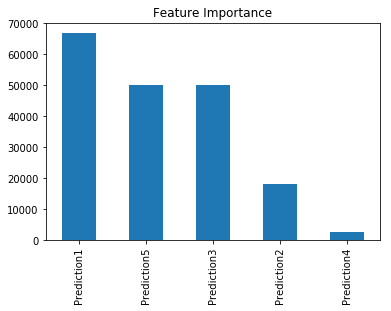

In [166]:
predictors = [x for x in x_train.drop(target_ensamble, axis = 1).columns]
feat_imp = pd.Series(model_ensamble.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [106]:
y_pred = model_ensamble.predict(x_test.drop(target_ensamble, axis=1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.06650630096214057

## PREDICCION EN VALIDACION

In [109]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
model_valid_pred = []
pred = model1.predict(validation.drop(leak, axis = 1))
model_valid_pred.append(pred)
pred = model2.predict_proba(validation.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)
ada_vali = preprocess(vali, ada = True)
pred = model3.predict_proba(ada_vali.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)
pred = model4.predict(validation.drop(leak, axis = 1))
model_valid_pred.append(pred)

In [110]:
valid_ensamble = data_ensamble(vali, model_valid_pred)

In [111]:
valid_ensamble

,Opportunity_ID,Prediction1,Prediction2,Prediction3,Prediction4
0,10689,0.999197,0.996955,0.999389,0.999189
1,10689,0.999463,0.997962,0.999621,0.999649
2,10689,0.999366,0.997804,0.999402,0.999623
3,10690,0.994361,0.994009,0.997194,0.995753
4,10690,0.997899,0.995094,0.998315,0.998606
5,10690,0.998535,0.995747,0.998503,0.999250
6,10690,0.997482,0.995133,0.996096,0.998369
7,10690,0.996607,0.993390,0.996388,0.998212
8,10691,0.905726,0.969127,0.994164,0.829626
9,10692,0.818120,0.978102,0.996750,0.532686


In [216]:
final_pred = model_ensamble.predict(valid_ensamble.drop(["Opportunity_ID"], axis=1))
final_pred = pd.DataFrame(final_pred, index = valid_ensamble.index, columns = ["Prediction"])
answer = valid_ensamble.join(final_pred)
answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [217]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9887088082667632

In [219]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.988558566228558

In [220]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9918167240527008

In [223]:
prev = pd.read_csv("submission_ensambler_1.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

1.0

In [172]:
answer

,Opportunity_ID,Prediction
0,10689,0.994496
1,10690,0.994496
2,10691,0.994496
3,10692,0.994496
4,10693,0.994029
5,10694,0.672453
6,10695,0.217441
7,10696,0.217441
8,10697,0.217441
9,10698,0.007171


In [136]:
answer.to_csv("submission_ensambler_2.csv", index = False, header = False)

## LOGISTIC REGRESSION ENSAMBLER

In [112]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().set_params(penalty = 'l2', max_iter = 5000, verbose = 1)
x_train, x_test, y_train, y_test = train_test_split(df_ensamble, df_ensamble.Stage, test_size = 0.3, random_state = 0)
logreg.fit(x_train.drop(target_ensamble, axis = 1), y_train)

[LibLinear]

/home/eugenio/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [113]:
y_pred = logreg.predict_proba(x_test.drop(target_ensamble, axis = 1))[:,1]
log_loss(y_test, y_pred)

0.07100101893601493

In [114]:
logreg.coef_

array([[4.12498163, 2.23204062, 5.58229846, 1.90781215]])

In [115]:
logreg_pred = logreg.predict_proba(valid_ensamble.drop(["Opportunity_ID"], axis = 1))[:,1]
logreg_pred = pd.DataFrame(logreg_pred, index = valid_ensamble.index, columns = ["Prediction"])
logreg_pred = valid_ensamble.join(logreg_pred)
logreg_pred = pd.DataFrame(logreg_pred.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [116]:
logreg_pred

,Opportunity_ID,Prediction
0,10689,0.999307
1,10690,0.999285
2,10691,0.998453
3,10692,0.996746
4,10693,0.999146
5,10694,0.999123
6,10695,0.001670
7,10696,0.001775
8,10697,0.002307
9,10698,0.001540


In [117]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9925129377504717

In [118]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9970651677847097

In [120]:
prev = pd.read_csv("submission_ensambler_1.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9900983573484653

In [121]:
logreg_pred.to_csv("best/logreg_ensamble.csv", index = False, header = False)

## ENSAMBLER CON PESOS (DEL LOGREG)

In [122]:
l = list(logreg.coef_[0])
l = l/sum(l)

In [123]:
predictions = valid_ensamble.drop(["Opportunity_ID"], axis = 1).columns

In [124]:
answer = valid_ensamble.copy()
answer["Prediction"] = sum([l[i] * answer[predictions[i]] for i in range(len(l))])
answer = answer[["Opportunity_ID", "Prediction"]]
answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [125]:
answer

,Opportunity_ID,Prediction
0,10689,0.999129
1,10690,0.996882
2,10691,0.941114
3,10692,0.888628
4,10693,0.984059
5,10694,0.982093
6,10695,0.012163
7,10696,0.016569
8,10697,0.035546
9,10698,0.006306


In [126]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9956272211824839

In [127]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9951337960048813

In [128]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9985382978685517

In [263]:
answer.to_csv("submission_ensambler_4.csv", index = False, header = False)

## PROMEDIO DE LOS DOS MEJORES

In [26]:
ada = pd.read_csv("best/modelada_pred.csv", names = ["Opportunity_ID", "Prediction"])
cat = pd.read_csv("best/modelcat_pred.csv", names = ["Opportunity_ID", "Prediction"])
lgbm = pd.read_csv("best/modellgbold_pred.csv", names = ["Opportunity_ID", "Prediction"])

In [27]:
answer = ada.merge(cat, on = "Opportunity_ID")

In [28]:
answer.Opportunity_ID = answer.Opportunity_ID.astype("int32")

In [30]:
answer = answer.merge(lgbm, on = "Opportunity_ID")

In [31]:
answer

,Opportunity_ID,Prediction_x,Prediction_y,Prediction
0,10689,0.999471,0.997574,0.997994
1,10690,0.997299,0.994675,0.991791
2,10691,0.994164,0.969127,0.992083
3,10692,0.996771,0.978247,0.926446
4,10693,0.984526,0.967347,0.979495
5,10694,0.980587,0.976924,0.979495
6,10695,0.027921,0.000530,0.011361
7,10696,0.038997,0.000426,0.007405
8,10697,0.080582,0.001642,0.024714
9,10698,0.014155,0.000530,0.004736


In [15]:
answer["Prediction"] = 0.5 * answer.Prediction_x + 0.5 * answer.Prediction_y

In [16]:
answer[["Opportunity_ID", "Prediction"]].to_csv("best/avg_ada_cat.csv", index = False, header = False)

In [32]:
answer[abs(answer.Prediction_x - answer.Prediction_y) > 0.1]

,Opportunity_ID,Prediction_x,Prediction_y,Prediction
11,10700,0.144049,0.008330,0.087465
12,10701,0.126264,0.009889,0.053375
41,10730,0.253977,0.505366,0.581300
57,10746,0.984786,0.815077,0.824225
58,10747,0.984786,0.815077,0.824225
85,10774,0.683697,0.837244,0.854461
86,10775,0.531727,0.850646,0.796038
87,10776,0.744547,0.952730,0.915943
187,10876,0.019632,0.151601,0.048755
232,10921,0.656913,0.990034,0.998025
